In [2]:
import sys
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/poc")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins")
sys.path.append("/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/dags")

#Import libs python
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import date

#Import libs internas
from utils import spark_utils_session as utils

from hooks.hdfs.hdfs_helper import HdfsHelper
from jobs.job_base_config import BaseETLJobClass

import poc_helper
poc_helper.load_env("PROD")

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/airflow_metastore_helper.py:10 DeprecatedImportWarning: The `airflow.utils.xcom.XCOM_RETURN_KEY` attribute is deprecated. Please use `'airflow.models.xcom.XCOM_RETURN_KEY'`.

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/impala_helper.py:6 DeprecatedImportWarning: The `airflow.hooks.base.BaseHook` attribute is deprecated. Please use `'airflow.sdk.bases.hook.BaseHook'`.

/home/tsevero/notebooks/SAT_BIG_DATA/data-pipeline/batch/plugins/hooks/db/postgres_helper.py:4 DeprecatedImportWarning: The `airflow.hooks.base.BaseHook` attribute is deprecated. Please use `'airflow.sdk.bases.hook.BaseHook'`.

'.env_file' loaded!
ENV 'PROD' configured!


In [3]:
def get_session(profile: str, dynamic_allocation_enabled: bool = True) -> utils.DBASparkAppSession:
    """Generates DBASparkAppSession."""
    
    app_name = "tsevero_cobranca"
    
    spark_builder = (utils.DBASparkAppSession
                     .builder
                     .setAppName(app_name)
                     .usingProcessProfile(profile)
                    )
    
    if dynamic_allocation_enabled:
        spark_builder.autoResourceManagement()

    return spark_builder.build()

session = get_session(profile='efd_t2')

2025-10-09T13:10:14.096497Z [info     ] Using json file settings.      [root] loc=spark_utils_session.py:301
2025-10-09T13:10:14.097779Z [info     ] Exporting default ENV.         [root] loc=spark_utils_session.py:305
2025-10-09T13:10:14.098162Z [info     ] Exporting custom ENVs.         [root] loc=spark_utils_session.py:338
2025-10-09T13:10:14.098764Z [info     ] Building profile 'efd_t2'.     [root] loc=spark_utils_session.py:221
2025-10-09T13:10:14.099224Z [info     ] Not enough info for building the kerberos client. Ignoring it [root] loc=spark_utils_session.py:284


:: loading settings :: url = jar:file:/opt/cloudera/parcels/SPARK3-3.5.4.3.5.7191000.0-30-1.p0.68499982/lib/spark3/jars/ivy-2.5.2.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/tsevero/.ivy2/cache
The jars for the packages stored in: /home/tsevero/.ivy2/jars
com.databricks#spark-xml_2.12 added as a dependency
org.apache.iceberg#iceberg-spark-runtime-3.5_2.12 added as a dependency
com.oracle.database.security#oraclepki added as a dependency
com.oracle.database.security#osdt_core added as a dependency
com.oracle.database.security#osdt_cert added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-72f1fbb0-274e-4b20-95b7-37325bf090c2;1.0
	confs: [default]
	found com.databricks#spark-xml_2.12;0.18.0 in central
	found commons-io#commons-io;2.11.0 in central
	found org.glassfish.jaxb#txw2;3.0.2 in central
	found org.apache.ws.xmlschema#xmlschema-core;2.3.0 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.9.0 in central
	found org.apache.iceberg#iceberg-spark-runtime-3.5_2.12;1.9.2 in central
	found com.oracle.database.security#oraclepki;21.18.0.0 in central
	found com.oracle.databa

In [4]:
session.sparkSession.sql("SHOW DATABASES").show(truncate=False)

Hive Session ID = 87cae4ac-fcaa-4ce8-b75b-fc5a74e2d3c3


+------------------+
|namespace         |
+------------------+
|anac              |
|bcadastro         |
|bpe               |
|c115              |
|ccc               |
|ccg               |
|cte               |
|default           |
|destda            |
|detran_share      |
|dime              |
|due               |
|efd               |
|fci               |
|gecob             |
|gescol            |
|gessimples        |
|gplam             |
|information_schema|
|malhas            |
+------------------+
only showing top 20 rows



VALIDAÇÃO DA ESTRUTURA DAS TABELAS (SQL V1.4)

1. Colunas da prior_master_consolidado:
❌ ERRO ao descrever tabela: name 'spark' is not defined

2. Verificando colunas importantes:
  ⚠️  Erro na verificação: name 'colunas_master' is not defined

3. Verificando localização do score:
  ⚠️  Erro: name 'colunas_master' is not defined

4. Teste básico de contagem:
  ❌ ERRO: name 'spark' is not defined

5. Testando JOIN master x score (versão simplificada):
  ❌ ERRO no JOIN: name 'spark' is not defined

6. Verificando duplicatas (amostra):
  ❌ ERRO: name 'spark' is not defined

7. Estatísticas básicas:
  ❌ ERRO: name 'spark' is not defined

✅ VALIDAÇÃO CONCLUÍDA

💡 PRÓXIMOS PASSOS:
   1. Se houver erro de SparkContext parado, REINICIE a célula 2
   2. Se o JOIN funcionou, pode continuar com as análises
   3. Se houver duplicatas, verifique o SQL V1.4


In [6]:
# Bibliotecas para análise e visualização
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from datetime import date, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['font.size'] = 11

# Acesso ao SparkSession
spark = session.sparkSession

print("=" * 80)
print("SISTEMA DE PRIORIZAÇÃO DE COBRANÇA - GECOB")
print("=" * 80)
print(f"Iniciado em: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 80)
print(f"\nSessão Spark: {spark.sparkContext.appName}")
print(f"Versão Spark: {spark.version}")
print("=" * 80)

SISTEMA DE PRIORIZAÇÃO DE COBRANÇA - GECOB
Iniciado em: 2025-10-09 10:11:13

Sessão Spark: tsevero_cobranca
Versão Spark: 3.5.4.3.5.7191000.0-30


In [7]:
# ============================================================================
# VALIDAÇÃO DA ESTRUTURA - SQL V1.4 (CORRIGIDA)
# ============================================================================
print("=" * 80)
print("VALIDAÇÃO DA ESTRUTURA DAS TABELAS (SQL V1.4)")
print("=" * 80)

# 1. Verificar colunas da master_consolidado
print("\n1. Colunas da prior_master_consolidado:")
try:
    colunas_master = spark.sql("DESCRIBE gecob.prior_master_consolidado").toPandas()
    print(f"Total: {len(colunas_master)} colunas")
    print("\nPrimeiras 20 colunas:")
    for idx, col in enumerate(colunas_master['col_name'].head(20), 1):
        print(f"  {idx:2d}. {col}")
    
    # Verificar se há coluna tipo_debito
    if 'tipo_debito' in colunas_master['col_name'].values:
        print("\n✅ Coluna 'tipo_debito' encontrada")
    else:
        print("\n❌ ATENÇÃO: Coluna 'tipo_debito' NÃO encontrada!")
except Exception as e:
    print(f"❌ ERRO ao descrever tabela: {str(e)[:200]}")

# 2. Verificar métricas temporais de contato
print("\n2. Verificando colunas importantes:")
colunas_importantes = [
    'qtd_contatos_ultimos_30_dias',
    'qtd_contatos_ultimos_90_dias',
    'inscricao_estadual',
    'tipo_debito',
    'valor_total_devido'
]

try:
    for col in colunas_importantes:
        if col in colunas_master['col_name'].values:
            print(f"  ✅ {col}")
        else:
            print(f"  ❌ {col} - NÃO ENCONTRADA")
except Exception as e:
    print(f"  ⚠️  Erro na verificação: {str(e)[:100]}")

# 3. Verificar se score está em master ou apenas em score_priorizacao
print("\n3. Verificando localização do score:")
try:
    if 'score_final_priorizacao' in colunas_master['col_name'].values:
        print("  ℹ️  Score encontrado em prior_master_consolidado")
    else:
        print("  ℹ️  Score NÃO está em master (esperado - deve estar em prior_score_priorizacao)")
        
        # Verificar tabela de score
        colunas_score = spark.sql("DESCRIBE gecob.prior_score_priorizacao").toPandas()
        if 'score_final_priorizacao' in colunas_score['col_name'].values:
            print("  ✅ Score encontrado em prior_score_priorizacao")
        else:
            print("  ❌ Score NÃO encontrado em prior_score_priorizacao")
except Exception as e:
    print(f"  ⚠️  Erro: {str(e)[:100]}")

# 4. Teste simples de contagem (SEM JOIN complexo)
print("\n4. Teste básico de contagem:")
try:
    # Contagem simples da master
    count_master = spark.sql("SELECT COUNT(*) as cnt FROM gecob.prior_master_consolidado").collect()[0]['cnt']
    print(f"  ✅ Registros em prior_master_consolidado: {count_master:,}")
    
    # Contagem da tabela de score
    count_score = spark.sql("SELECT COUNT(*) as cnt FROM gecob.prior_score_priorizacao").collect()[0]['cnt']
    print(f"  ✅ Registros em prior_score_priorizacao: {count_score:,}")
    
except Exception as e:
    print(f"  ❌ ERRO: {str(e)[:200]}")

# 5. Testar JOIN simples (apenas contagem)
print("\n5. Testando JOIN master x score (versão simplificada):")
try:
    test_join = spark.sql("""
        SELECT COUNT(*) as total
        FROM gecob.prior_master_consolidado mc
        INNER JOIN gecob.prior_score_priorizacao sp 
            ON mc.inscricao_estadual = sp.inscricao_estadual
            AND mc.tipo_debito = sp.tipo_debito
        LIMIT 10
    """)
    
    # Forçar execução
    result = test_join.collect()
    print(f"  ✅ JOIN funcionando! Total: {result[0]['total']:,}")
    
except Exception as e:
    error_msg = str(e)
    if "stopped SparkContext" in error_msg:
        print(f"  ❌ SparkContext parado - REINICIE A CÉLULA 2 (Sessão Spark)")
    else:
        print(f"  ❌ ERRO no JOIN: {error_msg[:200]}")

# 6. Verificar duplicatas (versão simplificada)
print("\n6. Verificando duplicatas (amostra):")
try:
    dups_sample = spark.sql("""
        SELECT 
            inscricao_estadual,
            tipo_debito,
            COUNT(*) as qtd
        FROM gecob.prior_master_consolidado
        GROUP BY inscricao_estadual, tipo_debito
        HAVING COUNT(*) > 1
        LIMIT 5
    """).collect()
    
    if len(dups_sample) > 0:
        print(f"  ⚠️  ATENÇÃO: Encontradas {len(dups_sample)} chaves duplicadas (amostra)")
        for row in dups_sample[:3]:
            print(f"     IE: {row['inscricao_estadual']} | Tipo: {row['tipo_debito']} | Qtd: {row['qtd']}")
    else:
        print(f"  ✅ Nenhuma duplicata encontrada (chave: IE + tipo_debito)")
        
except Exception as e:
    error_msg = str(e)
    if "stopped" in error_msg.lower():
        print(f"  ❌ SparkContext parado - REINICIE o notebook")
    else:
        print(f"  ❌ ERRO: {error_msg[:200]}")

# 7. Estatísticas básicas rápidas
print("\n7. Estatísticas básicas:")
try:
    stats = spark.sql("""
        SELECT 
            COUNT(DISTINCT inscricao_estadual) as empresas,
            COUNT(*) as registros,
            CAST(SUM(valor_total_devido) AS DOUBLE) as valor_total
        FROM gecob.prior_master_consolidado
    """).collect()[0]
    
    print(f"  Empresas únicas: {stats['empresas']:,}")
    print(f"  Total registros: {stats['registros']:,}")
    print(f"  Valor total: R$ {stats['valor_total']/1e9:.2f} bilhões")
    print(f"  Média de débitos/empresa: {stats['registros']/stats['empresas']:.1f}")
    
except Exception as e:
    print(f"  ❌ ERRO: {str(e)[:200]}")

print("\n" + "=" * 80)
print("✅ VALIDAÇÃO CONCLUÍDA")
print("=" * 80)
print("\n💡 PRÓXIMOS PASSOS:")
print("   1. Se houver erro de SparkContext parado, REINICIE a célula 2")
print("   2. Se o JOIN funcionou, pode continuar com as análises")
print("   3. Se houver duplicatas, verifique o SQL V1.4")
print("=" * 80)

VALIDAÇÃO DA ESTRUTURA DAS TABELAS (SQL V1.4)

1. Colunas da prior_master_consolidado:
Total: 137 colunas

Primeiras 20 colunas:
   1. inscricao_estadual
   2. tipo_debito
   3. status_debito
   4. valor_total_devido
   5. data_inclusao_cobranca
   6. data_limite_pagamento
   7. data_exclusao_moroso
   8. data_ultima_transacao
   9. flag_com_garantia
  10. flag_devedor_contumaz
  11. flag_recuperacao_judicial
  12. flag_falencia
  13. flag_protesto
  14. grupo_imposto
  15. seq_ultimo_contato
  16. grupo_setorial
  17. codigo_gereg
  18. codigo_usefi
  19. situacao_cadastral_rge
  20. tipo_regime_rge

✅ Coluna 'tipo_debito' encontrada

2. Verificando colunas importantes:
  ✅ qtd_contatos_ultimos_30_dias
  ✅ qtd_contatos_ultimos_90_dias
  ✅ inscricao_estadual
  ✅ tipo_debito
  ✅ valor_total_devido

3. Verificando localização do score:
  ℹ️  Score NÃO está em master (esperado - deve estar em prior_score_priorizacao)
  ✅ Score encontrado em prior_score_priorizacao

4. Teste básico de cont

  ✅ Registros em prior_master_consolidado: 279,490
  ✅ Registros em prior_score_priorizacao: 279,490

5. Testando JOIN master x score (versão simplificada):


  ✅ JOIN funcionando! Total: 279,490

6. Verificando duplicatas (amostra):


  ✅ Nenhuma duplicata encontrada (chave: IE + tipo_debito)

7. Estatísticas básicas:
  Empresas únicas: 250,945
  Total registros: 279,490
  Valor total: R$ 146.37 bilhões
  Média de débitos/empresa: 1.1

✅ VALIDAÇÃO CONCLUÍDA

💡 PRÓXIMOS PASSOS:
   1. Se houver erro de SparkContext parado, REINICIE a célula 2
   2. Se o JOIN funcionou, pode continuar com as análises
   3. Se houver duplicatas, verifique o SQL V1.4


In [8]:
# ============================================================================
# CÉLULA 3: VERIFICAÇÃO DE TABELAS DISPONÍVEIS
# ============================================================================
print("\n" + "=" * 80)
print("VERIFICAÇÃO DE TABELAS DO SISTEMA GECOB")
print("=" * 80)

tabelas_gecob = [
    'gecob.prior_debitos_base',
    'gecob.prior_conta_corrente',
    'gecob.prior_contribuintes_cadastro',
    'gecob.prior_historico_contatos',
    'gecob.prior_parcelamentos',
    'gecob.prior_score_noteiras',
    'gecob.prior_pagamentos_historico',
    'gecob.prior_declaracoes_dime',
    'gecob.prior_master_consolidado',
    'gecob.prior_features_ml',
    'gecob.prior_benchmark_setorial',
    'gecob.prior_score_componentes',
    'gecob.prior_score_priorizacao'
]

print("\nVerificando tabelas do sistema GECOB:\n")
tabelas_disponiveis = {}
for tabela in tabelas_gecob:
    try:
        count = spark.sql(f"SELECT COUNT(*) as cnt FROM {tabela}").collect()[0]['cnt']
        print(f"✓ {tabela:50s} -> {count:,} registros")
        tabelas_disponiveis[tabela] = count
    except Exception as e:
        print(f"✗ {tabela:50s} -> NÃO ENCONTRADA")
        tabelas_disponiveis[tabela] = 0

print("\n" + "=" * 80)


VERIFICAÇÃO DE TABELAS DO SISTEMA GECOB

Verificando tabelas do sistema GECOB:

✓ gecob.prior_debitos_base                           -> 570,117 registros
✓ gecob.prior_conta_corrente                         -> 2,554,038 registros
✓ gecob.prior_contribuintes_cadastro                 -> 1,185,220 registros
✓ gecob.prior_historico_contatos                     -> 478,561 registros
✓ gecob.prior_parcelamentos                          -> 561,999 registros
✓ gecob.prior_score_noteiras                         -> 519,134 registros
✓ gecob.prior_pagamentos_historico                   -> 168,106 registros
✓ gecob.prior_declaracoes_dime                       -> 85,595 registros
✓ gecob.prior_master_consolidado                     -> 279,490 registros
✓ gecob.prior_features_ml                            -> 279,490 registros
✓ gecob.prior_benchmark_setorial                     -> 587 registros
✓ gecob.prior_score_componentes                      -> 279,490 registros
✓ gecob.prior_score_priorizacao 

In [9]:
# ============================================================================
# CÉLULA 4: PANORAMA GERAL DO SISTEMA (ATUALIZADA V1.4)
# ============================================================================
print("\n" + "=" * 80)
print("1. PANORAMA GERAL DO SISTEMA DE PRIORIZAÇÃO")
print("=" * 80)

query_panorama = """
SELECT 
    COUNT(DISTINCT inscricao_estadual) AS total_empresas,
    COUNT(*) AS total_debitos,
    SUM(valor_total_devido) AS valor_total_cobranca,
    AVG(valor_total_devido) AS valor_medio_debito,
    MAX(valor_total_devido) AS maior_debito,
    
    -- Distribuição por Status
    SUM(CASE WHEN status_debito = 1 THEN 1 ELSE 0 END) AS debitos_ativos,
    SUM(CASE WHEN status_debito = 2 THEN 1 ELSE 0 END) AS debitos_pagos,
    
    -- Flags de Risco
    SUM(CASE WHEN flag_falencia = 1 THEN 1 ELSE 0 END) AS empresas_falencia,
    SUM(CASE WHEN flag_recuperacao_judicial = 1 THEN 1 ELSE 0 END) AS empresas_recuperacao,
    SUM(CASE WHEN flag_devedor_contumaz = 1 THEN 1 ELSE 0 END) AS devedores_contumazes,
    
    -- Contatos (ATUALIZADO V1.4)
    AVG(qtd_total_contatos) AS media_contatos,
    AVG(taxa_resposta_contatos) AS media_taxa_resposta,
    AVG(COALESCE(qtd_contatos_ultimos_30_dias, 0)) AS media_contatos_30d,
    AVG(COALESCE(qtd_contatos_ultimos_90_dias, 0)) AS media_contatos_90d,
    
    -- Pagamentos
    AVG(qtd_periodos_pagamento_6m) AS media_periodos_pagamento,
    AVG(valor_total_pago_6m) AS media_valor_pago_6m,
    
    -- Noteiras
    AVG(score_noteiras) AS media_score_noteiras,
    SUM(CASE WHEN classificacao_risco_noteiras IN ('ALTO', 'CRITICO') THEN 1 ELSE 0 END) AS empresas_alto_risco_noteiras

FROM gecob.prior_master_consolidado
"""

df_panorama = spark.sql(query_panorama)
panorama = df_panorama.collect()[0]

print(f"\nMÉTRICAS PRINCIPAIS:")
print(f"  Total de Empresas em Cobrança: {panorama['total_empresas']:,}")
print(f"  Total de Débitos: {panorama['total_debitos']:,}")
print(f"  Valor Total em Cobrança: R$ {panorama['valor_total_cobranca']:,.2f}")
print(f"  Valor Médio por Débito: R$ {panorama['valor_medio_debito']:,.2f}")
print(f"  Maior Débito: R$ {panorama['maior_debito']:,.2f}")

print(f"\nSTATUS DOS DÉBITOS:")
print(f"  Débitos Ativos: {panorama['debitos_ativos']:,}")
print(f"  Débitos Pagos: {panorama['debitos_pagos']:,}")

print(f"\nFLAGS DE RISCO:")
print(f"  Empresas em Falência: {panorama['empresas_falencia']:,}")
print(f"  Empresas em Recuperação Judicial: {panorama['empresas_recuperacao']:,}")
print(f"  Devedores Contumazes: {panorama['devedores_contumazes']:,}")

print(f"\nCOMPORTAMENTO:")
print(f"  Média de Contatos por Empresa: {panorama['media_contatos']:.1f}")
print(f"  Taxa Média de Resposta: {panorama['media_taxa_resposta']:.1%}")
print(f"  Média Contatos Últimos 30 dias: {panorama['media_contatos_30d']:.1f}  [NOVO V1.4]")
print(f"  Média Contatos Últimos 90 dias: {panorama['media_contatos_90d']:.1f}  [NOVO V1.4]")
print(f"  Média Períodos com Pagamento (6m): {panorama['media_periodos_pagamento']:.1f}")

print(f"\nNOTEIRAS:")
print(f"  Score Médio de Noteiras: {panorama['media_score_noteiras']:.1f}")
print(f"  Empresas Alto Risco (Noteiras): {panorama['empresas_alto_risco_noteiras']:,}")


1. PANORAMA GERAL DO SISTEMA DE PRIORIZAÇÃO


[Stage 65:>                                                         (0 + 8) / 8]


MÉTRICAS PRINCIPAIS:
  Total de Empresas em Cobrança: 250,945
  Total de Débitos: 279,490
  Valor Total em Cobrança: R$ 146,367,043,765.45
  Valor Médio por Débito: R$ 523,693.31
  Maior Débito: R$ 4,643,247,426.24

STATUS DOS DÉBITOS:
  Débitos Ativos: 279,490
  Débitos Pagos: 0

FLAGS DE RISCO:
  Empresas em Falência: 77
  Empresas em Recuperação Judicial: 1
  Devedores Contumazes: 26

COMPORTAMENTO:
  Média de Contatos por Empresa: 536.9
  Taxa Média de Resposta: 30.9%
  Média Contatos Últimos 30 dias: 2.5  [NOVO V1.4]
  Média Contatos Últimos 90 dias: 13.3  [NOVO V1.4]
  Média Períodos com Pagamento (6m): 0.3

NOTEIRAS:
  Score Médio de Noteiras: 246.6
  Empresas Alto Risco (Noteiras): 73,849



2. DISTRIBUIÇÃO POR NÍVEL DE PRIORIDADE



DISTRIBUIÇÃO POR PRIORIDADE:

PRIORIDADE_MAXIMA:
  Quantidade: 68 débitos
  Empresas: 66
  Valor Total: R$ 2,197,812,712.16
  Valor Médio: R$ 32,320,775.18
  Score Médio: 81.47

PRIORIDADE_ALTA:
  Quantidade: 5,777 débitos
  Empresas: 4,275
  Valor Total: R$ 91,754,028,384.19
  Valor Médio: R$ 15,882,642.96
  Score Médio: 65.06

PRIORIDADE_MEDIA:
  Quantidade: 29,304 débitos
  Empresas: 20,656
  Valor Total: R$ 50,390,765,417.29
  Valor Médio: R$ 1,719,586.59
  Score Médio: 48.12

PRIORIDADE_BAIXA:
  Quantidade: 244,341 débitos
  Empresas: 232,613
  Valor Total: R$ 2,024,437,251.81
  Valor Médio: R$ 8,285.29
  Score Médio: 26.32



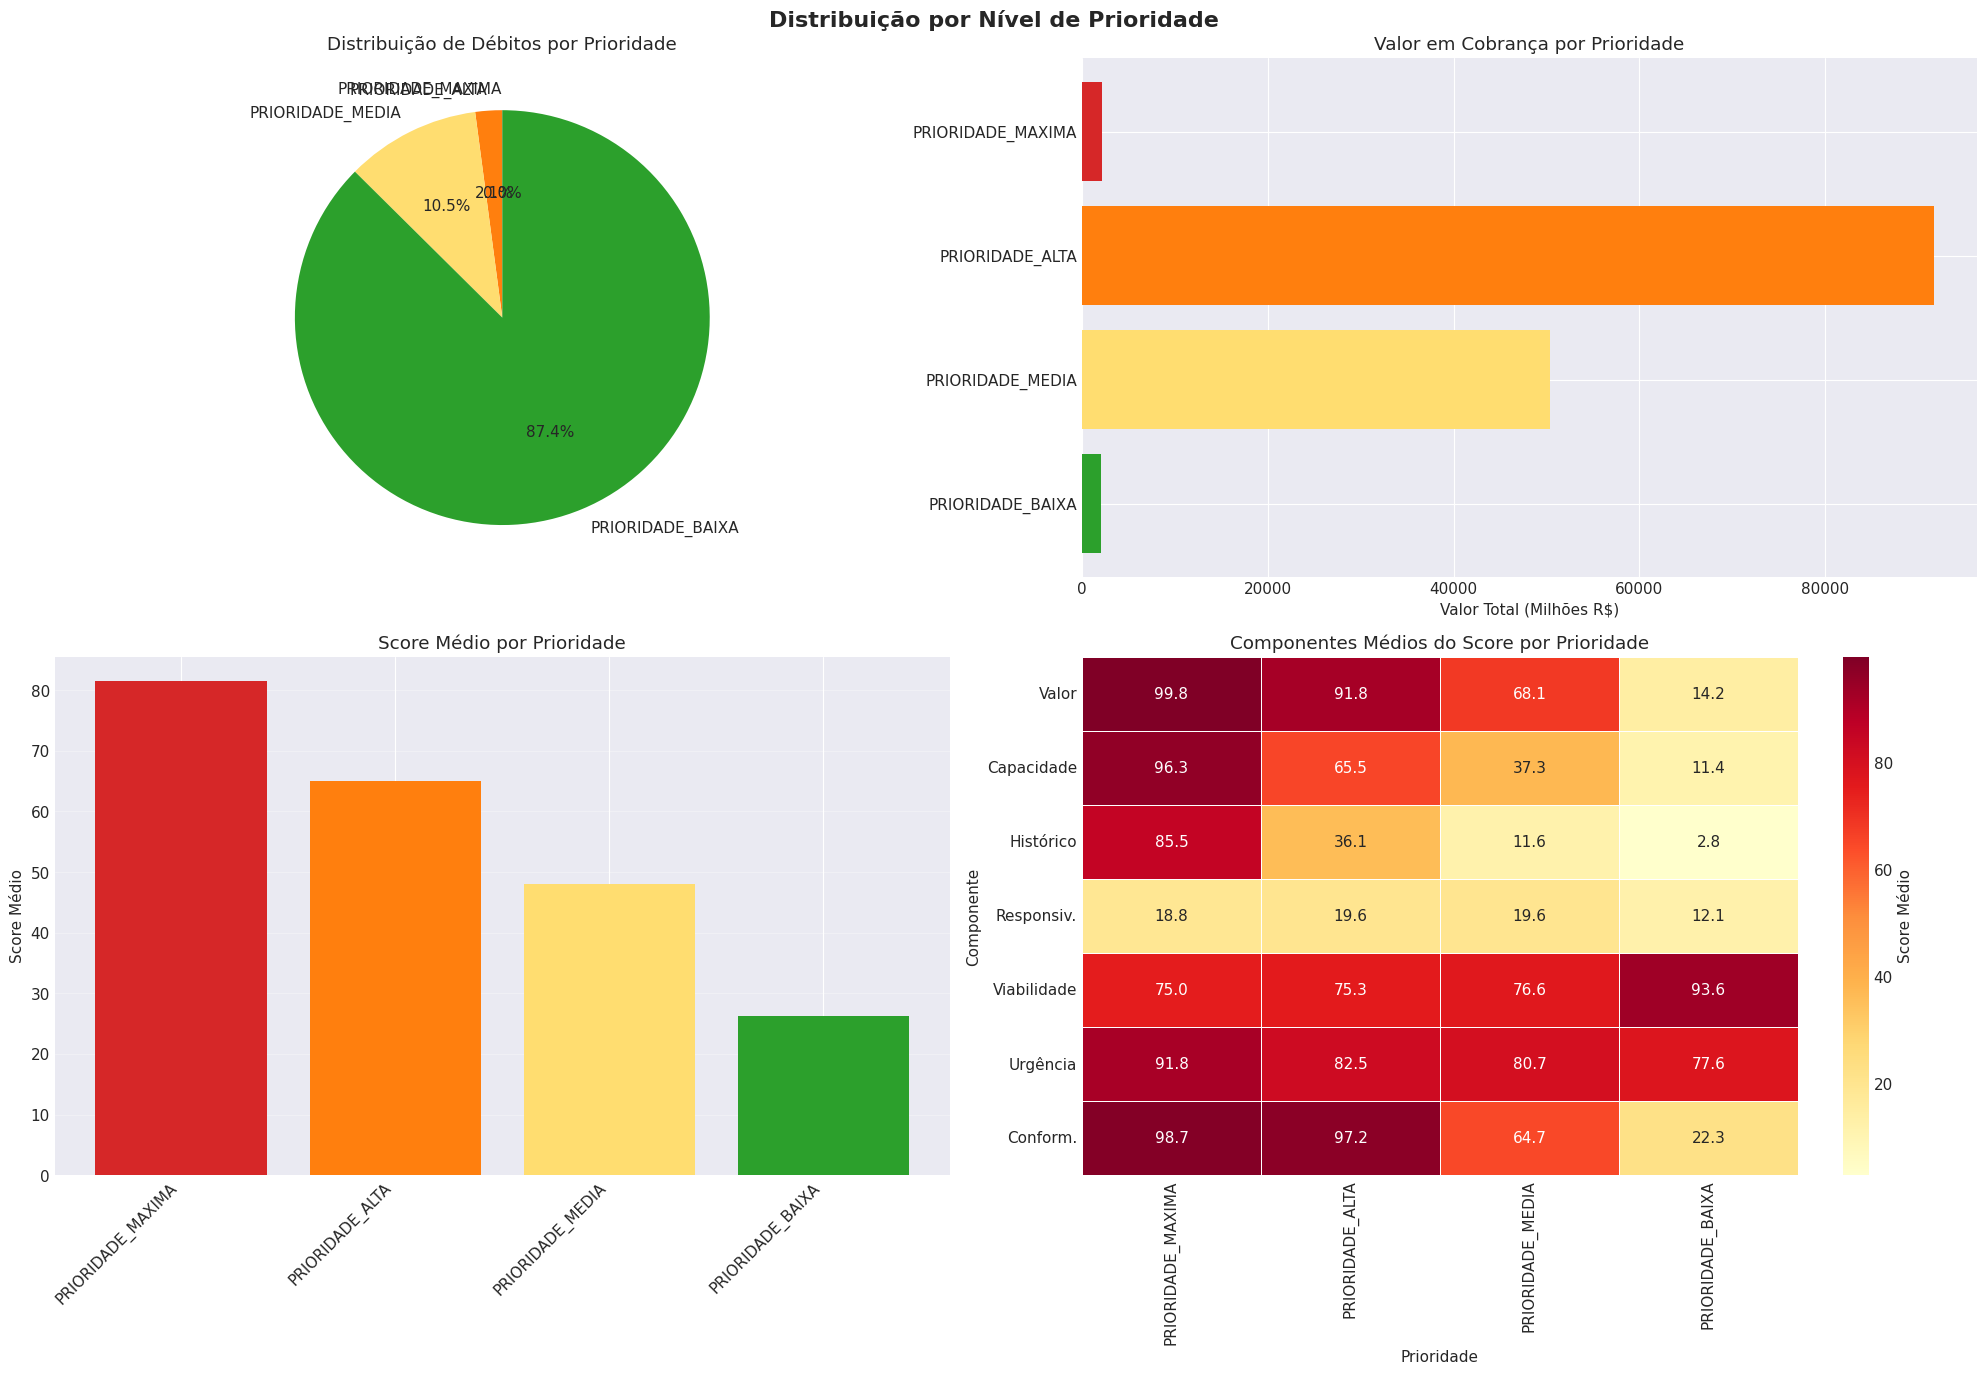

In [10]:
# ============================================================================
# CÉLULA 5: DISTRIBUIÇÃO POR PRIORIDADE
# ============================================================================
print("\n" + "=" * 80)
print("2. DISTRIBUIÇÃO POR NÍVEL DE PRIORIDADE")
print("=" * 80)

query_priorizacao = """
SELECT 
    classificacao_prioridade,
    COUNT(*) AS quantidade,
    COUNT(DISTINCT inscricao_estadual) AS empresas_distintas,
    SUM(valor_total_devido) AS valor_total,
    AVG(valor_total_devido) AS valor_medio,
    AVG(score_final_priorizacao) AS score_medio,
    
    -- Componentes de Score Médios
    AVG(score_valor_debito) AS media_score_valor,
    AVG(score_capacidade_pagamento) AS media_score_capacidade,
    AVG(score_historico_pagamento) AS media_score_historico,
    AVG(score_responsividade) AS media_score_responsividade,
    AVG(score_viabilidade_cobranca) AS media_score_viabilidade,
    AVG(score_urgencia) AS media_score_urgencia,
    AVG(score_conformidade) AS media_score_conformidade

FROM gecob.prior_score_priorizacao
GROUP BY classificacao_prioridade
ORDER BY 
    CASE classificacao_prioridade
        WHEN 'PRIORIDADE_MAXIMA' THEN 1
        WHEN 'PRIORIDADE_ALTA' THEN 2
        WHEN 'PRIORIDADE_MEDIA' THEN 3
        WHEN 'PRIORIDADE_BAIXA' THEN 4
    END
"""

df_priorizacao = spark.sql(query_priorizacao).toPandas()

# Converter Decimal para float
numeric_cols = df_priorizacao.select_dtypes(include=['object']).columns
for col in numeric_cols:
    try:
        df_priorizacao[col] = pd.to_numeric(df_priorizacao[col], errors='ignore')
    except:
        pass

print("\nDISTRIBUIÇÃO POR PRIORIDADE:\n")
for idx, row in df_priorizacao.iterrows():
    print(f"{row['classificacao_prioridade']}:")
    print(f"  Quantidade: {int(row['quantidade']):,} débitos")
    print(f"  Empresas: {int(row['empresas_distintas']):,}")
    print(f"  Valor Total: R$ {float(row['valor_total']):,.2f}")
    print(f"  Valor Médio: R$ {float(row['valor_medio']):,.2f}")
    print(f"  Score Médio: {float(row['score_medio']):.2f}")
    print()

# Visualização
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Distribuição por Nível de Prioridade', fontsize=16, fontweight='bold')

# 1. Pizza - Quantidade
colors = ['#d62728', '#ff7f0e', '#ffdd70', '#2ca02c']
axes[0, 0].pie(df_priorizacao['quantidade'], labels=df_priorizacao['classificacao_prioridade'], 
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 0].set_title('Distribuição de Débitos por Prioridade')

# 2. Barras - Valor Total
axes[0, 1].barh(df_priorizacao['classificacao_prioridade'], 
                df_priorizacao['valor_total']/1e6, color=colors)
axes[0, 1].set_xlabel('Valor Total (Milhões R$)')
axes[0, 1].set_title('Valor em Cobrança por Prioridade')
axes[0, 1].invert_yaxis()

# 3. Barras - Score Médio
axes[1, 0].bar(range(len(df_priorizacao)), df_priorizacao['score_medio'], color=colors)
axes[1, 0].set_xticks(range(len(df_priorizacao)))
axes[1, 0].set_xticklabels(df_priorizacao['classificacao_prioridade'], rotation=45, ha='right')
axes[1, 0].set_ylabel('Score Médio')
axes[1, 0].set_title('Score Médio por Prioridade')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Heatmap - Componentes do Score
score_components = df_priorizacao[['classificacao_prioridade', 'media_score_valor', 
                                     'media_score_capacidade', 'media_score_historico',
                                     'media_score_responsividade', 'media_score_viabilidade',
                                     'media_score_urgencia', 'media_score_conformidade']].set_index('classificacao_prioridade')
score_components.columns = ['Valor', 'Capacidade', 'Histórico', 'Responsiv.', 'Viabilidade', 'Urgência', 'Conform.']
sns.heatmap(score_components.T, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score Médio'}, linewidths=0.5, ax=axes[1, 1])
axes[1, 1].set_title('Componentes Médios do Score por Prioridade')
axes[1, 1].set_xlabel('Prioridade')
axes[1, 1].set_ylabel('Componente')

plt.tight_layout()
plt.show()


3. RANKING: TOP 50 EMPRESAS PRIORITÁRIAS



TOP 50 EMPRESAS POR SCORE DE PRIORIZAÇÃO:

 1. IE: 254433448 | Tipo: 60
    Razão Social: TELEFONICA BRASIL S.A.
    Score: 84.90 | Prioridade: PRIORIDADE_MAXIMA
    Valor Devido: R$ 21,941,079.30
    Porte: GRANDE | Setor: INFORMAÇÃO E COMUNICAÇÃO
    Município: JOINVILLE | Situação: ATIVO
    Contatos: 2291 total | 5 (30d) | 5 (90d) [V1.4]
    Taxa Resposta: 100.0%
    ⚠️ Alertas: NOTEIRAS:CRITICO

 2. IE: 257104496 | Tipo: 40
    Razão Social: AMBEV S.A.
    Score: 83.50 | Prioridade: PRIORIDADE_MAXIMA
    Valor Devido: R$ 5,341,692.00
    Porte: GRANDE | Setor: INDÚSTRIAS DE TRANSFORMAÇÃO
    Município: LAGES | Situação: ATIVO
    Contatos: 691 total | 0 (30d) | 132 (90d) [V1.4]
    Taxa Resposta: 100.0%
    ⚠️ Alertas: NOTEIRAS:CRITICO

 3. IE: 250542994 | Tipo: 40
    Razão Social: OURO PRETO MINERACAO LTDA
    Score: 83.40 | Prioridade: PRIORIDADE_MAXIMA
    Valor Devido: R$ 2,627,082.53
    Porte: GRANDE | Setor: INDÚSTRIAS EXTRATIVAS
    Município: POMERODE | Situação: ATIVO


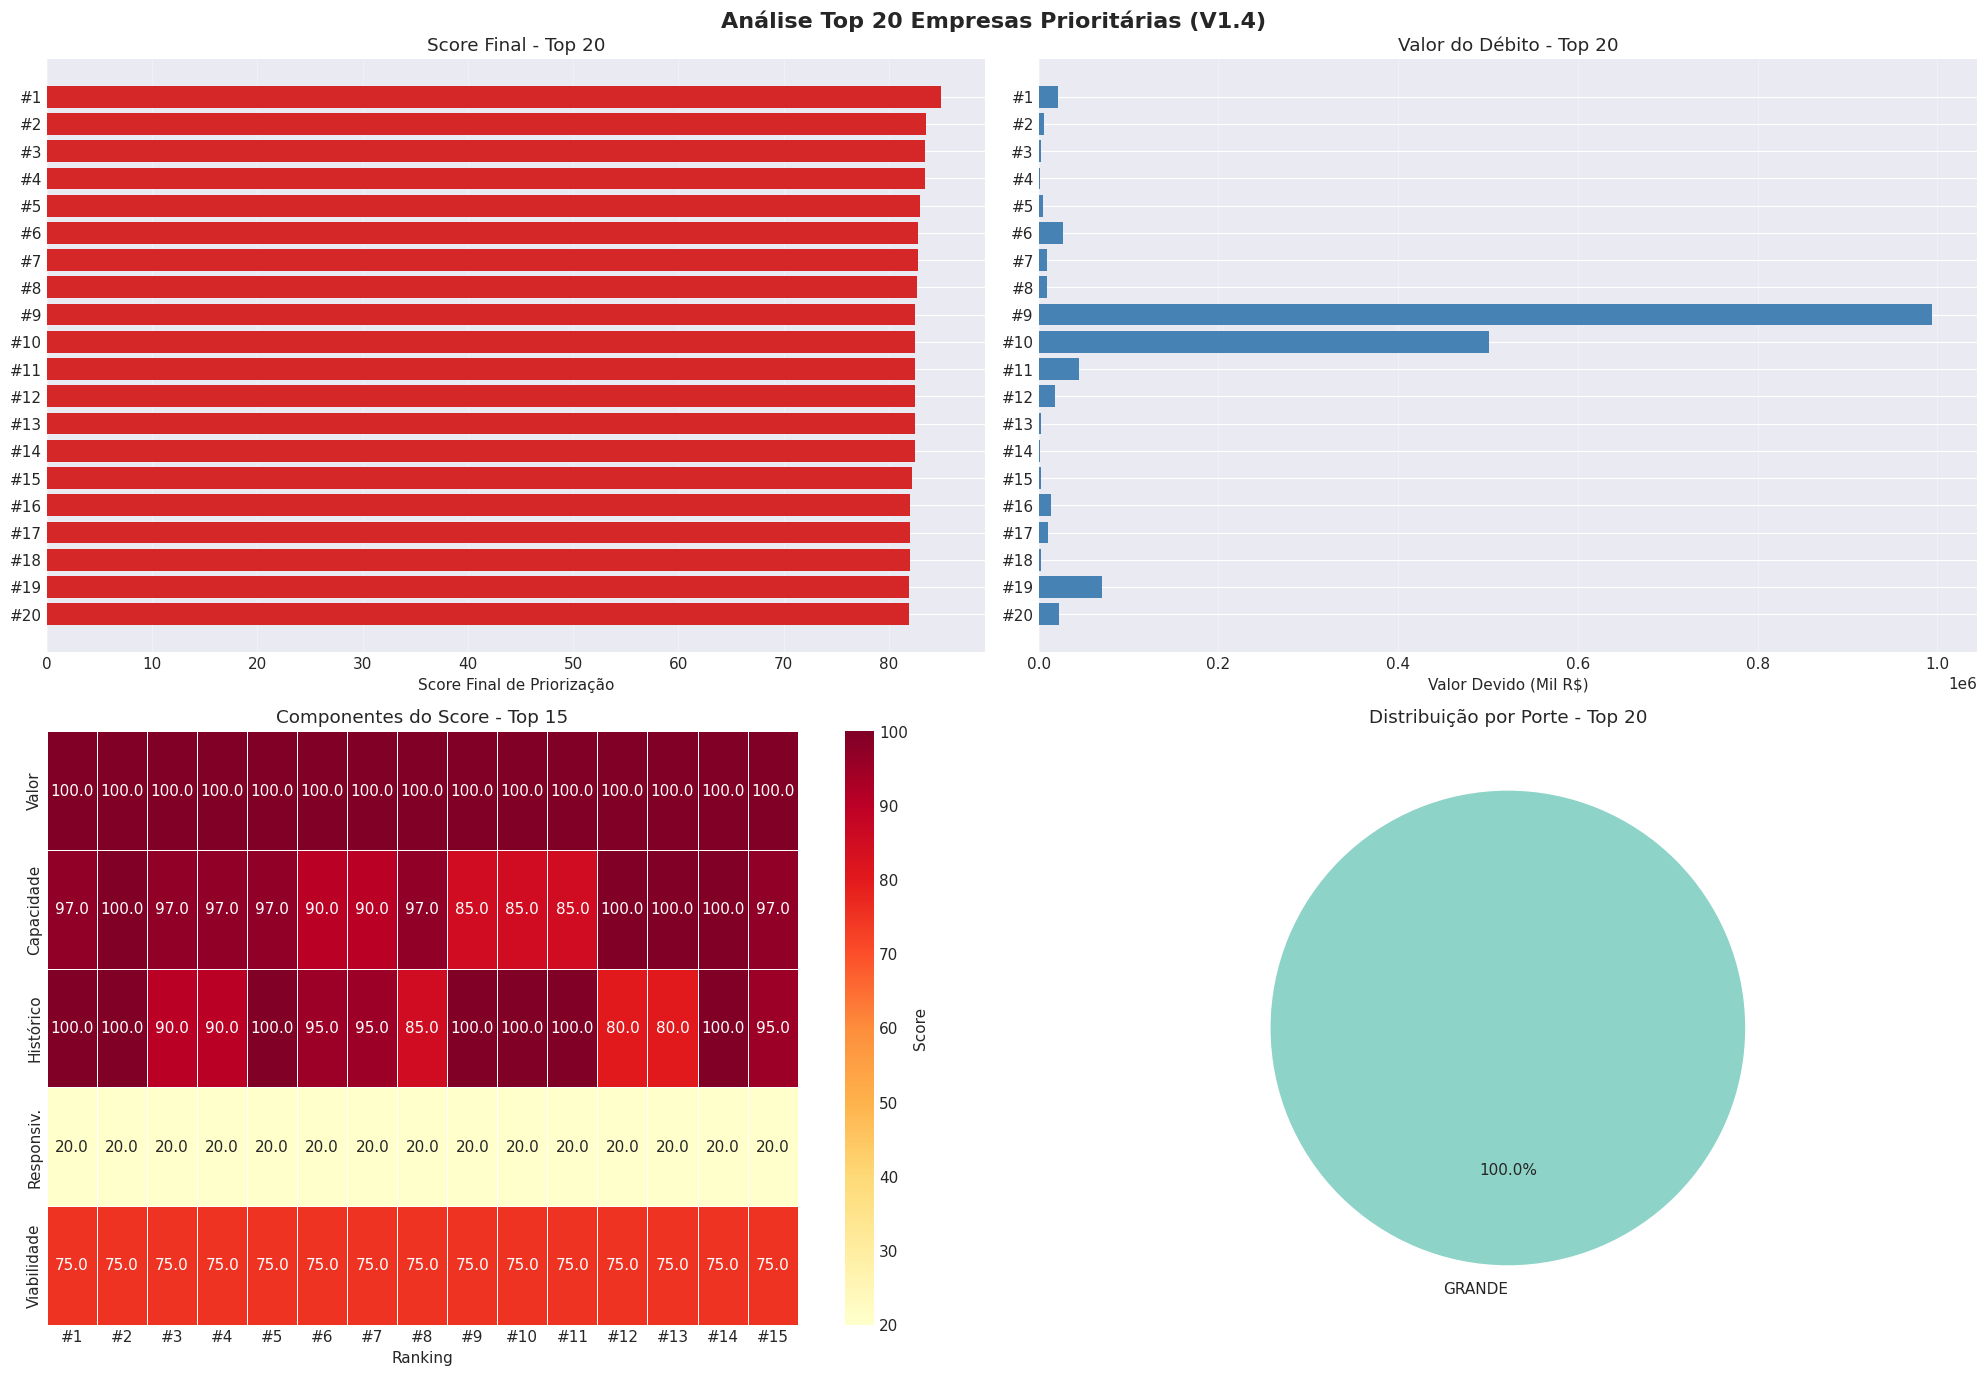


✅ Análise do Top 50 concluída! (V1.4)


In [11]:
# ============================================================================
# CÉLULA 6: TOP 50 EMPRESAS PRIORIZADAS (ATUALIZADA V1.4)
# ============================================================================
print("\n" + "=" * 80)
print("3. RANKING: TOP 50 EMPRESAS PRIORITÁRIAS")
print("=" * 80)

query_top50 = """
SELECT 
    ROW_NUMBER() OVER (ORDER BY sp.score_final_priorizacao DESC, sp.valor_total_devido DESC) AS ranking,
    sp.inscricao_estadual,
    sp.tipo_debito,
    COALESCE(mc.razao_social, 'NÃO INFORMADO') AS razao_social,
    COALESCE(mc.nome_fantasia, 'NÃO INFORMADO') AS nome_fantasia,
    sp.valor_total_devido,
    sp.score_final_priorizacao,
    sp.classificacao_prioridade,
    COALESCE(mc.porte_por_faturamento, 'NÃO INFORMADO') AS porte_por_faturamento,
    COALESCE(mc.secao_cnae, 'N/A') AS secao_cnae,
    COALESCE(mc.descricao_secao, 'NÃO INFORMADO') AS descricao_secao,
    COALESCE(mc.situacao_cadastral_desc, 'NÃO INFORMADO') AS situacao_cadastral_desc,
    COALESCE(mc.codigo_municipio, 0) AS codigo_municipio,
    COALESCE(mc.nome_municipio, 'NÃO INFORMADO') AS nome_municipio,
    
    -- Scores componentes
    sp.score_valor_debito,
    sp.score_capacidade_pagamento,
    sp.score_historico_pagamento,
    sp.score_responsividade,
    sp.score_viabilidade_cobranca,
    
    -- Comportamento (ATUALIZADO V1.4)
    COALESCE(mc.qtd_total_contatos, 0) AS qtd_total_contatos,
    COALESCE(mc.taxa_resposta_contatos, 0) AS taxa_resposta_contatos,
    COALESCE(mc.regularidade_pagamentos, 'NÃO INFORMADO') AS regularidade_pagamentos,
    COALESCE(mc.qtd_contatos_ultimos_30_dias, 0) AS qtd_contatos_30d,
    COALESCE(mc.qtd_contatos_ultimos_90_dias, 0) AS qtd_contatos_90d,
    
    -- Riscos
    COALESCE(mc.flag_falencia, 0) AS flag_falencia,
    COALESCE(mc.flag_recuperacao_judicial, 0) AS flag_recuperacao_judicial,
    COALESCE(mc.flag_devedor_contumaz, 0) AS flag_devedor_contumaz,
    COALESCE(mc.classificacao_risco_noteiras, 'SEM_INDICIO') AS classificacao_risco_noteiras,
    COALESCE(mc.score_noteiras, 0) AS score_noteiras
    
FROM gecob.prior_score_priorizacao sp
INNER JOIN gecob.prior_master_consolidado mc 
    ON sp.inscricao_estadual = mc.inscricao_estadual
    AND sp.tipo_debito = mc.tipo_debito
ORDER BY sp.score_final_priorizacao DESC, sp.valor_total_devido DESC
LIMIT 50
"""

df_top50 = spark.sql(query_top50).toPandas()

# Converter decimals e tratar nulls
for col in df_top50.columns:
    try:
        df_top50[col] = pd.to_numeric(df_top50[col], errors='ignore')
    except:
        pass

# Preencher nulls em strings
string_cols = df_top50.select_dtypes(include=['object']).columns
for col in string_cols:
    df_top50[col] = df_top50[col].fillna('NÃO INFORMADO')

print(f"\nTOP {len(df_top50)} EMPRESAS POR SCORE DE PRIORIZAÇÃO:\n")
for idx, row in df_top50.head(20).iterrows():
    razao = str(row['razao_social'])[:60] if row['razao_social'] else 'NÃO INFORMADO'
    
    print(f"{int(row['ranking']):2d}. IE: {row['inscricao_estadual']} | Tipo: {row['tipo_debito']}")
    print(f"    Razão Social: {razao}")
    print(f"    Score: {float(row['score_final_priorizacao']):.2f} | Prioridade: {row['classificacao_prioridade']}")
    print(f"    Valor Devido: R$ {float(row['valor_total_devido']):,.2f}")
    print(f"    Porte: {row['porte_por_faturamento']} | Setor: {str(row['descricao_secao'])[:40]}")
    print(f"    Município: {row['nome_municipio']} | Situação: {row['situacao_cadastral_desc']}")
    print(f"    Contatos: {int(row['qtd_total_contatos'])} total | {int(row['qtd_contatos_30d'])} (30d) | {int(row['qtd_contatos_90d'])} (90d) [V1.4]")
    print(f"    Taxa Resposta: {float(row['taxa_resposta_contatos']):.1%}")
    
    # Mostrar flags de risco
    flags_risco = []
    if int(row['flag_falencia']) == 1:
        flags_risco.append('FALÊNCIA')
    if int(row['flag_recuperacao_judicial']) == 1:
        flags_risco.append('RECUPERAÇÃO')
    if int(row['flag_devedor_contumaz']) == 1:
        flags_risco.append('CONTUMAZ')
    if row['classificacao_risco_noteiras'] in ['ALTO', 'CRITICO']:
        flags_risco.append(f"NOTEIRAS:{row['classificacao_risco_noteiras']}")
    
    if flags_risco:
        print(f"    ⚠️ Alertas: {', '.join(flags_risco)}")
    
    print()

# Visualização - Top 20
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle('Análise Top 20 Empresas Prioritárias (V1.4)', fontsize=16, fontweight='bold')

top20 = df_top50.head(20).copy()

# Garantir que valores numéricos estão corretos
numeric_cols = ['score_final_priorizacao', 'valor_total_devido', 'score_valor_debito', 
                'score_capacidade_pagamento', 'score_historico_pagamento', 
                'score_responsividade', 'score_viabilidade_cobranca']
for col in numeric_cols:
    top20[col] = pd.to_numeric(top20[col], errors='coerce').fillna(0)

# 1. Score Final
axes[0, 0].barh(range(len(top20)), top20['score_final_priorizacao'], 
                color=['#d62728' if x >= 80 else '#ff7f0e' if x >= 60 else '#ffdd70' 
                       for x in top20['score_final_priorizacao']])
axes[0, 0].set_yticks(range(len(top20)))
axes[0, 0].set_yticklabels([f"#{int(r)}" for r in top20['ranking']])
axes[0, 0].set_xlabel('Score Final de Priorização')
axes[0, 0].set_title('Score Final - Top 20')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Valor Devido
axes[0, 1].barh(range(len(top20)), top20['valor_total_devido']/1000, color='steelblue')
axes[0, 1].set_yticks(range(len(top20)))
axes[0, 1].set_yticklabels([f"#{int(r)}" for r in top20['ranking']])
axes[0, 1].set_xlabel('Valor Devido (Mil R$)')
axes[0, 1].set_title('Valor do Débito - Top 20')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# 3. Heatmap componentes (Top 15)
risk_comp = top20.head(15)[['score_valor_debito', 'score_capacidade_pagamento',
                             'score_historico_pagamento', 'score_responsividade',
                             'score_viabilidade_cobranca']].T
risk_comp.columns = [f"#{int(r)}" for r in top20.head(15)['ranking']]
risk_comp.index = ['Valor', 'Capacidade', 'Histórico', 'Responsiv.', 'Viabilidade']
sns.heatmap(risk_comp, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score'}, linewidths=0.5, ax=axes[1, 0])
axes[1, 0].set_title('Componentes do Score - Top 15')
axes[1, 0].set_xlabel('Ranking')

# 4. Distribuição por Porte
porte_dist = top20['porte_por_faturamento'].value_counts()
colors_porte = plt.cm.Set3(np.linspace(0, 1, len(porte_dist)))
axes[1, 1].pie(porte_dist.values, labels=porte_dist.index, autopct='%1.1f%%', 
               startangle=90, colors=colors_porte)
axes[1, 1].set_title('Distribuição por Porte - Top 20')

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print(f"✅ Análise do Top 50 concluída! (V1.4)")
print("=" * 80)


4. ANÁLISE POR SETOR ECONÔMICO



TOP 15 SETORES POR VALOR EM COBRANÇA:

 1. Seção G    : G    
    Empresas: 38,188 | Débitos: 52,819
    Valor Total: R$ 55,877,618,003.89
    Valor Médio: R$ 1,057,907.53
    Score Médio: 36.55
    Prioridade Máxima/Alta: 25 / 2,760

 2. Seção C    : C    
    Empresas: 13,107 | Débitos: 18,873
    Valor Total: R$ 51,369,275,381.98
    Valor Médio: R$ 2,721,839.42
    Score Médio: 38.62
    Prioridade Máxima/Alta: 37 / 1,769

 3. Seção H    : H    
    Empresas: 4,606 | Débitos: 6,163
    Valor Total: R$ 22,733,469,249.40
    Valor Médio: R$ 3,688,701.81
    Score Médio: 39.45
    Prioridade Máxima/Alta: 0 / 684

 4. Seção I    : I    
    Empresas: 9,930 | Débitos: 14,202
    Valor Total: R$ 6,986,877,623.56
    Valor Médio: R$ 491,964.34
    Score Médio: 35.63
    Prioridade Máxima/Alta: 0 / 334

 5. Seção J    : J    
    Empresas: 401 | Débitos: 527
    Valor Total: R$ 3,004,816,853.26
    Valor Médio: R$ 5,701,739.76
    Score Médio: 37.99
    Prioridade Máxima/Alta: 3 / 38

 6.

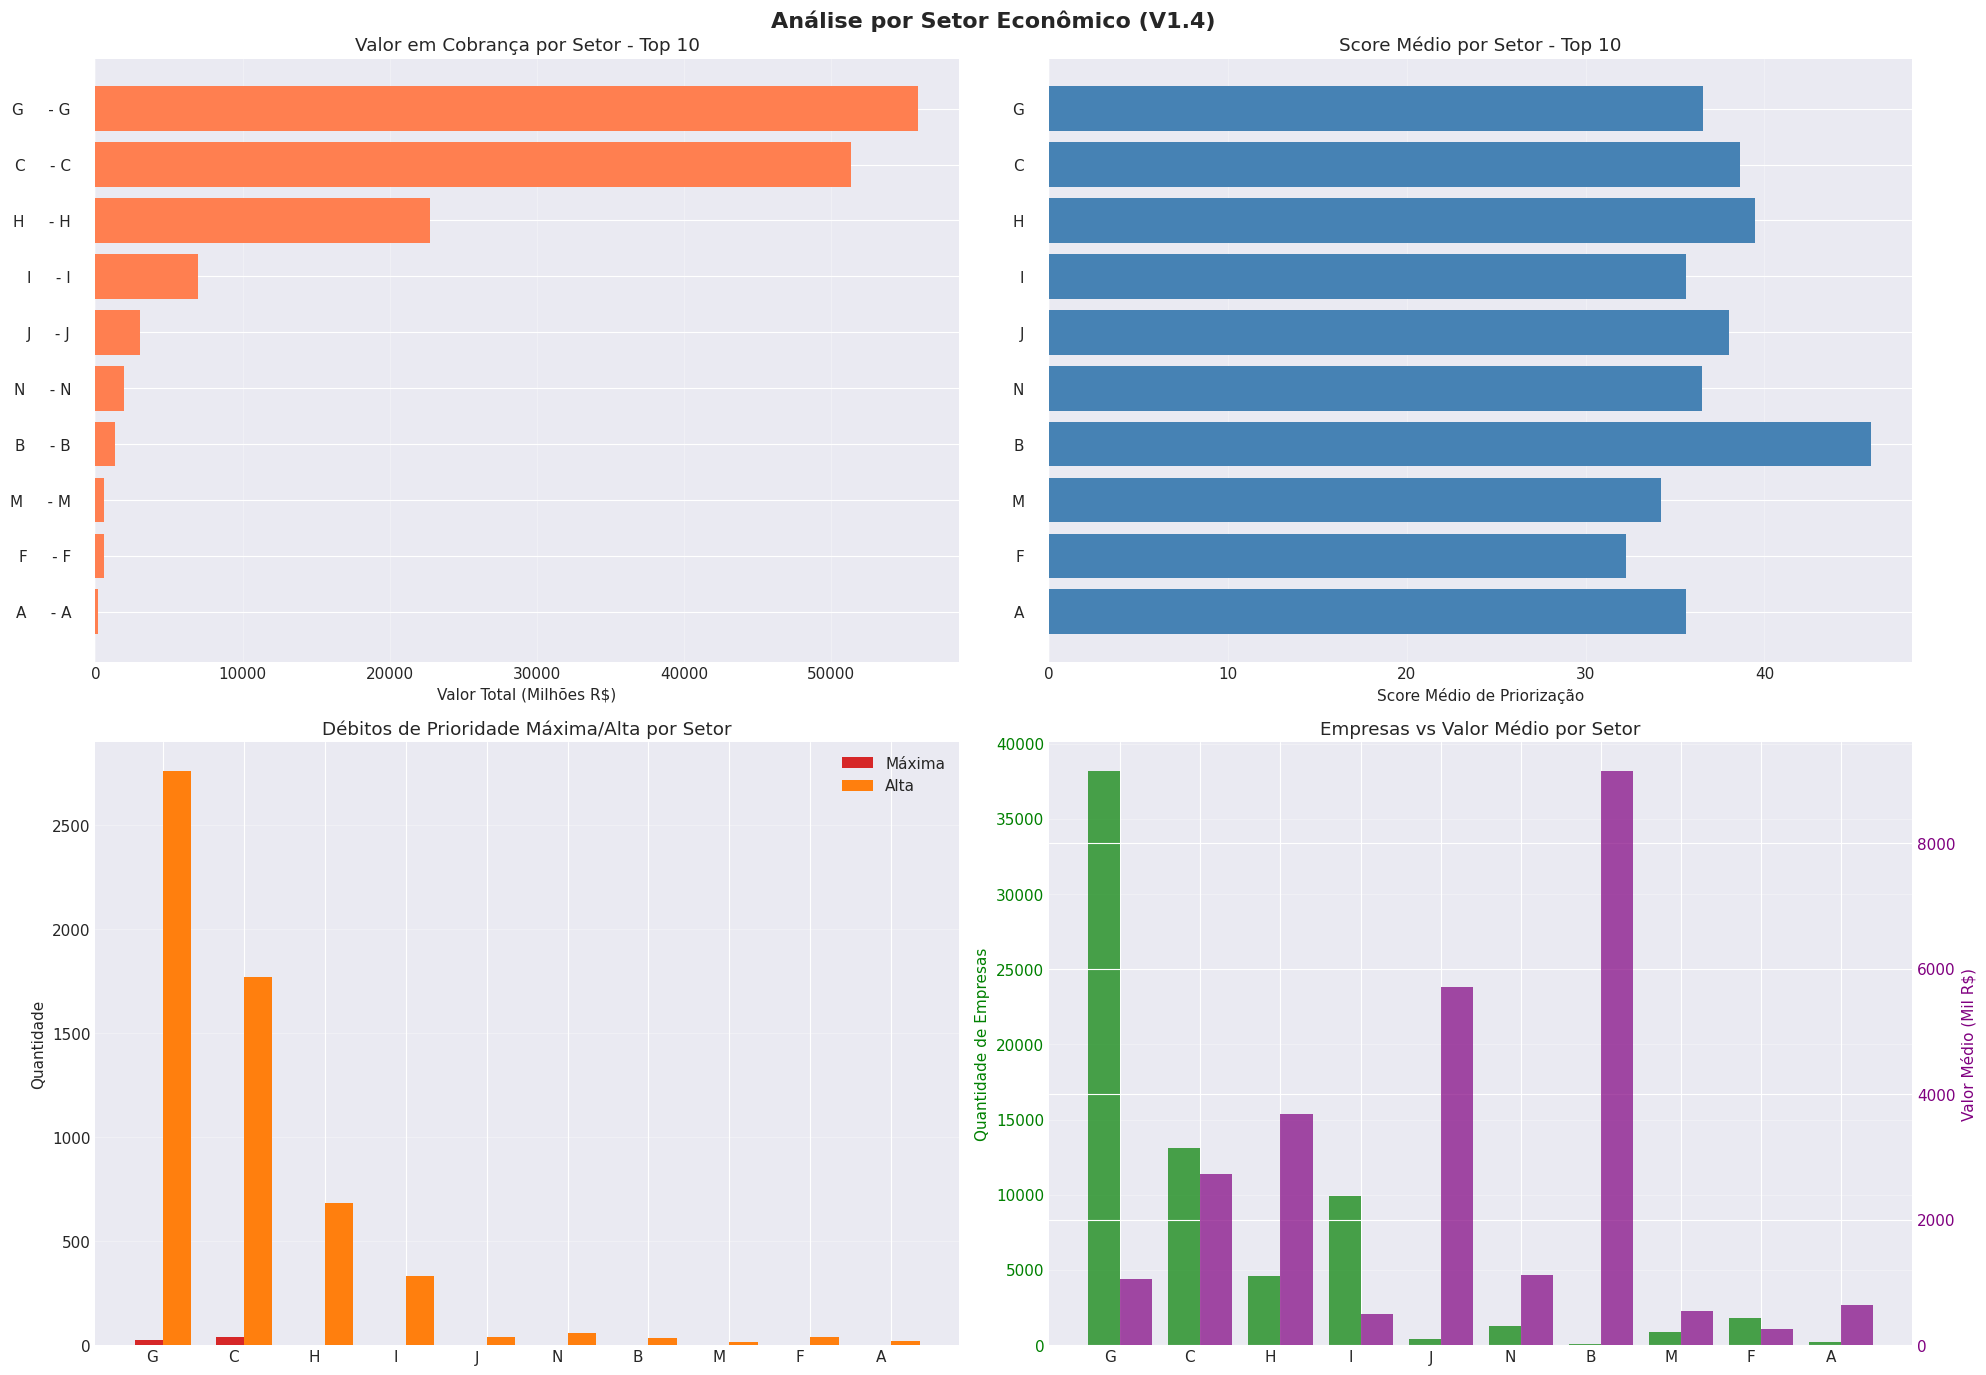

In [12]:
# ============================================================================
# CÉLULA 7: ANÁLISE POR SETOR ECONÔMICO (ATUALIZADA V1.4)
# ============================================================================
print("\n" + "=" * 80)
print("4. ANÁLISE POR SETOR ECONÔMICO")
print("=" * 80)

query_setores = """
WITH dados_unicos AS (
    SELECT DISTINCT
        fm.inscricao_estadual,
        fm.secao_cnae,
        fm.cnae_divisao,
        fm.tipo_debito,
        sp.valor_total_devido,
        sp.score_final_priorizacao,
        sp.classificacao_prioridade,
        fm.taxa_efetividade_contatos,
        fm.qtd_total_contatos,
        fm.score_noteiras,
        fm.flag_falencia
    FROM gecob.prior_features_ml fm
    INNER JOIN gecob.prior_score_priorizacao sp 
        ON fm.inscricao_estadual = sp.inscricao_estadual
        AND fm.tipo_debito = sp.tipo_debito
    WHERE fm.secao_cnae IS NOT NULL
)
SELECT 
    secao_cnae,
    CASE 
        WHEN secao_cnae = 'A' THEN 'AGRICULTURA, PECUÁRIA'
        WHEN secao_cnae = 'B' THEN 'INDÚSTRIAS EXTRATIVAS'
        WHEN secao_cnae = 'C' THEN 'INDÚSTRIAS DE TRANSFORMAÇÃO'
        WHEN secao_cnae = 'D' THEN 'ELETRICIDADE E GÁS'
        WHEN secao_cnae = 'E' THEN 'ÁGUA, ESGOTO, RESÍDUOS'
        WHEN secao_cnae = 'F' THEN 'CONSTRUÇÃO'
        WHEN secao_cnae = 'G' THEN 'COMÉRCIO'
        WHEN secao_cnae = 'H' THEN 'TRANSPORTE, ARMAZENAGEM'
        WHEN secao_cnae = 'I' THEN 'ALOJAMENTO E ALIMENTAÇÃO'
        WHEN secao_cnae = 'J' THEN 'INFORMAÇÃO E COMUNICAÇÃO'
        WHEN secao_cnae = 'K' THEN 'ATIVIDADES FINANCEIRAS'
        WHEN secao_cnae = 'L' THEN 'ATIVIDADES IMOBILIÁRIAS'
        WHEN secao_cnae = 'M' THEN 'ATIVIDADES PROFISSIONAIS'
        WHEN secao_cnae = 'N' THEN 'ATIVIDADES ADMINISTRATIVAS'
        WHEN secao_cnae = 'O' THEN 'ADMINISTRAÇÃO PÚBLICA'
        WHEN secao_cnae = 'P' THEN 'EDUCAÇÃO'
        WHEN secao_cnae = 'Q' THEN 'SAÚDE HUMANA'
        WHEN secao_cnae = 'R' THEN 'ARTES, CULTURA, ESPORTE'
        WHEN secao_cnae = 'S' THEN 'OUTRAS ATIVIDADES'
        ELSE secao_cnae
    END AS descricao_secao,
    
    COUNT(DISTINCT inscricao_estadual) AS qtd_empresas,
    COUNT(*) AS qtd_debitos,
    SUM(valor_total_devido) AS valor_total,
    AVG(valor_total_devido) AS valor_medio,
    AVG(score_final_priorizacao) AS score_medio,
    
    SUM(CASE WHEN classificacao_prioridade = 'PRIORIDADE_MAXIMA' THEN 1 ELSE 0 END) AS qtd_max,
    SUM(CASE WHEN classificacao_prioridade = 'PRIORIDADE_ALTA' THEN 1 ELSE 0 END) AS qtd_alta,
    
    AVG(taxa_efetividade_contatos) AS media_taxa_resposta,
    AVG(qtd_total_contatos) AS media_contatos,
    AVG(score_noteiras) AS media_score_noteiras,
    SUM(CASE WHEN flag_falencia = 1 THEN 1 ELSE 0 END) AS qtd_falencia

FROM dados_unicos
GROUP BY secao_cnae
HAVING COUNT(DISTINCT inscricao_estadual) >= 100
ORDER BY valor_total DESC
LIMIT 20
"""

df_setores = spark.sql(query_setores).toPandas()

if len(df_setores) == 0:
    print("\n⚠️  AVISO: Nenhum setor encontrado!")
else:
    # Converter dados
    for col in df_setores.columns:
        if col in ['secao_cnae', 'descricao_secao']:
            df_setores[col] = df_setores[col].astype(str).fillna('NÃO INFORMADO')
        else:
            df_setores[col] = pd.to_numeric(df_setores[col], errors='coerce').fillna(0)

    print(f"\nTOP {len(df_setores)} SETORES POR VALOR EM COBRANÇA:\n")
    for idx, row in df_setores.head(15).iterrows():
        print(f"{idx+1:2d}. Seção {row['secao_cnae']}: {row['descricao_secao']}")
        print(f"    Empresas: {int(row['qtd_empresas']):,} | Débitos: {int(row['qtd_debitos']):,}")
        print(f"    Valor Total: R$ {float(row['valor_total']):,.2f}")
        print(f"    Valor Médio: R$ {float(row['valor_medio']):,.2f}")
        print(f"    Score Médio: {float(row['score_medio']):.2f}")
        print(f"    Prioridade Máxima/Alta: {int(row['qtd_max']):,} / {int(row['qtd_alta']):,}")
        print()

    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Análise por Setor Econômico (V1.4)', fontsize=16, fontweight='bold')

    top10_setores = df_setores.head(10).copy()

    # 1. Valor por Setor
    axes[0, 0].barh(range(len(top10_setores)), top10_setores['valor_total']/1e6, color='coral')
    axes[0, 0].set_yticks(range(len(top10_setores)))
    axes[0, 0].set_yticklabels([f"{row['secao_cnae']} - {row['descricao_secao'][:25]}" 
                                for _, row in top10_setores.iterrows()])
    axes[0, 0].set_xlabel('Valor Total (Milhões R$)')
    axes[0, 0].set_title('Valor em Cobrança por Setor - Top 10')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # 2. Score Médio por Setor
    axes[0, 1].barh(range(len(top10_setores)), top10_setores['score_medio'], color='steelblue')
    axes[0, 1].set_yticks(range(len(top10_setores)))
    axes[0, 1].set_yticklabels([f"{row['secao_cnae']}" for _, row in top10_setores.iterrows()])
    axes[0, 1].set_xlabel('Score Médio de Priorização')
    axes[0, 1].set_title('Score Médio por Setor - Top 10')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # 3. Distribuição Prioridade Alta por Setor
    x = np.arange(len(top10_setores))
    width = 0.35
    axes[1, 0].bar(x - width/2, top10_setores['qtd_max'], width, label='Máxima', color='#d62728')
    axes[1, 0].bar(x + width/2, top10_setores['qtd_alta'], width, label='Alta', color='#ff7f0e')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([row['secao_cnae'] for _, row in top10_setores.iterrows()])
    axes[1, 0].set_ylabel('Quantidade')
    axes[1, 0].set_title('Débitos de Prioridade Máxima/Alta por Setor')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 4. Empresas e Valor Médio
    ax4_1 = axes[1, 1]
    ax4_2 = ax4_1.twinx()
    
    x = np.arange(len(top10_setores))
    ax4_1.bar(x - 0.2, top10_setores['qtd_empresas'], 0.4, label='Empresas', color='green', alpha=0.7)
    ax4_2.bar(x + 0.2, top10_setores['valor_medio']/1000, 0.4, label='Valor Médio (Mil R$)', color='purple', alpha=0.7)
    
    ax4_1.set_xticks(x)
    ax4_1.set_xticklabels([row['secao_cnae'] for _, row in top10_setores.iterrows()])
    ax4_1.set_ylabel('Quantidade de Empresas', color='green')
    ax4_2.set_ylabel('Valor Médio (Mil R$)', color='purple')
    ax4_1.set_title('Empresas vs Valor Médio por Setor')
    ax4_1.tick_params(axis='y', labelcolor='green')
    ax4_2.tick_params(axis='y', labelcolor='purple')
    ax4_1.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)


4. ANÁLISE POR SETOR ECONÔMICO



TOP 15 SETORES POR VALOR EM COBRANÇA:

 1. Seção G    : G    
    Empresas: 38,188 | Débitos: 52,819
    Valor Total: R$ 55,877,618,003.89
    Valor Médio: R$ 1,057,907.53
    Score Médio: 36.55
    Prioridade Máxima/Alta: 25 / 2,760

 2. Seção C    : C    
    Empresas: 13,107 | Débitos: 18,873
    Valor Total: R$ 51,369,275,381.98
    Valor Médio: R$ 2,721,839.42
    Score Médio: 38.62
    Prioridade Máxima/Alta: 37 / 1,769

 3. Seção H    : H    
    Empresas: 4,606 | Débitos: 6,163
    Valor Total: R$ 22,733,469,249.40
    Valor Médio: R$ 3,688,701.81
    Score Médio: 39.45
    Prioridade Máxima/Alta: 0 / 684

 4. Seção I    : I    
    Empresas: 9,930 | Débitos: 14,202
    Valor Total: R$ 6,986,877,623.56
    Valor Médio: R$ 491,964.34
    Score Médio: 35.63
    Prioridade Máxima/Alta: 0 / 334

 5. Seção J    : J    
    Empresas: 401 | Débitos: 527
    Valor Total: R$ 3,004,816,853.26
    Valor Médio: R$ 5,701,739.76
    Score Médio: 37.99
    Prioridade Máxima/Alta: 3 / 38

 6.

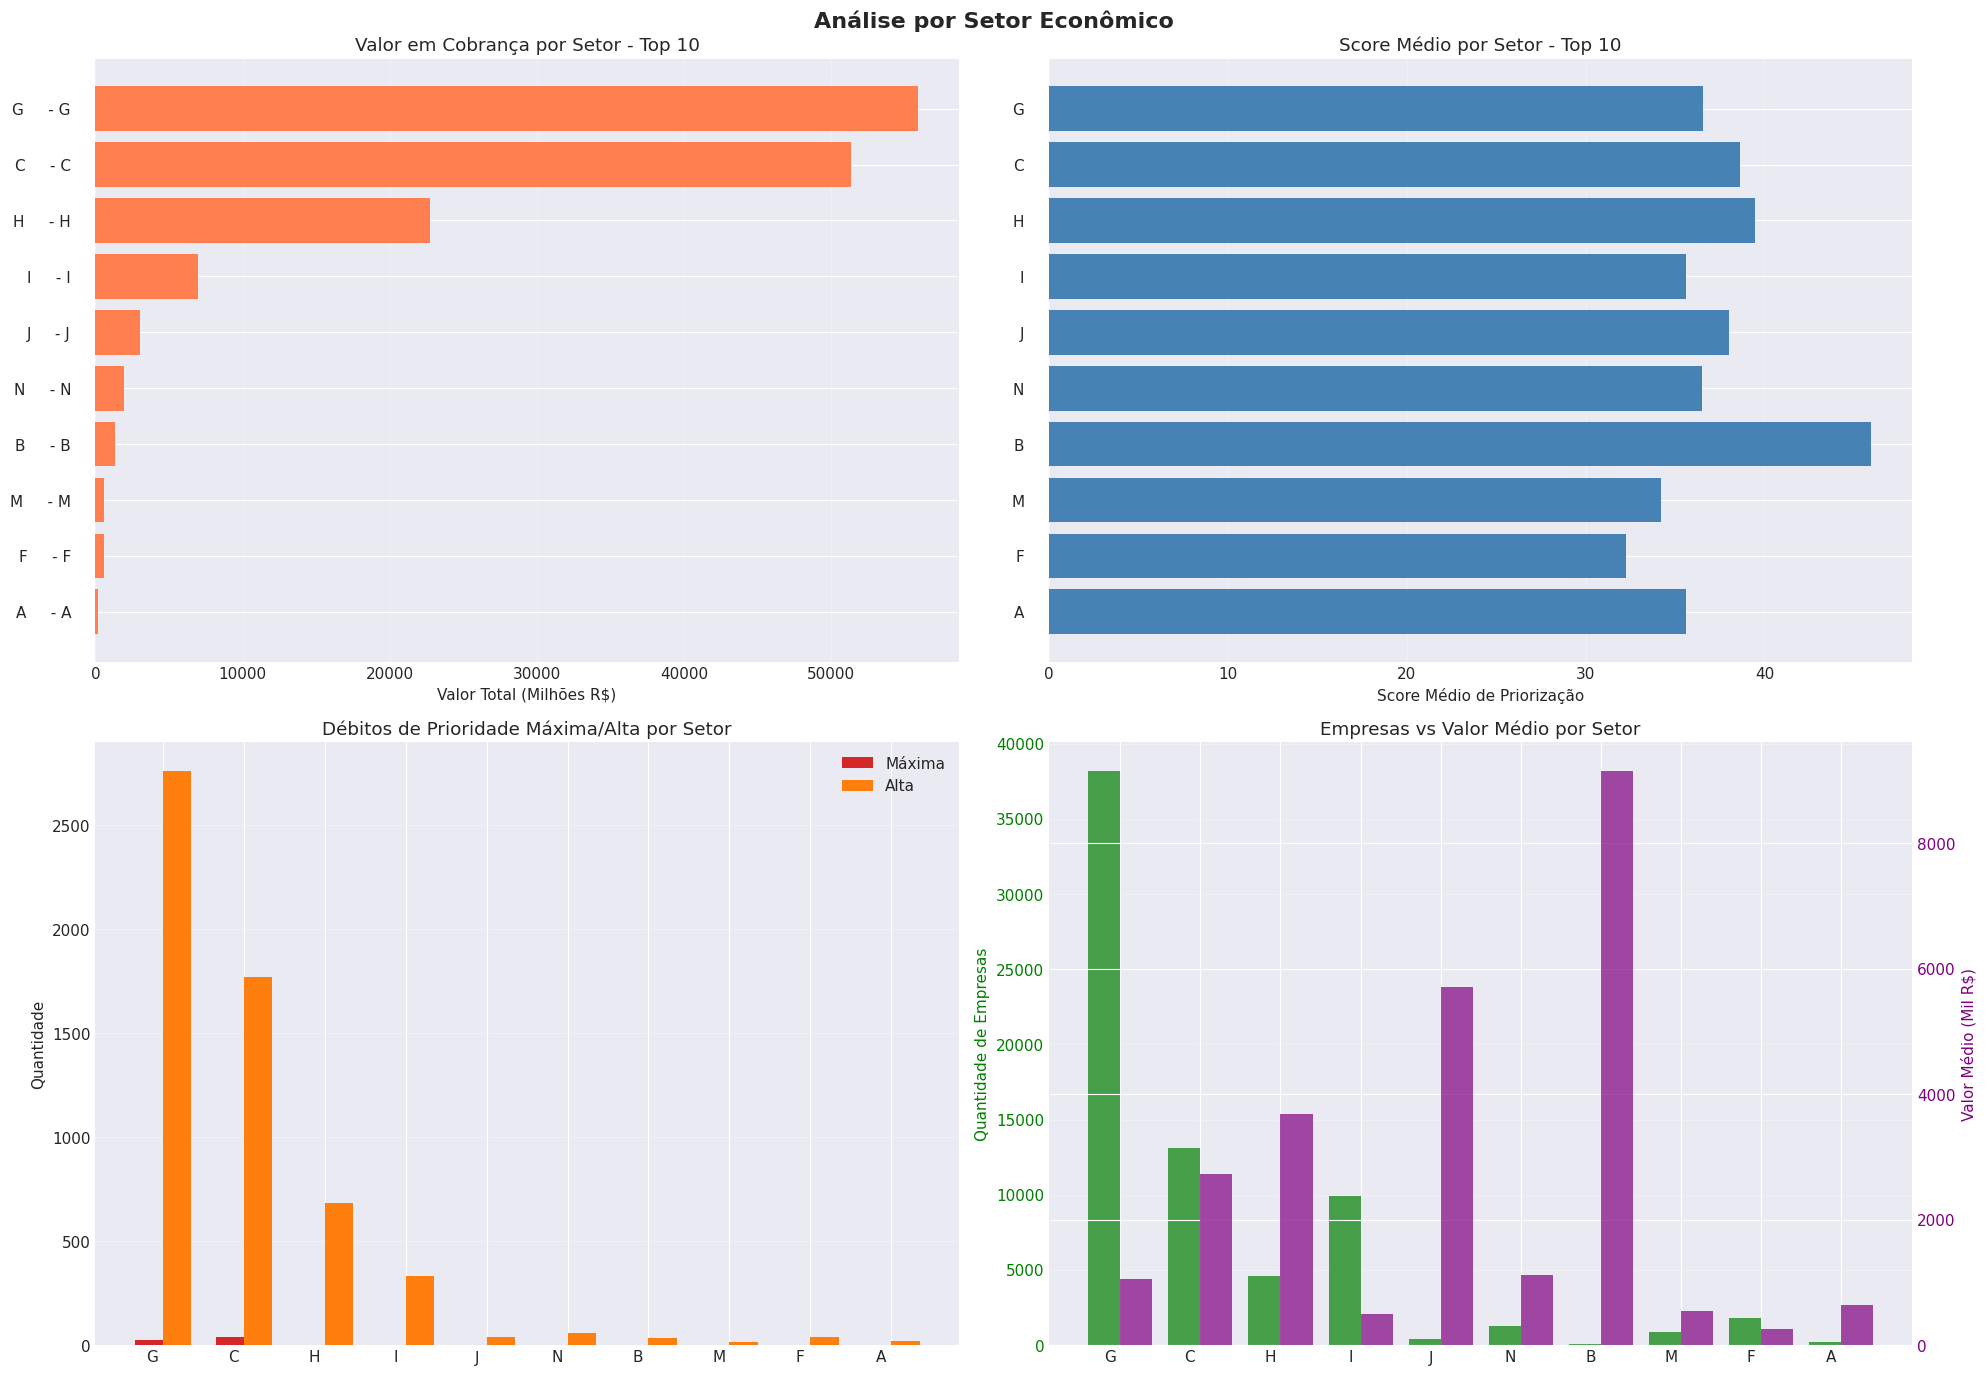

In [13]:
# ============================================================================
# CÉLULA 7 FINAL: ANÁLISE POR SETOR ECONÔMICO
# ============================================================================
print("\n" + "=" * 80)
print("4. ANÁLISE POR SETOR ECONÔMICO")
print("=" * 80)

query_setores = """
WITH dados_unicos AS (
    SELECT DISTINCT
        fm.inscricao_estadual,
        fm.secao_cnae,
        fm.cnae_divisao,
        fm.tipo_debito,
        sp.valor_total_devido,
        sp.score_final_priorizacao,
        sp.classificacao_prioridade,
        fm.taxa_efetividade_contatos,
        fm.qtd_total_contatos,
        fm.score_noteiras,
        fm.flag_falencia
    FROM gecob.prior_features_ml fm
    INNER JOIN gecob.prior_score_priorizacao sp 
        ON fm.inscricao_estadual = sp.inscricao_estadual
        AND fm.tipo_debito = sp.tipo_debito
    WHERE fm.secao_cnae IS NOT NULL
)
SELECT 
    secao_cnae,
    CASE 
        WHEN secao_cnae = 'A' THEN 'AGRICULTURA, PECUÁRIA'
        WHEN secao_cnae = 'B' THEN 'INDÚSTRIAS EXTRATIVAS'
        WHEN secao_cnae = 'C' THEN 'INDÚSTRIAS DE TRANSFORMAÇÃO'
        WHEN secao_cnae = 'D' THEN 'ELETRICIDADE E GÁS'
        WHEN secao_cnae = 'E' THEN 'ÁGUA, ESGOTO, RESÍDUOS'
        WHEN secao_cnae = 'F' THEN 'CONSTRUÇÃO'
        WHEN secao_cnae = 'G' THEN 'COMÉRCIO'
        WHEN secao_cnae = 'H' THEN 'TRANSPORTE, ARMAZENAGEM'
        WHEN secao_cnae = 'I' THEN 'ALOJAMENTO E ALIMENTAÇÃO'
        WHEN secao_cnae = 'J' THEN 'INFORMAÇÃO E COMUNICAÇÃO'
        WHEN secao_cnae = 'K' THEN 'ATIVIDADES FINANCEIRAS'
        WHEN secao_cnae = 'L' THEN 'ATIVIDADES IMOBILIÁRIAS'
        WHEN secao_cnae = 'M' THEN 'ATIVIDADES PROFISSIONAIS'
        WHEN secao_cnae = 'N' THEN 'ATIVIDADES ADMINISTRATIVAS'
        WHEN secao_cnae = 'O' THEN 'ADMINISTRAÇÃO PÚBLICA'
        WHEN secao_cnae = 'P' THEN 'EDUCAÇÃO'
        WHEN secao_cnae = 'Q' THEN 'SAÚDE HUMANA'
        WHEN secao_cnae = 'R' THEN 'ARTES, CULTURA, ESPORTE'
        WHEN secao_cnae = 'S' THEN 'OUTRAS ATIVIDADES'
        ELSE secao_cnae
    END AS descricao_secao,
    
    COUNT(DISTINCT inscricao_estadual) AS qtd_empresas,
    COUNT(*) AS qtd_debitos,
    SUM(valor_total_devido) AS valor_total,
    AVG(valor_total_devido) AS valor_medio,
    AVG(score_final_priorizacao) AS score_medio,
    
    SUM(CASE WHEN classificacao_prioridade = 'PRIORIDADE_MAXIMA' THEN 1 ELSE 0 END) AS qtd_max,
    SUM(CASE WHEN classificacao_prioridade = 'PRIORIDADE_ALTA' THEN 1 ELSE 0 END) AS qtd_alta,
    
    AVG(taxa_efetividade_contatos) AS media_taxa_resposta,
    AVG(qtd_total_contatos) AS media_contatos,
    AVG(score_noteiras) AS media_score_noteiras,
    SUM(CASE WHEN flag_falencia = 1 THEN 1 ELSE 0 END) AS qtd_falencia

FROM dados_unicos
GROUP BY secao_cnae
HAVING COUNT(DISTINCT inscricao_estadual) >= 100
ORDER BY valor_total DESC
LIMIT 20
"""

df_setores = spark.sql(query_setores).toPandas()

if len(df_setores) == 0:
    print("\n⚠️  AVISO: Nenhum setor encontrado!")
else:
    # Converter dados
    for col in df_setores.columns:
        if col in ['secao_cnae', 'descricao_secao']:
            df_setores[col] = df_setores[col].astype(str).fillna('NÃO INFORMADO')
        else:
            df_setores[col] = pd.to_numeric(df_setores[col], errors='coerce').fillna(0)

    print(f"\nTOP {len(df_setores)} SETORES POR VALOR EM COBRANÇA:\n")
    for idx, row in df_setores.head(15).iterrows():
        print(f"{idx+1:2d}. Seção {row['secao_cnae']}: {row['descricao_secao']}")
        print(f"    Empresas: {int(row['qtd_empresas']):,} | Débitos: {int(row['qtd_debitos']):,}")
        print(f"    Valor Total: R$ {float(row['valor_total']):,.2f}")
        print(f"    Valor Médio: R$ {float(row['valor_medio']):,.2f}")
        print(f"    Score Médio: {float(row['score_medio']):.2f}")
        print(f"    Prioridade Máxima/Alta: {int(row['qtd_max']):,} / {int(row['qtd_alta']):,}")
        print()

    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    fig.suptitle('Análise por Setor Econômico', fontsize=16, fontweight='bold')

    top10_setores = df_setores.head(10).copy()

    # 1. Valor por Setor
    axes[0, 0].barh(range(len(top10_setores)), top10_setores['valor_total']/1e6, color='coral')
    axes[0, 0].set_yticks(range(len(top10_setores)))
    axes[0, 0].set_yticklabels([f"{row['secao_cnae']} - {row['descricao_secao'][:25]}" 
                                for _, row in top10_setores.iterrows()])
    axes[0, 0].set_xlabel('Valor Total (Milhões R$)')
    axes[0, 0].set_title('Valor em Cobrança por Setor - Top 10')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # 2. Score Médio por Setor
    axes[0, 1].barh(range(len(top10_setores)), top10_setores['score_medio'], color='steelblue')
    axes[0, 1].set_yticks(range(len(top10_setores)))
    axes[0, 1].set_yticklabels([f"{row['secao_cnae']}" for _, row in top10_setores.iterrows()])
    axes[0, 1].set_xlabel('Score Médio de Priorização')
    axes[0, 1].set_title('Score Médio por Setor - Top 10')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # 3. Distribuição Prioridade Alta por Setor
    x = np.arange(len(top10_setores))
    width = 0.35
    axes[1, 0].bar(x - width/2, top10_setores['qtd_max'], width, label='Máxima', color='#d62728')
    axes[1, 0].bar(x + width/2, top10_setores['qtd_alta'], width, label='Alta', color='#ff7f0e')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([row['secao_cnae'] for _, row in top10_setores.iterrows()])
    axes[1, 0].set_ylabel('Quantidade')
    axes[1, 0].set_title('Débitos de Prioridade Máxima/Alta por Setor')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 4. Empresas e Valor Médio
    ax4_1 = axes[1, 1]
    ax4_2 = ax4_1.twinx()
    
    x = np.arange(len(top10_setores))
    ax4_1.bar(x - 0.2, top10_setores['qtd_empresas'], 0.4, label='Empresas', color='green', alpha=0.7)
    ax4_2.bar(x + 0.2, top10_setores['valor_medio']/1000, 0.4, label='Valor Médio (Mil R$)', color='purple', alpha=0.7)
    
    ax4_1.set_xticks(x)
    ax4_1.set_xticklabels([row['secao_cnae'] for _, row in top10_setores.iterrows()])
    ax4_1.set_ylabel('Quantidade de Empresas', color='green')
    ax4_2.set_ylabel('Valor Médio (Mil R$)', color='purple')
    ax4_1.set_title('Empresas vs Valor Médio por Setor')
    ax4_1.tick_params(axis='y', labelcolor='green')
    ax4_2.tick_params(axis='y', labelcolor='purple')
    ax4_1.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)


5. ANÁLISE POR MUNICÍPIO

TOP 20 MUNICÍPIOS POR VALOR EM COBRANÇA:

 1. Município: 81795 - SC
    Empresas: 5,979 | Débitos: 8,716
    Valor Total: R$ 14,814,933,290.92
    Valor Médio: R$ 1,699,739.94
    Score Médio: 37.56
    Prioridade Alta: 550

 2. Município: 80578 - SC
    Empresas: 457 | Débitos: 626
    Valor Total: R$ 9,904,878,698.94
    Valor Médio: R$ 15,822,489.93
    Score Médio: 37.57
    Prioridade Alta: 37

 3. Município: 81612 - SC
    Empresas: 4,209 | Débitos: 5,800
    Valor Total: R$ 9,839,471,403.17
    Valor Médio: R$ 1,696,460.59
    Score Médio: 38.38
    Prioridade Alta: 417

 4. Município: 80470 - SC
    Empresas: 4,131 | Débitos: 5,732
    Valor Total: R$ 8,873,471,894.55
    Valor Médio: R$ 1,548,058.60
    Score Médio: 37.40
    Prioridade Alta: 368

 5. Município: 81051 - SC
    Empresas: 5,413 | Débitos: 7,546
    Valor Total: R$ 7,852,254,271.31
    Valor Médio: R$ 1,040,584.98
    Score Médio: 36.38
    Prioridade Alta: 369

 6. Município: 80810 - S

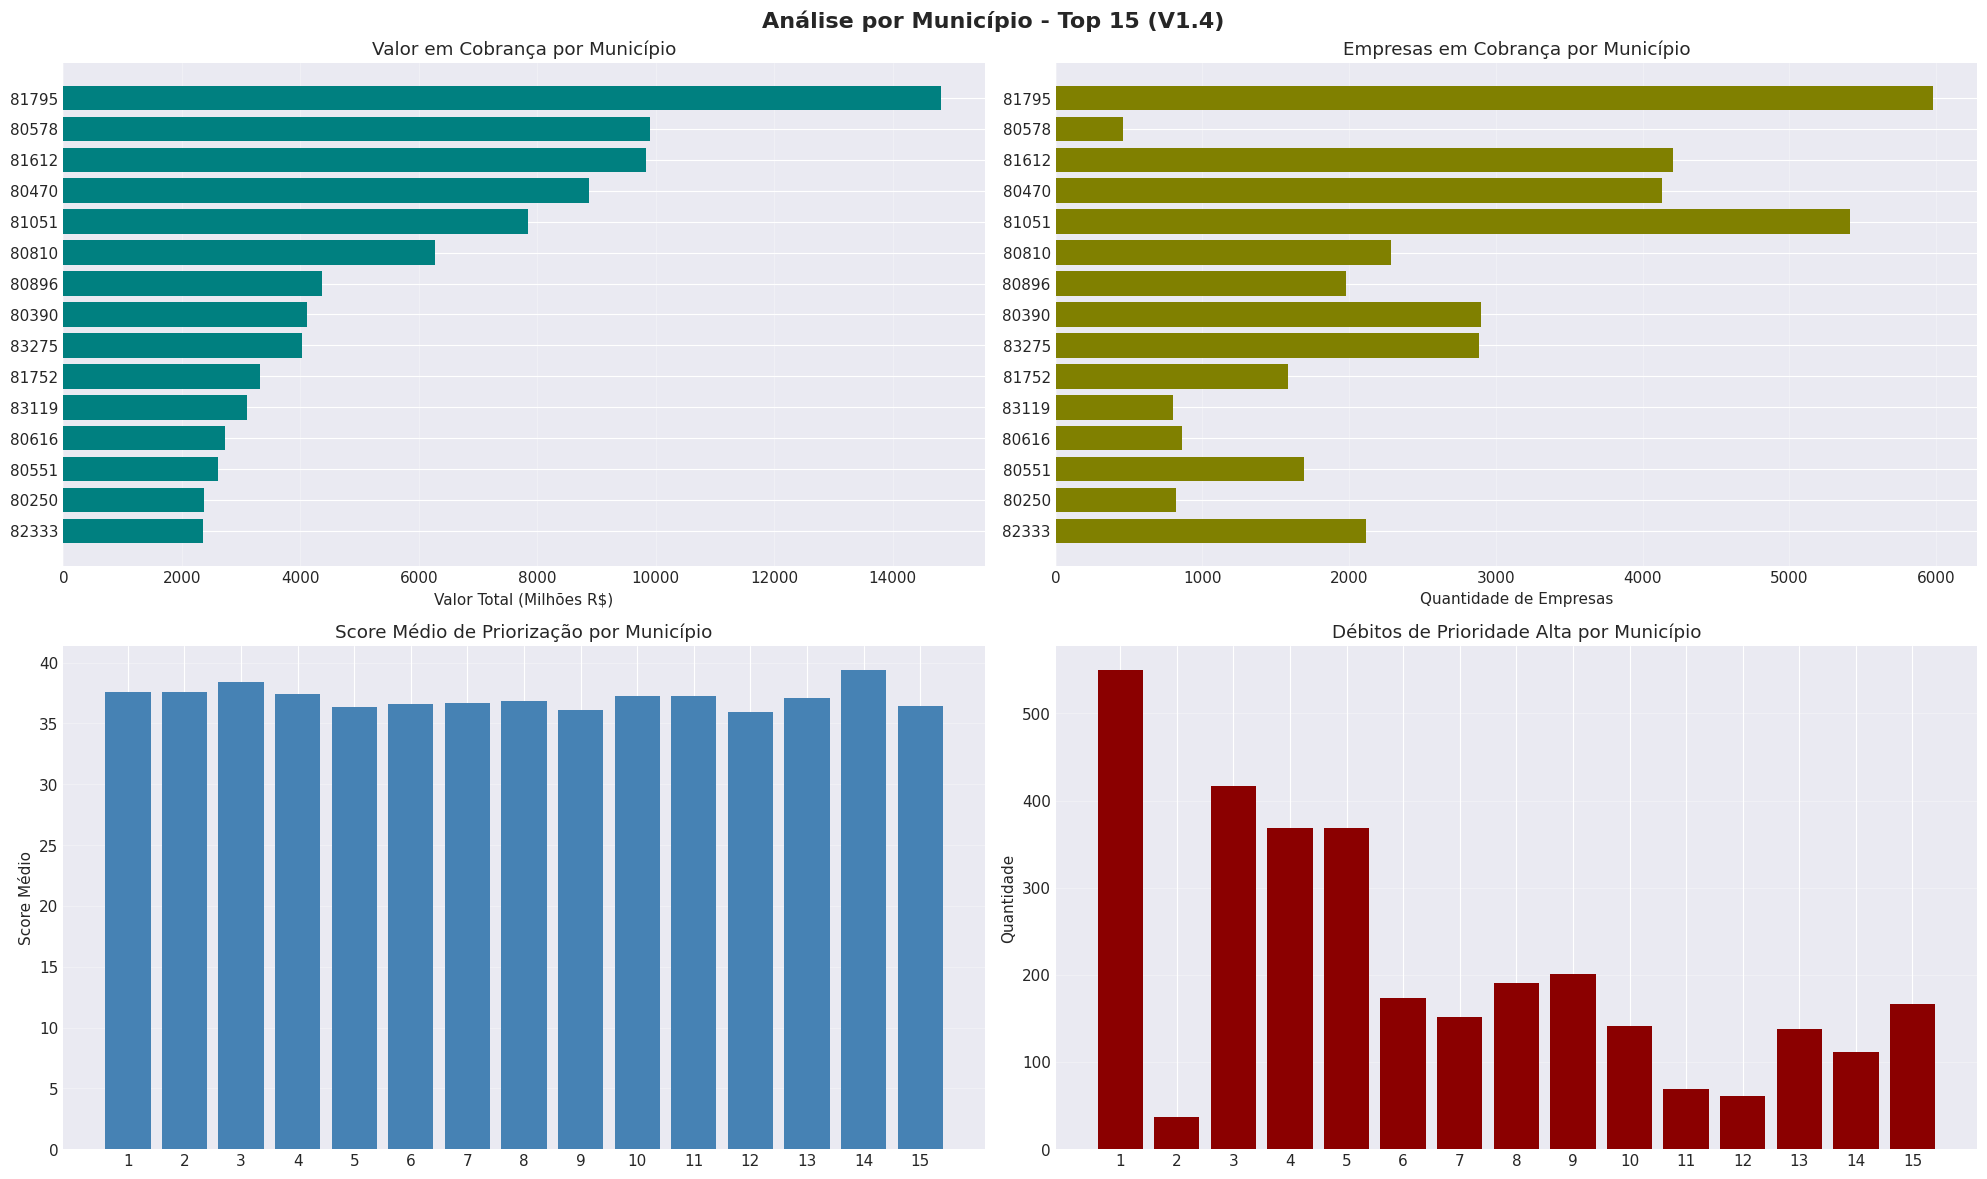

In [22]:
# ============================================================================
# ANÁLISE POR MUNICÍPIO (CORRIGIDA - SEM CONFLITOS)
# ============================================================================
print("\n" + "=" * 80)
print("5. ANÁLISE POR MUNICÍPIO")
print("=" * 80)

# IMPORTANTE: Importar builtins
import builtins

query_municipios = """
WITH dados_unicos AS (
    SELECT DISTINCT
        fm.inscricao_estadual,
        fm.codigo_municipio,
        fm.codigo_uf,
        fm.tipo_debito,
        sp.valor_total_devido,
        sp.score_final_priorizacao,
        sp.classificacao_prioridade,
        fm.taxa_efetividade_contatos,
        fm.flag_falencia,
        fm.flag_devedor_contumaz
    FROM gecob.prior_features_ml fm
    INNER JOIN gecob.prior_score_priorizacao sp 
        ON fm.inscricao_estadual = sp.inscricao_estadual
        AND fm.tipo_debito = sp.tipo_debito
    WHERE fm.codigo_municipio IS NOT NULL
)
SELECT 
    codigo_municipio,
    codigo_uf AS uf,
    COUNT(DISTINCT inscricao_estadual) AS qtd_empresas,
    COUNT(*) AS qtd_debitos,
    SUM(valor_total_devido) AS valor_total,
    AVG(valor_total_devido) AS valor_medio,
    AVG(score_final_priorizacao) AS score_medio,
    
    SUM(CASE WHEN classificacao_prioridade IN ('PRIORIDADE_MAXIMA', 'PRIORIDADE_ALTA') THEN 1 ELSE 0 END) AS qtd_prioridade_alta,
    AVG(taxa_efetividade_contatos) AS media_taxa_resposta,
    SUM(CASE WHEN flag_falencia = 1 THEN 1 ELSE 0 END) AS qtd_falencia,
    SUM(CASE WHEN flag_devedor_contumaz = 1 THEN 1 ELSE 0 END) AS qtd_contumaz

FROM dados_unicos
GROUP BY codigo_municipio, codigo_uf
HAVING COUNT(DISTINCT inscricao_estadual) >= 50
ORDER BY valor_total DESC
LIMIT 30
"""

df_municipios = spark.sql(query_municipios).toPandas()

if len(df_municipios) == 0:
    print("\n⚠️  AVISO: Nenhum município encontrado!")
else:
    # Converter dados
    for col in df_municipios.columns:
        if col in ['uf']:
            df_municipios[col] = df_municipios[col].astype(str).fillna('SC')
        else:
            df_municipios[col] = pd.to_numeric(df_municipios[col], errors='coerce').fillna(0)

    # CORRIGIDO: Usar builtins.min
    print(f"\nTOP {builtins.min(20, len(df_municipios))} MUNICÍPIOS POR VALOR EM COBRANÇA:\n")
    for idx, row in df_municipios.head(20).iterrows():
        print(f"{idx+1:2d}. Município: {int(row['codigo_municipio'])} - {row['uf']}")
        print(f"    Empresas: {int(row['qtd_empresas']):,} | Débitos: {int(row['qtd_debitos']):,}")
        print(f"    Valor Total: R$ {float(row['valor_total']):,.2f}")
        print(f"    Valor Médio: R$ {float(row['valor_medio']):,.2f}")
        print(f"    Score Médio: {float(row['score_medio']):.2f}")
        print(f"    Prioridade Alta: {int(row['qtd_prioridade_alta']):,}")
        print()

    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    fig.suptitle('Análise por Município - Top 15 (V1.4)', fontsize=16, fontweight='bold')

    top15 = df_municipios.head(15).copy()
    top15['municipio_label'] = top15['codigo_municipio'].astype(int).astype(str)

    # 1. Valor por Município
    axes[0, 0].barh(range(len(top15)), top15['valor_total']/1e6, color='teal')
    axes[0, 0].set_yticks(range(len(top15)))
    axes[0, 0].set_yticklabels(top15['municipio_label'])
    axes[0, 0].set_xlabel('Valor Total (Milhões R$)')
    axes[0, 0].set_title('Valor em Cobrança por Município')
    axes[0, 0].invert_yaxis()
    axes[0, 0].grid(True, alpha=0.3, axis='x')

    # 2. Quantidade de Empresas
    axes[0, 1].barh(range(len(top15)), top15['qtd_empresas'], color='olive')
    axes[0, 1].set_yticks(range(len(top15)))
    axes[0, 1].set_yticklabels(top15['municipio_label'])
    axes[0, 1].set_xlabel('Quantidade de Empresas')
    axes[0, 1].set_title('Empresas em Cobrança por Município')
    axes[0, 1].invert_yaxis()
    axes[0, 1].grid(True, alpha=0.3, axis='x')

    # 3. Score Médio
    axes[1, 0].bar(range(len(top15)), top15['score_medio'], color='steelblue')
    axes[1, 0].set_xticks(range(len(top15)))
    axes[1, 0].set_xticklabels(range(1, len(top15)+1))
    axes[1, 0].set_ylabel('Score Médio')
    axes[1, 0].set_title('Score Médio de Priorização por Município')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # 4. Prioridades Altas
    axes[1, 1].bar(range(len(top15)), top15['qtd_prioridade_alta'], color='darkred')
    axes[1, 1].set_xticks(range(len(top15)))
    axes[1, 1].set_xticklabels(range(1, len(top15)+1))
    axes[1, 1].set_ylabel('Quantidade')
    axes[1, 1].set_title('Débitos de Prioridade Alta por Município')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

print("\n" + "=" * 80)


6. ANÁLISE DE CORRELAÇÕES E ESTATÍSTICAS

Verificando colunas disponíveis em prior_features_ml...
Total de colunas: 111
Features encontradas: 18 de 18

✓ Dados carregados: 5,000 registros com 18 features

TOP 10 CORRELAÇÕES MAIS FORTES:

 1. score_compliance               ↔ score_atividade_recente       : +0.874
 2. score_atividade_recente        ↔ score_compliance              : +0.874
 3. coef_variacao_pagamentos       ↔ qtd_periodos_pagamento_6m     : +0.725
 4. qtd_periodos_pagamento_6m      ↔ coef_variacao_pagamentos      : +0.725
 5. score_atividade_recente        ↔ taxa_divergencia_devido_recolh: +0.694
 6. taxa_divergencia_devido_recolh ↔ score_atividade_recente       : +0.694
 7. score_noteiras                 ↔ score_atividade_recente       : +0.643
 8. score_atividade_recente        ↔ score_noteiras                : +0.643
 9. qtd_periodos_pagamento_6m      ↔ score_compliance              : +0.623
10. score_compliance               ↔ qtd_periodos_pagamento_6m     : +0.623


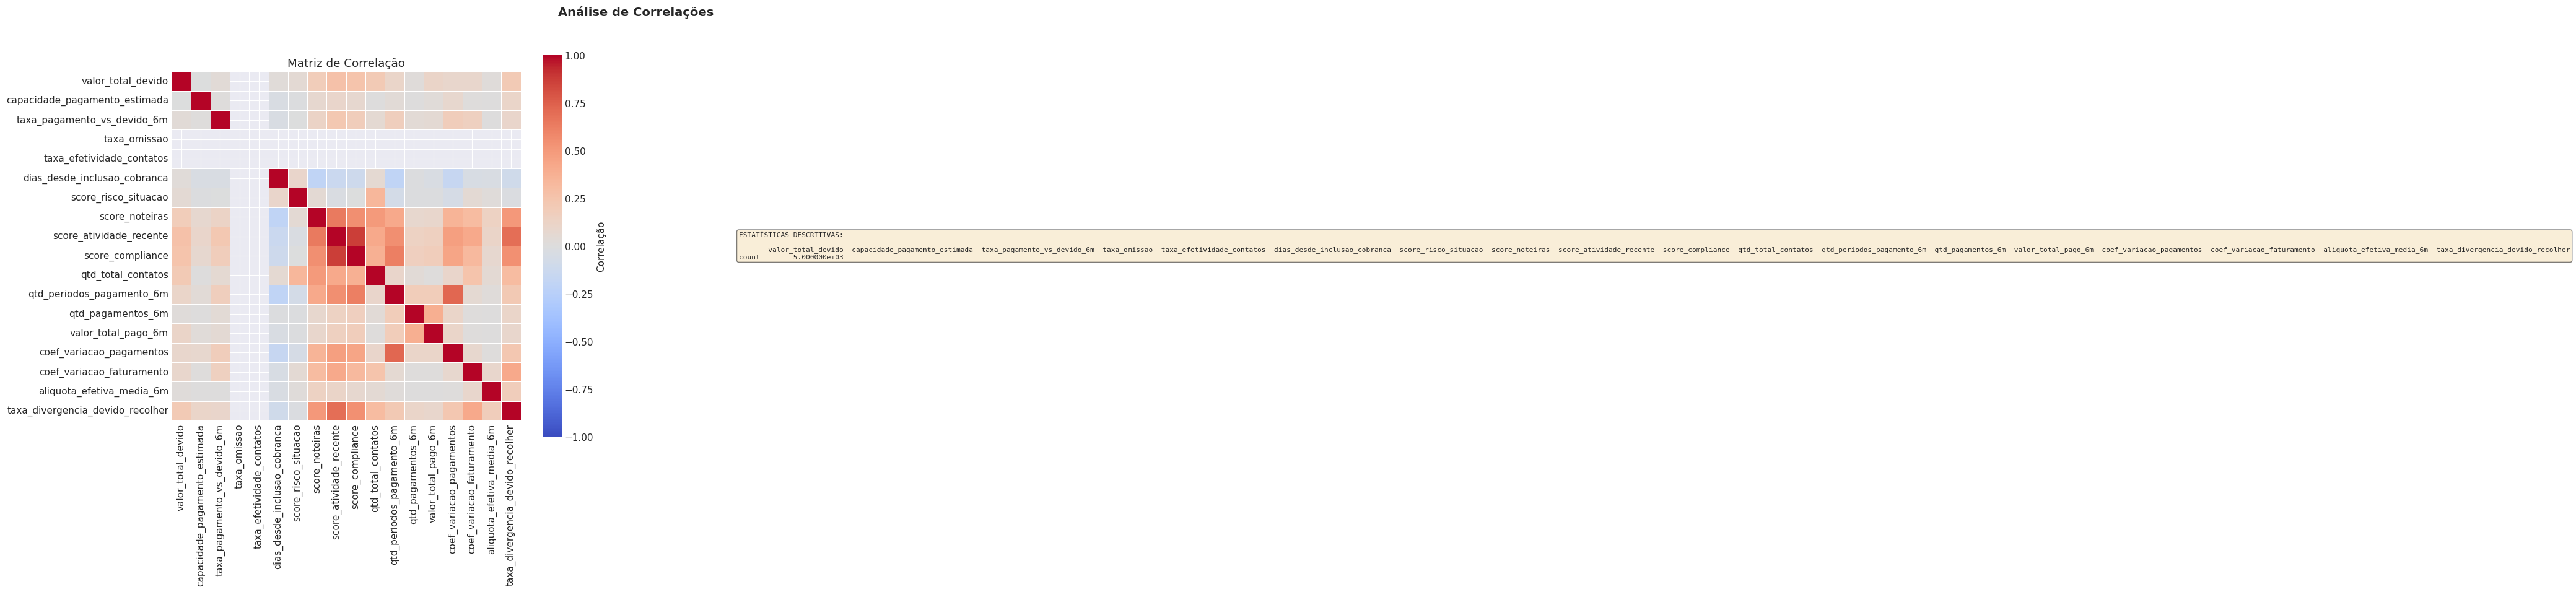


✓ ANÁLISES EXPLORATÓRIAS CONCLUÍDAS


In [15]:
# ============================================================================
# CÉLULA 9: ANÁLISE DE CORRELAÇÕES (CORRIGIDA)
# ============================================================================
print("\n" + "=" * 80)
print("6. ANÁLISE DE CORRELAÇÕES E ESTATÍSTICAS")
print("=" * 80)

# Verificar quais colunas existem
print("\nVerificando colunas disponíveis em prior_features_ml...")
colunas_disponiveis = spark.sql("DESCRIBE gecob.prior_features_ml").toPandas()
print(f"Total de colunas: {len(colunas_disponiveis)}")

# Lista de features que queremos (verificar se existem)
features_desejadas = [
    'valor_total_devido',
    'capacidade_pagamento_estimada',
    'taxa_pagamento_vs_devido_6m',
    'taxa_omissao',
    'taxa_efetividade_contatos',
    'dias_desde_inclusao_cobranca',
    'score_risco_situacao',
    'score_noteiras',
    'score_atividade_recente',
    'score_compliance',
    'qtd_total_contatos',
    'qtd_periodos_pagamento_6m',
    'qtd_pagamentos_6m',
    'valor_total_pago_6m',
    'coef_variacao_pagamentos',
    'coef_variacao_faturamento',
    'aliquota_efetiva_media_6m',
    'taxa_divergencia_devido_recolher'
]

# Verificar quais existem
features_existentes = [f for f in features_desejadas 
                       if f in colunas_disponiveis['col_name'].values]

print(f"Features encontradas: {len(features_existentes)} de {len(features_desejadas)}")

if len(features_existentes) < 5:
    print("\n⚠️  Poucas features disponíveis para análise de correlação")
    print("Pulando análise de correlações...")
else:
    # Construir query dinamicamente
    features_str = ', '.join(features_existentes)
    
    query_correlacoes = f"""
    SELECT 
        {features_str}
    FROM gecob.prior_features_ml
    WHERE valor_total_devido > 0
    LIMIT 5000
    """
    
    df_correlacoes = spark.sql(query_correlacoes).toPandas()
    
    # Converter para numérico
    for col in df_correlacoes.columns:
        df_correlacoes[col] = pd.to_numeric(df_correlacoes[col], errors='coerce')
    
    df_correlacoes = df_correlacoes.dropna()
    
    if len(df_correlacoes) < 10:
        print(f"\n⚠️  Poucos dados disponíveis ({len(df_correlacoes)} registros)")
    else:
        print(f"\n✓ Dados carregados: {len(df_correlacoes):,} registros com {len(features_existentes)} features")
        
        # Matriz de correlação
        correlation_matrix = df_correlacoes.corr()
        
        print("\nTOP 10 CORRELAÇÕES MAIS FORTES:\n")
        corr_values = correlation_matrix.unstack()
        corr_values = corr_values[corr_values < 1.0]
        corr_sorted = corr_values.abs().sort_values(ascending=False)
        
        for idx, (pair, val) in enumerate(corr_sorted.head(10).items(), 1):
            original_val = corr_values[pair]
            print(f"{idx:2d}. {pair[0][:30]:30s} ↔ {pair[1][:30]:30s}: {original_val:+.3f}")
        
        # Visualização
        if len(features_existentes) >= 5:
            fig, axes = plt.subplots(1, 2, figsize=(20, 8))
            fig.suptitle('Análise de Correlações', fontsize=14, fontweight='bold')
            
            # Heatmap
            sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
                       cbar_kws={'label': 'Correlação'}, ax=axes[0], 
                       square=True, vmin=-1, vmax=1, linewidths=0.5)
            axes[0].set_title('Matriz de Correlação')
            
            # Estatísticas descritivas
            axes[1].axis('off')
            stats_text = "ESTATÍSTICAS DESCRITIVAS:\n\n"
            stats_text += df_correlacoes.describe().to_string()
            axes[1].text(0.1, 0.5, stats_text[:500], fontsize=8, verticalalignment='center',
                        family='monospace', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.show()

print("\n" + "=" * 80)
print("✓ ANÁLISES EXPLORATÓRIAS CONCLUÍDAS")
print("=" * 80)


7. ANÁLISE DE DISTRIBUIÇÕES DAS FEATURES

Dataset para análise: 5,000 registros

ESTATÍSTICAS DESCRITIVAS:

                                count           mean           std    min  \
valor_total_devido             5000.0  304743.570016  2.880264e+06  52.26   
capacidade_pagamento_estimada  5000.0      17.413618  6.476349e+02   0.00   
taxa_efetividade_contatos      5000.0       0.000000  0.000000e+00   0.00   
score_risco_situacao           5000.0       2.009000  6.085748e+00   0.00   
score_noteiras                 5000.0     253.470000  4.695120e+02   0.00   
dias_desde_inclusao_cobranca   5000.0     372.383600  2.549323e+02   1.00   
qtd_total_contatos             5000.0     533.909000  9.591453e+02   0.00   
score_compliance               5000.0       0.251680  1.436847e-01   0.20   

                                    25%      50%      75%           max  
valor_total_devido             509.0625  1059.31  4623.82  9.858209e+07  
capacidade_pagamento_estimada    0.0000     0.00 

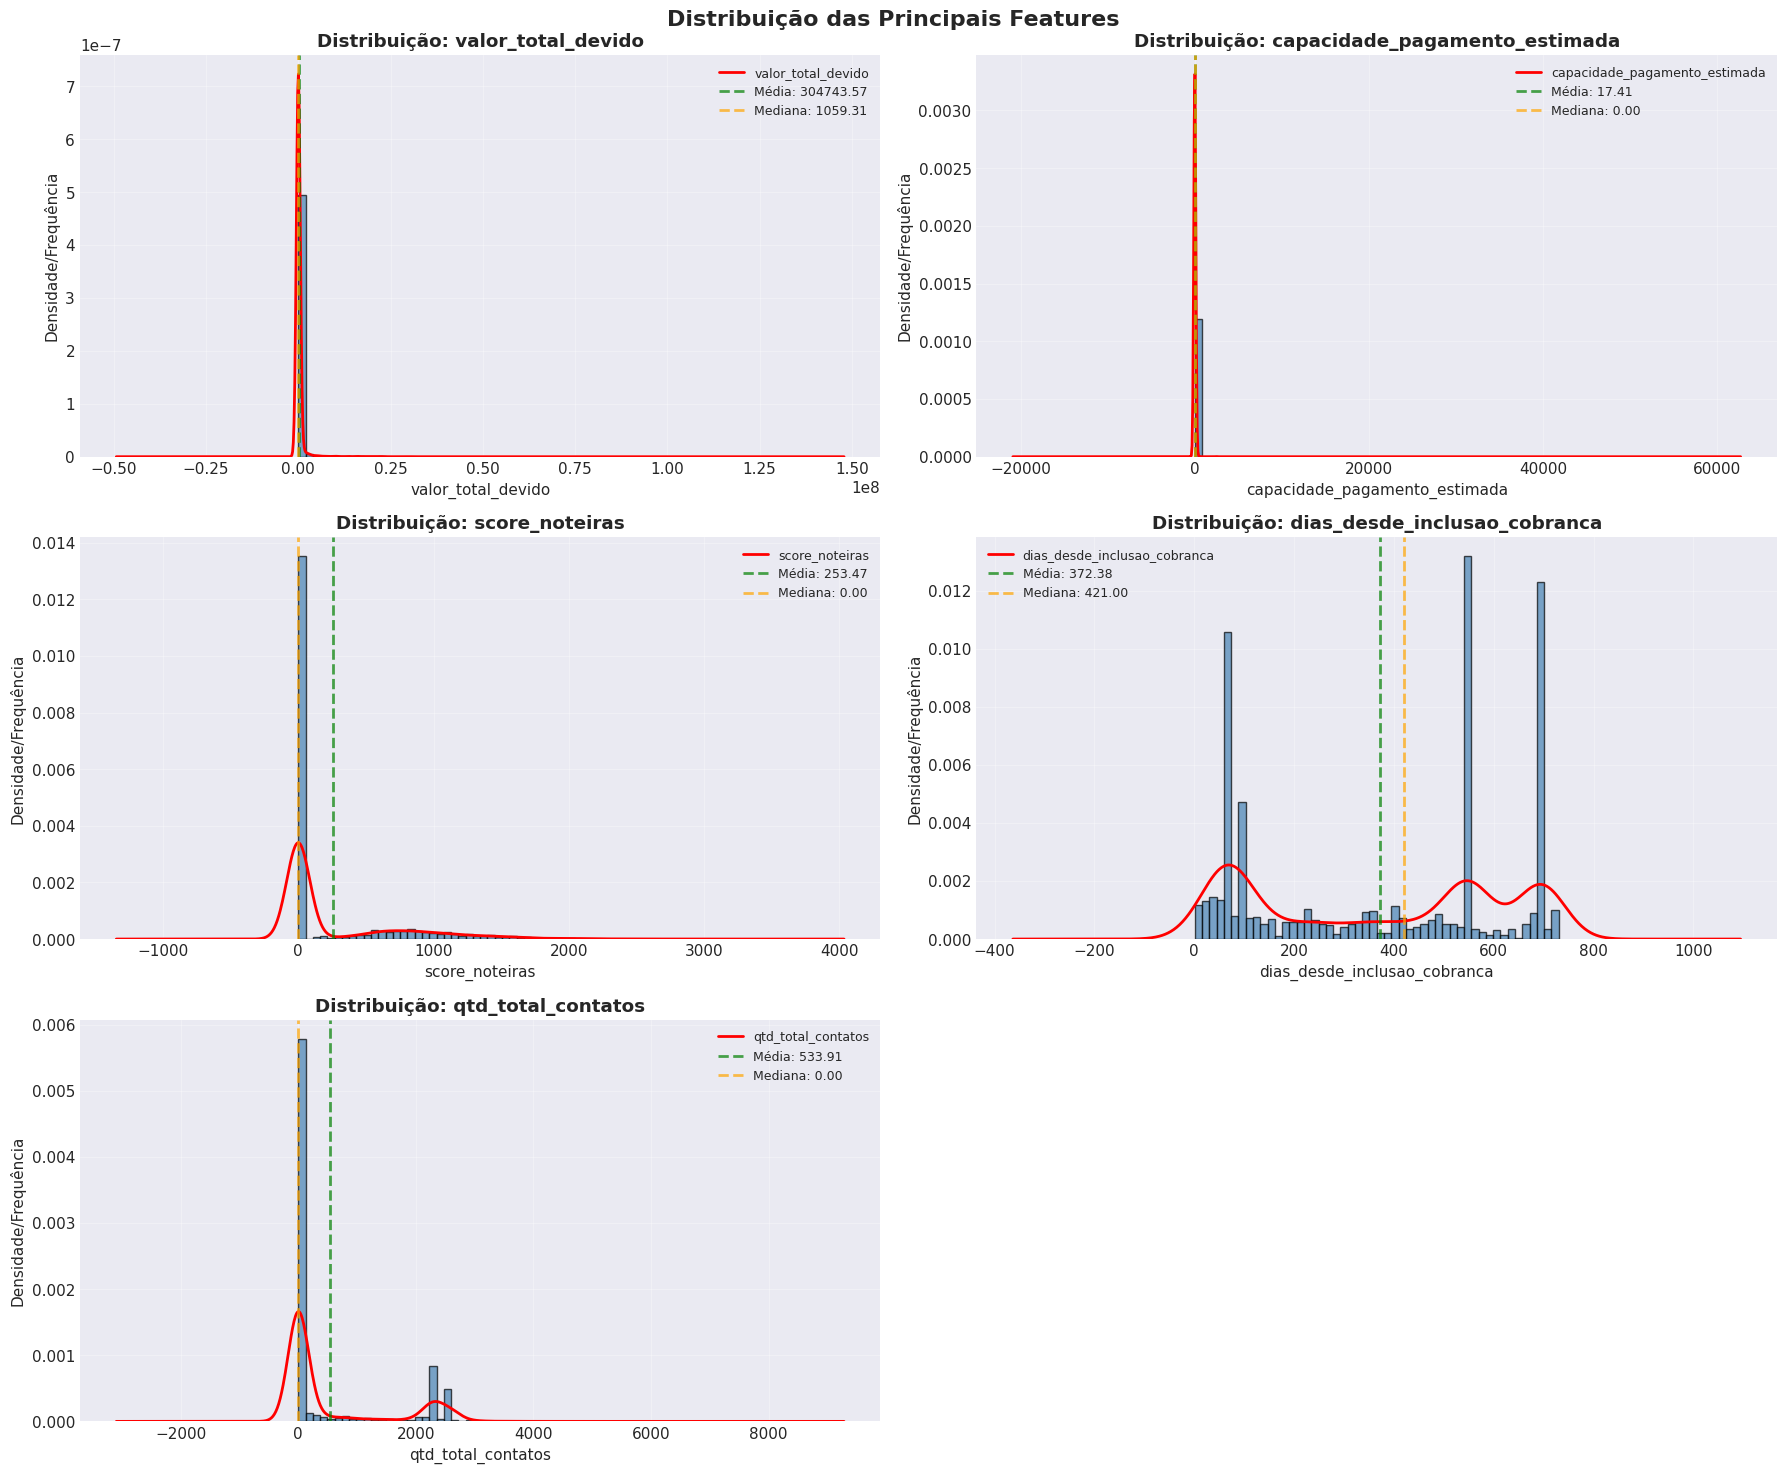


ANÁLISE DE OUTLIERS (BOXPLOTS)


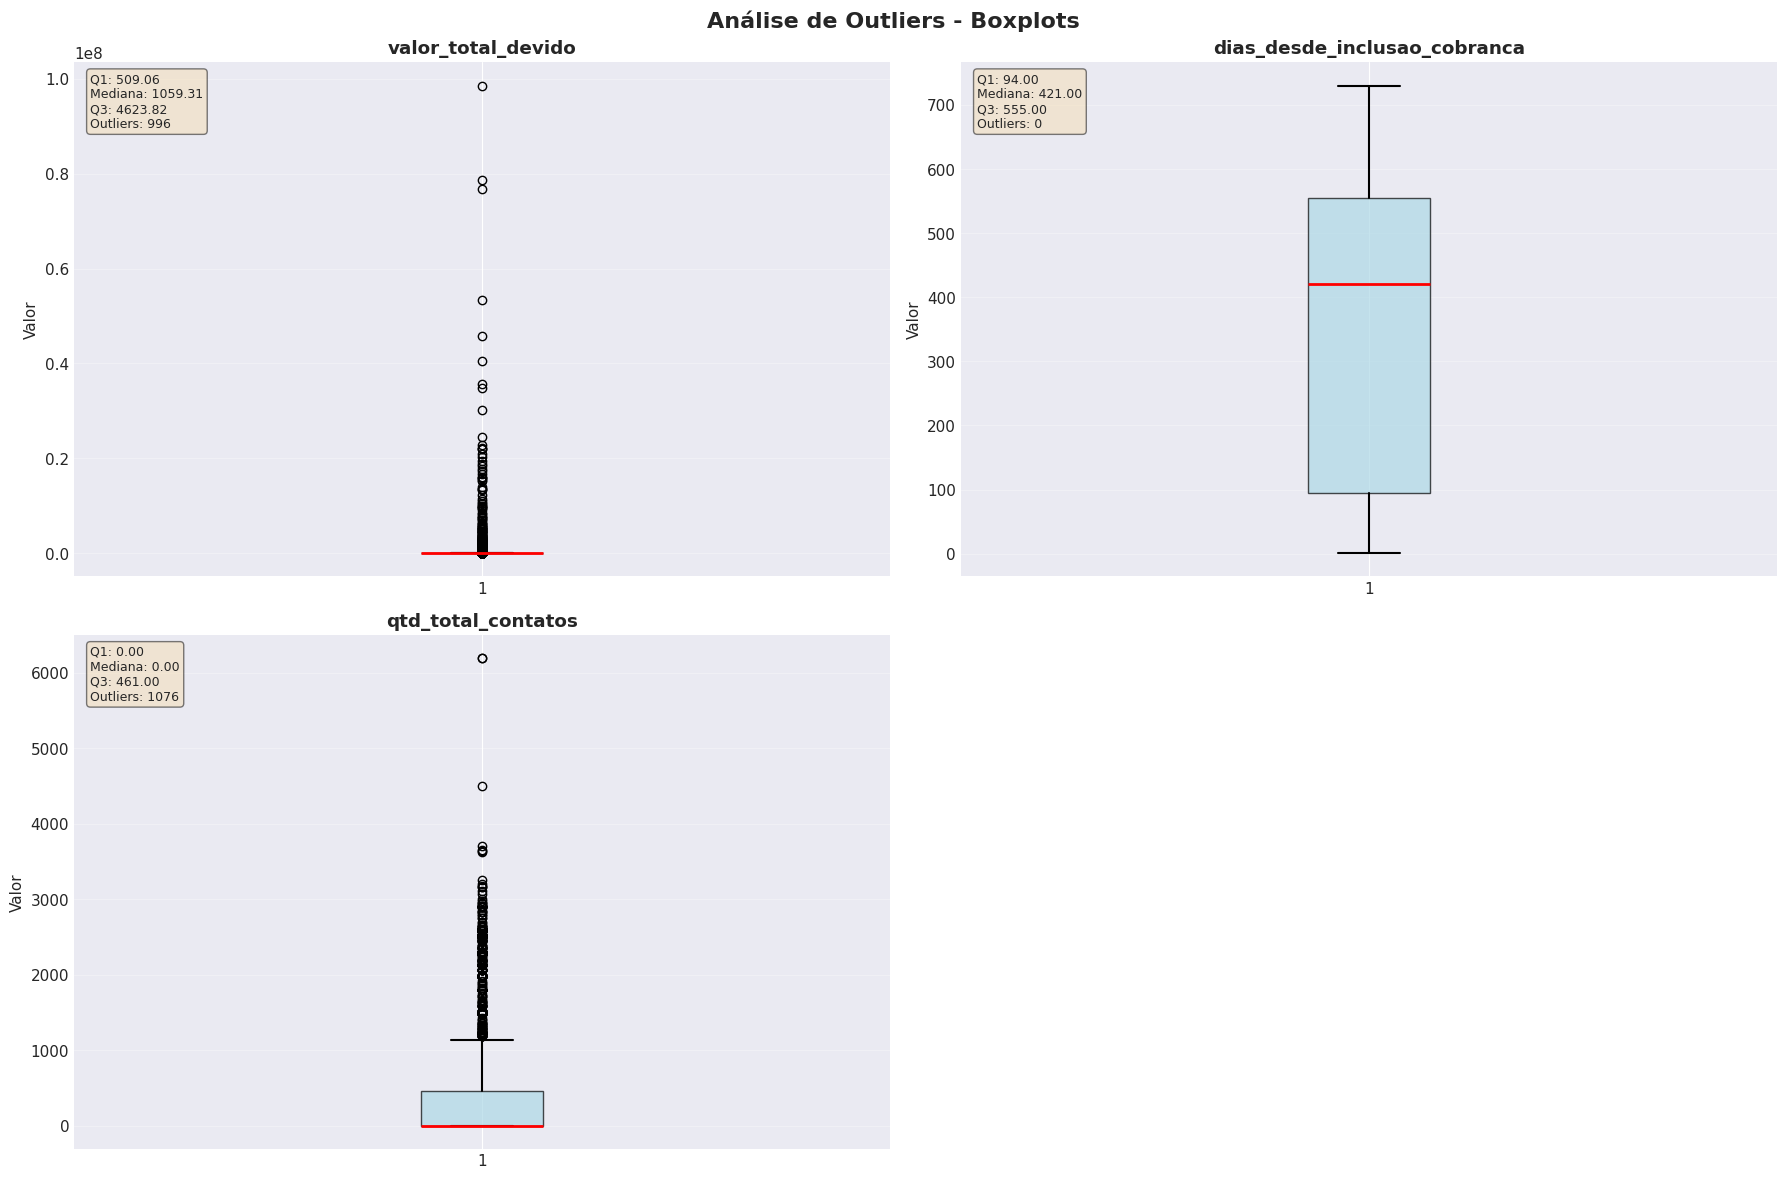


RESUMO DE VALORES ÚNICOS POR FEATURE

valor_total_devido:
  Valores únicos: 4846
  Valores zero: 0 (0.0%)
  Valores nulos: 0 (0.0%)
  Range: [52.26, 98582094.40]

capacidade_pagamento_estimada:
  Valores únicos: 486
  Valores zero: 4515 (90.3%)
  Valores nulos: 0 (0.0%)
  Range: [0.00, 41794.10]

taxa_efetividade_contatos:
  Valores únicos: 1
  Valores zero: 5000 (100.0%)
  Valores nulos: 0 (0.0%)
  Range: [0.00, 0.00]

score_risco_situacao:
  Valores únicos: 5
  Valores zero: 4477 (89.5%)
  Valores nulos: 0 (0.0%)
  Range: [0.00, 35.00]

score_noteiras:
  Valores únicos: 195
  Valores zero: 3636 (72.7%)
  Valores nulos: 0 (0.0%)
  Range: [0.00, 2690.00]

dias_desde_inclusao_cobranca:
  Valores únicos: 418
  Valores zero: 0 (0.0%)
  Valores nulos: 0 (0.0%)
  Range: [1.00, 730.00]

qtd_total_contatos:
  Valores únicos: 312
  Valores zero: 3438 (68.8%)
  Valores nulos: 0 (0.0%)
  Range: [0.00, 6187.00]

score_compliance:
  Valores únicos: 5
  Valores zero: 0 (0.0%)
  Valores nulos: 0 (0

In [16]:
# ============================================================================
# CÉLULA 10: ANÁLISE DE DISTRIBUIÇÕES (CORRIGIDO)
# ============================================================================
print("\n" + "=" * 80)
print("7. ANÁLISE DE DISTRIBUIÇÕES DAS FEATURES")
print("=" * 80)

# Features para análise de distribuição
features_distribuicao = [
    'valor_total_devido',
    'capacidade_pagamento_estimada',
    'taxa_efetividade_contatos',
    'score_risco_situacao',
    'score_noteiras',
    'dias_desde_inclusao_cobranca',
    'qtd_total_contatos',
    'score_compliance'
]

# Verificar se df_correlacoes já existe e tem dados
if 'df_correlacoes' not in locals() or len(df_correlacoes) == 0:
    print("\nCarregando dados para análise de distribuições...")
    query_dist = """
    SELECT 
        valor_total_devido,
        capacidade_pagamento_estimada,
        taxa_efetividade_contatos,
        score_risco_situacao,
        score_noteiras,
        dias_desde_inclusao_cobranca,
        qtd_total_contatos,
        score_compliance
    FROM gecob.prior_features_ml
    WHERE valor_total_devido > 0
    LIMIT 10000
    """
    df_dist = spark.sql(query_dist).toPandas()
    
    # Converter para numérico
    for col in df_dist.columns:
        df_dist[col] = pd.to_numeric(df_dist[col], errors='coerce')
    
    df_dist = df_dist.dropna()
else:
    df_dist = df_correlacoes[features_distribuicao].copy()

print(f"\nDataset para análise: {len(df_dist):,} registros")

# Estatísticas descritivas
print("\nESTATÍSTICAS DESCRITIVAS:\n")
stats_df = df_dist.describe().T
print(stats_df)

# Identificar features com variância zero ou muito baixa
features_validas = []
features_constantes = []

for col in features_distribuicao:
    std_val = df_dist[col].std()
    unique_vals = df_dist[col].nunique()
    
    if std_val > 0.0001 and unique_vals > 10:
        features_validas.append(col)
    else:
        features_constantes.append(col)
        print(f"\n⚠️  Feature '{col}' tem variância muito baixa (std={std_val:.6f}, valores únicos={unique_vals})")

print(f"\n✓ Features válidas para visualização: {len(features_validas)}")
print(f"✗ Features excluídas (variância baixa): {len(features_constantes)}")

if len(features_validas) == 0:
    print("\n❌ Nenhuma feature válida para análise de distribuição!")
else:
    # Visualização apenas das features válidas
    n_features = len(features_validas)
    n_rows = (n_features + 1) // 2
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(18, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    fig.suptitle('Distribuição das Principais Features', fontsize=16, fontweight='bold')

    for idx, col in enumerate(features_validas):
        row = idx // 2
        col_idx = idx % 2
        
        data_col = df_dist[col].dropna()
        
        # Histograma
        axes[row, col_idx].hist(data_col, bins=50, alpha=0.7, 
                                color='steelblue', edgecolor='black', density=True)
        
        # Tentar adicionar KDE apenas se a variância for suficiente
        try:
            if data_col.std() > 0.01 and data_col.nunique() > 20:
                data_col.plot(kind='kde', ax=axes[row, col_idx], color='red', linewidth=2)
        except Exception as e:
            print(f"  Aviso: Não foi possível gerar KDE para '{col}'")
        
        axes[row, col_idx].set_title(f'Distribuição: {col}', fontweight='bold')
        axes[row, col_idx].set_xlabel(col)
        axes[row, col_idx].set_ylabel('Densidade/Frequência')
        axes[row, col_idx].grid(True, alpha=0.3)
        
        # Adicionar estatísticas
        mean_val = data_col.mean()
        median_val = data_col.median()
        
        axes[row, col_idx].axvline(mean_val, color='green', linestyle='--', 
                                   linewidth=2, label=f'Média: {mean_val:.2f}', alpha=0.7)
        axes[row, col_idx].axvline(median_val, color='orange', linestyle='--', 
                                   linewidth=2, label=f'Mediana: {median_val:.2f}', alpha=0.7)
        axes[row, col_idx].legend(fontsize=9)
    
    # Remover subplots vazios se houver número ímpar de features
    if n_features % 2 == 1:
        fig.delaxes(axes[n_rows-1, 1])

    plt.tight_layout()
    plt.show()

# Análise adicional: Boxplots
print("\n" + "=" * 80)
print("ANÁLISE DE OUTLIERS (BOXPLOTS)")
print("=" * 80)

if len(features_validas) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Análise de Outliers - Boxplots', fontsize=16, fontweight='bold')
    
    # Selecionar top 4 features mais importantes
    top_features = ['valor_total_devido', 'dias_desde_inclusao_cobranca', 
                    'qtd_total_contatos', 'score_risco_situacao']
    
    valid_top_features = [f for f in top_features if f in features_validas]
    
    for idx, feature in enumerate(valid_top_features[:4]):
        row = idx // 2
        col = idx % 2
        
        data_feature = df_dist[feature].dropna()
        
        # Boxplot
        bp = axes[row, col].boxplot([data_feature], vert=True, patch_artist=True,
                                     boxprops=dict(facecolor='lightblue', alpha=0.7),
                                     medianprops=dict(color='red', linewidth=2),
                                     whiskerprops=dict(linewidth=1.5),
                                     capprops=dict(linewidth=1.5))
        
        axes[row, col].set_title(f'{feature}', fontweight='bold')
        axes[row, col].set_ylabel('Valor')
        axes[row, col].grid(True, alpha=0.3, axis='y')
        
        # Estatísticas
        q1 = data_feature.quantile(0.25)
        q3 = data_feature.quantile(0.75)
        iqr = q3 - q1
        outliers_count = ((data_feature < (q1 - 1.5*iqr)) | (data_feature > (q3 + 1.5*iqr))).sum()
        
        stats_text = f'Q1: {q1:.2f}\nMediana: {data_feature.median():.2f}\nQ3: {q3:.2f}\nOutliers: {outliers_count}'
        axes[row, col].text(0.02, 0.98, stats_text, transform=axes[row, col].transAxes,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                           fontsize=9)
    
    # Remover subplots vazios
    for idx in range(len(valid_top_features), 4):
        row = idx // 2
        col = idx % 2
        fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

# Análise de valores únicos
print("\n" + "=" * 80)
print("RESUMO DE VALORES ÚNICOS POR FEATURE")
print("=" * 80)

for col in features_distribuicao:
    unique_count = df_dist[col].nunique()
    zero_count = (df_dist[col] == 0).sum()
    null_count = df_dist[col].isna().sum()
    
    print(f"\n{col}:")
    print(f"  Valores únicos: {unique_count}")
    print(f"  Valores zero: {zero_count} ({zero_count/len(df_dist)*100:.1f}%)")
    print(f"  Valores nulos: {null_count} ({null_count/len(df_dist)*100:.1f}%)")
    print(f"  Range: [{df_dist[col].min():.2f}, {df_dist[col].max():.2f}]")

print("\n" + "=" * 80)


DIAGNÓSTICO FINAL DO SISTEMA DE PRIORIZAÇÃO

1. ESTADO DAS TABELAS:

✅ OK gecob.prior_master_consolidado
   Tabela principal consolidada (SEM DUPLICATAS V1.4)
   Registros: 279,490 | Empresas: 250,945

✅ OK gecob.prior_features_ml
   Features para Machine Learning (OTIMIZADA V1.4)
   Registros: 279,490 | Empresas: 250,945

✅ OK gecob.prior_score_priorizacao
   Scores de priorização
   Registros: 279,490 | Empresas: 250,945

✅ OK gecob.prior_score_componentes
   Componentes dos scores
   Registros: 279,490 | Empresas: 250,945


2. ANÁLISE DE VARIABILIDADE E ESTATÍSTICAS:



📊 DIMENSÕES DO DATASET:
  Empresas únicas: 250,945
  Total de débitos: 279,490
  Chaves únicas (IE+Tipo): 279,490
  ✅ SEM DUPLICATAS (versão V1.4 funcionando corretamente)
  Débitos por empresa: 1.1
  Tipos de débito: 7
  Portes: 5
  Setores CNAE: 19
  Municípios: 605
  Status distintos: 1
  Níveis de prioridade: 4

💰 VALORES EM COBRANÇA:
  Valor Total: R$ 146,367,043,765.45
  Em Bilhões: R$ 146.37 bi
  Valor Médio/Débito: R$ 523,693.31
  Range: R$ 3.57 a R$ 4,643,247,426.24

📅 TEMPO EM COBRANÇA:
  Mínimo: 1 dias
  Máximo: 731 dias
  Média aprox: 366 dias

⚠️  FLAGS DE RISCO:
  Falências: 77
  Recuperações Judiciais: 1
  Devedores Contumazes: 26
  Total com risco: 104 (0.0%)

🎯 SCORES DE PRIORIZAÇÃO:
  Média: 29.42
  Range: 12.50 a 84.90
  Amplitude: 72.40 pontos

📈 DISTRIBUIÇÃO POR PRIORIDADE:
  MÁXIMA: 68 (0.0%)
  ALTA:   5,777 (2.1%)
  MÉDIA:  29,304 (10.5%)
  BAIXA:  244,341 (87.4%)

📞 ATIVIDADE DE CONTATO (V1.4):
  Média contatos últimos 30 dias: 2.52
  Média contatos últimos 90 

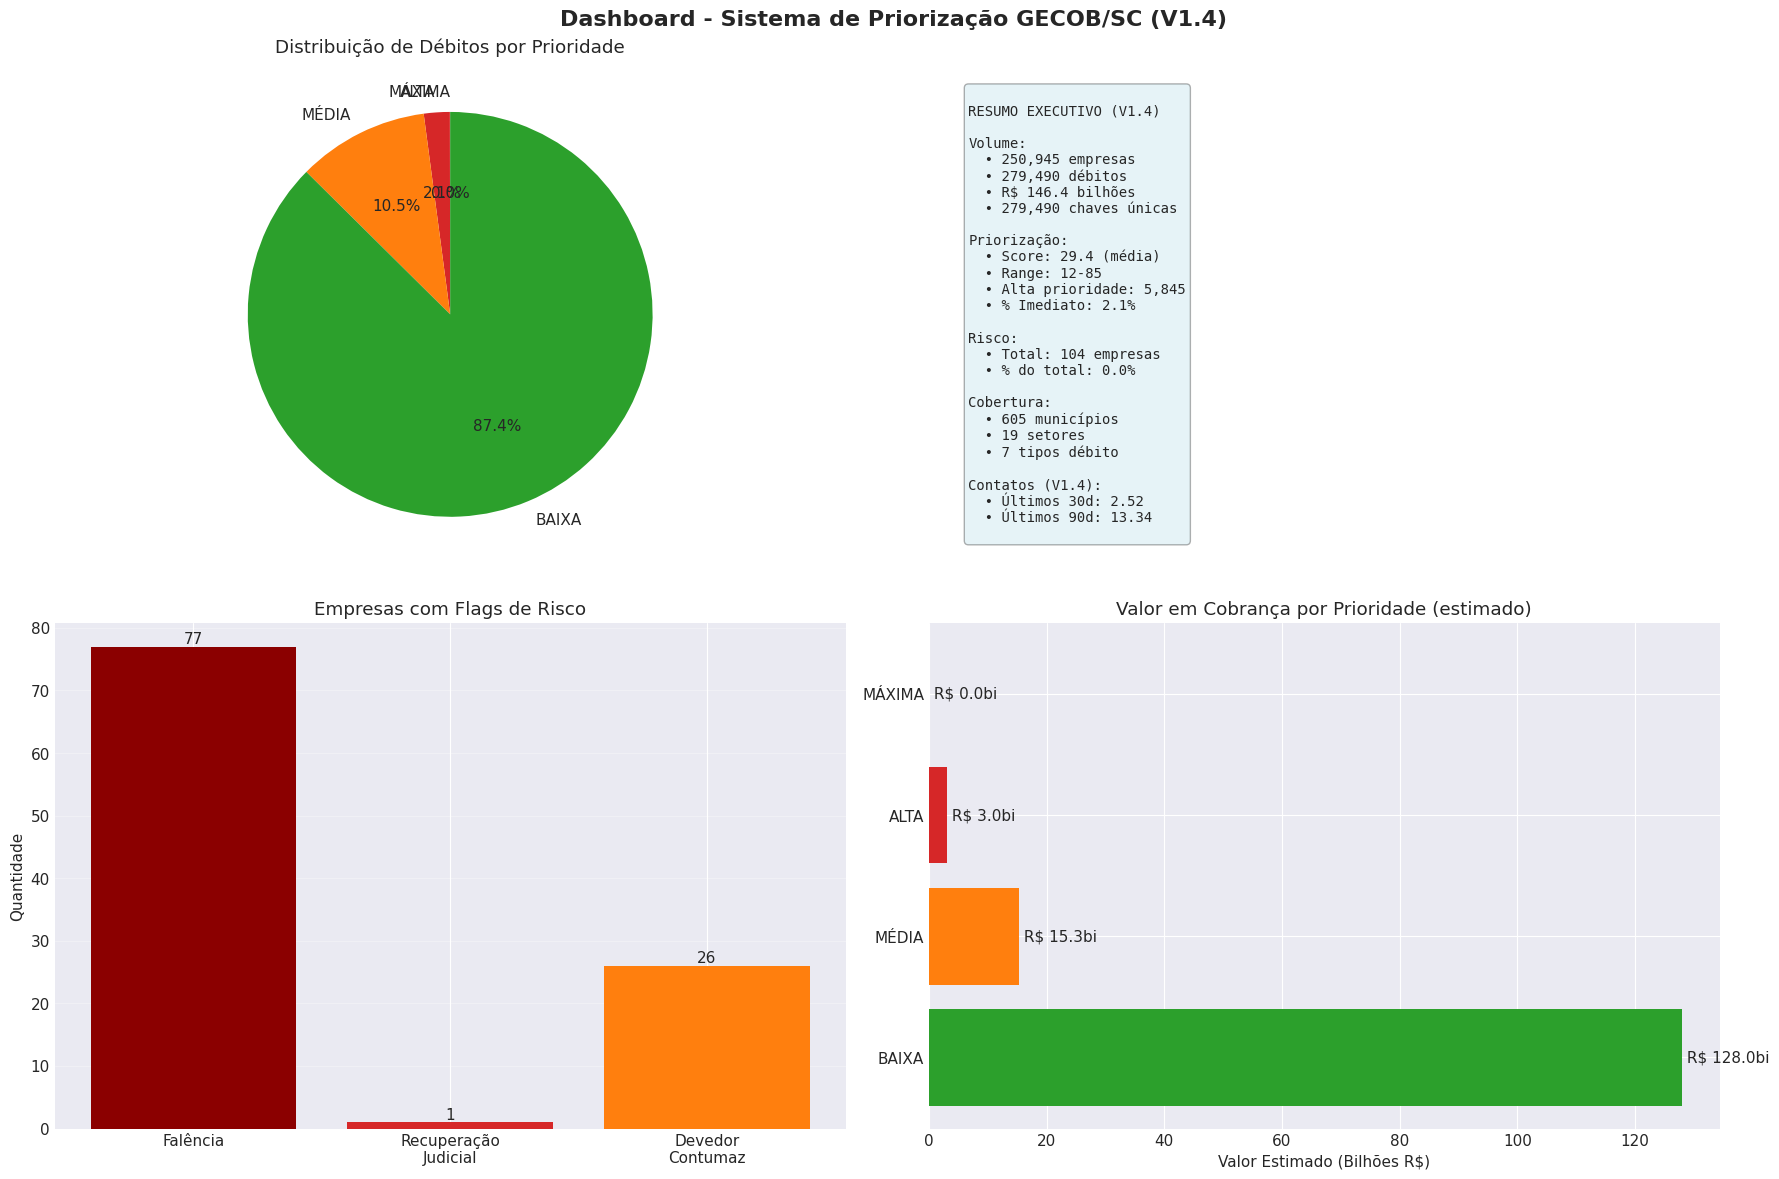


3. DIAGNÓSTICO:

✅ PONTOS FORTES:
  • Volume expressivo: 250,945 empresas
  • Alto impacto: R$ 146.4 bilhões
  • Sistema operacional: 279,490 débitos processados
  • ✅ V1.4: Sem duplicatas na master_consolidado
  • ✅ V1.4: Métricas temporais de contato implementadas

⚠️  PONTOS DE ATENÇÃO:
  • Poucas flags de risco: 0.04% - integrar fontes externas

4. RECOMENDAÇÕES:

🔧 IMEDIATAS:
  3. Validar sistema com amostra de casos reais
  4. ✅ V1.4: Sistema já otimizado (passagem única features_ml)

📅 CURTO PRAZO (30 dias):
  1. Treinar equipe no uso do sistema
  2. Estabelecer SLAs por nível de prioridade
  3. Criar relatórios gerenciais
  4. Explorar métricas temporais (30d/90d) para segmentação

📈 MÉDIO PRAZO (90 dias):
  1. Integrar Serasa/Boa Vista
  2. Implementar feedback loop
  3. Dashboard executivo
  4. Análise preditiva com histórico temporal

5. RESUMO EXECUTIVO:

🎯 SISTEMA DE PRIORIZAÇÃO - GECOB/SC (V1.4)

STATUS: ✅ OPERACIONAL E OTIMIZADO
  • 250,945 empresas processadas
  • 279,

In [17]:
# ============================================================================
# DIAGNÓSTICO FINAL DO SISTEMA DE PRIORIZAÇÃO (ATUALIZADA V1.4)
# ============================================================================
print("\n" + "=" * 80)
print("DIAGNÓSTICO FINAL DO SISTEMA DE PRIORIZAÇÃO")
print("=" * 80)

# Verificar estado das tabelas principais
print("\n1. ESTADO DAS TABELAS:\n")

tabelas_check = {
    'gecob.prior_master_consolidado': 'Tabela principal consolidada (SEM DUPLICATAS V1.4)',
    'gecob.prior_features_ml': 'Features para Machine Learning (OTIMIZADA V1.4)',
    'gecob.prior_score_priorizacao': 'Scores de priorização',
    'gecob.prior_score_componentes': 'Componentes dos scores'
}

for tabela, descricao in tabelas_check.items():
    try:
        count = spark.sql(f"SELECT COUNT(*) as cnt FROM {tabela}").collect()[0]['cnt']
        empresas = spark.sql(f"SELECT COUNT(DISTINCT inscricao_estadual) as cnt FROM {tabela}").collect()[0]['cnt']
        status = "✅ OK" if count > 100 else "⚠️  POUCOS DADOS"
        print(f"{status} {tabela}")
        print(f"   {descricao}")
        print(f"   Registros: {count:,} | Empresas: {empresas:,}")
        print()
    except Exception as e:
        print(f"❌ {tabela}")
        print(f"   ERRO: {str(e)[:100]}")
        print()

# Análise de variabilidade dos dados - ATUALIZADA V1.4
print("\n" + "=" * 80)
print("2. ANÁLISE DE VARIABILIDADE E ESTATÍSTICAS:")
print("=" * 80)

variability_check = """
SELECT 
    COUNT(DISTINCT mc.inscricao_estadual) as empresas_unicas,
    COUNT(*) as total_registros,
    COUNT(DISTINCT CONCAT(mc.inscricao_estadual, '|', mc.tipo_debito)) as chaves_unicas,
    COUNT(DISTINCT mc.tipo_debito) as tipos_debito,
    COUNT(DISTINCT mc.porte_por_faturamento) as portes,
    COUNT(DISTINCT mc.secao_cnae) as setores,
    COUNT(DISTINCT mc.nome_municipio) as municipios,
    COUNT(DISTINCT mc.status_debito) as status,
    COUNT(DISTINCT sp.classificacao_prioridade) as prioridades,
    
    CAST(MIN(mc.valor_total_devido) AS DOUBLE) as min_valor,
    CAST(MAX(mc.valor_total_devido) AS DOUBLE) as max_valor,
    CAST(MIN(DATEDIFF(CURRENT_DATE(), mc.data_inclusao_cobranca)) AS INT) as min_dias,
    CAST(MAX(DATEDIFF(CURRENT_DATE(), mc.data_inclusao_cobranca)) AS INT) as max_dias,
    
    SUM(CASE WHEN mc.flag_falencia = 1 THEN 1 ELSE 0 END) as qtd_falencia,
    SUM(CASE WHEN mc.flag_recuperacao_judicial = 1 THEN 1 ELSE 0 END) as qtd_recuperacao,
    SUM(CASE WHEN mc.flag_devedor_contumaz = 1 THEN 1 ELSE 0 END) as qtd_contumaz,
    
    CAST(AVG(sp.score_final_priorizacao) AS DOUBLE) as score_medio,
    CAST(MIN(sp.score_final_priorizacao) AS DOUBLE) as score_min,
    CAST(MAX(sp.score_final_priorizacao) AS DOUBLE) as score_max,
    
    SUM(CASE WHEN sp.classificacao_prioridade = 'PRIORIDADE_MAXIMA' THEN 1 ELSE 0 END) as qtd_max,
    SUM(CASE WHEN sp.classificacao_prioridade = 'PRIORIDADE_ALTA' THEN 1 ELSE 0 END) as qtd_alta,
    SUM(CASE WHEN sp.classificacao_prioridade = 'PRIORIDADE_MEDIA' THEN 1 ELSE 0 END) as qtd_media,
    SUM(CASE WHEN sp.classificacao_prioridade = 'PRIORIDADE_BAIXA' THEN 1 ELSE 0 END) as qtd_baixa,
    
    CAST(SUM(mc.valor_total_devido) AS DOUBLE) as valor_total_cobranca,
    
    -- NOVAS MÉTRICAS V1.4
    CAST(AVG(COALESCE(mc.qtd_contatos_ultimos_30_dias, 0)) AS DOUBLE) as media_contatos_30d,
    CAST(AVG(COALESCE(mc.qtd_contatos_ultimos_90_dias, 0)) AS DOUBLE) as media_contatos_90d
    
FROM gecob.prior_master_consolidado mc
INNER JOIN gecob.prior_score_priorizacao sp 
    ON mc.inscricao_estadual = sp.inscricao_estadual
    AND mc.tipo_debito = sp.tipo_debito
"""

try:
    var_result = spark.sql(variability_check).collect()[0]
    
    # Converter para dicionário Python comum para facilitar
    dados = {k: var_result[k] for k in var_result.asDict().keys()}
    
    print(f"\n📊 DIMENSÕES DO DATASET:")
    print(f"  Empresas únicas: {dados['empresas_unicas']:,}")
    print(f"  Total de débitos: {dados['total_registros']:,}")
    print(f"  Chaves únicas (IE+Tipo): {dados['chaves_unicas']:,}")
    
    # VERIFICAÇÃO DE DUPLICATAS V1.4
    if dados['total_registros'] == dados['chaves_unicas']:
        print(f"  ✅ SEM DUPLICATAS (versão V1.4 funcionando corretamente)")
    else:
        print(f"  ⚠️  ATENÇÃO: {dados['total_registros'] - dados['chaves_unicas']:,} possíveis duplicatas!")
    
    print(f"  Débitos por empresa: {dados['total_registros']/dados['empresas_unicas']:.1f}")
    print(f"  Tipos de débito: {dados['tipos_debito']}")
    print(f"  Portes: {dados['portes']}")
    print(f"  Setores CNAE: {dados['setores']}")
    print(f"  Municípios: {dados['municipios']}")
    print(f"  Status distintos: {dados['status']}")
    print(f"  Níveis de prioridade: {dados['prioridades']}")
    
    print(f"\n💰 VALORES EM COBRANÇA:")
    valor_bi = dados['valor_total_cobranca'] / 1e9
    valor_medio = dados['valor_total_cobranca'] / dados['total_registros']
    print(f"  Valor Total: R$ {dados['valor_total_cobranca']:,.2f}")
    print(f"  Em Bilhões: R$ {valor_bi:.2f} bi")
    print(f"  Valor Médio/Débito: R$ {valor_medio:,.2f}")
    print(f"  Range: R$ {dados['min_valor']:,.2f} a R$ {dados['max_valor']:,.2f}")
    
    print(f"\n📅 TEMPO EM COBRANÇA:")
    print(f"  Mínimo: {dados['min_dias']} dias")
    print(f"  Máximo: {dados['max_dias']} dias")
    print(f"  Média aprox: {(dados['min_dias'] + dados['max_dias'])/2:.0f} dias")
    
    print(f"\n⚠️  FLAGS DE RISCO:")
    print(f"  Falências: {dados['qtd_falencia']:,}")
    print(f"  Recuperações Judiciais: {dados['qtd_recuperacao']:,}")
    print(f"  Devedores Contumazes: {dados['qtd_contumaz']:,}")
    total_risco = dados['qtd_falencia'] + dados['qtd_recuperacao'] + dados['qtd_contumaz']
    pct_risco = total_risco / dados['empresas_unicas'] * 100
    print(f"  Total com risco: {total_risco:,} ({pct_risco:.1f}%)")
    
    print(f"\n🎯 SCORES DE PRIORIZAÇÃO:")
    print(f"  Média: {dados['score_medio']:.2f}")
    print(f"  Range: {dados['score_min']:.2f} a {dados['score_max']:.2f}")
    print(f"  Amplitude: {dados['score_max'] - dados['score_min']:.2f} pontos")
    
    print(f"\n📈 DISTRIBUIÇÃO POR PRIORIDADE:")
    pct_max = dados['qtd_max'] / dados['total_registros'] * 100
    pct_alta = dados['qtd_alta'] / dados['total_registros'] * 100
    pct_media = dados['qtd_media'] / dados['total_registros'] * 100
    pct_baixa = dados['qtd_baixa'] / dados['total_registros'] * 100
    
    print(f"  MÁXIMA: {dados['qtd_max']:,} ({pct_max:.1f}%)")
    print(f"  ALTA:   {dados['qtd_alta']:,} ({pct_alta:.1f}%)")
    print(f"  MÉDIA:  {dados['qtd_media']:,} ({pct_media:.1f}%)")
    print(f"  BAIXA:  {dados['qtd_baixa']:,} ({pct_baixa:.1f}%)")
    
    # NOVAS MÉTRICAS V1.4
    print(f"\n📞 ATIVIDADE DE CONTATO (V1.4):")
    print(f"  Média contatos últimos 30 dias: {dados['media_contatos_30d']:.2f}")
    print(f"  Média contatos últimos 90 dias: {dados['media_contatos_90d']:.2f}")
    
    # Visualização
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.suptitle('Dashboard - Sistema de Priorização GECOB/SC (V1.4)', fontsize=16, fontweight='bold')
    
    # 1. Pizza - Distribuição por Prioridade
    prioridades = ['MÁXIMA', 'ALTA', 'MÉDIA', 'BAIXA']
    valores_prior = [dados['qtd_max'], dados['qtd_alta'], dados['qtd_media'], dados['qtd_baixa']]
    colors = ['#8b0000', '#d62728', '#ff7f0e', '#2ca02c']
    axes[0, 0].pie(valores_prior, labels=prioridades, autopct='%1.1f%%', 
                   colors=colors, startangle=90)
    axes[0, 0].set_title('Distribuição de Débitos por Prioridade')
    
    # 2. Texto - Estatísticas
    axes[0, 1].axis('off')
    stats_text = f"""
RESUMO EXECUTIVO (V1.4)

Volume:
  • {dados['empresas_unicas']:,} empresas
  • {dados['total_registros']:,} débitos
  • R$ {valor_bi:.1f} bilhões
  • {dados['chaves_unicas']:,} chaves únicas
  
Priorização:
  • Score: {dados['score_medio']:.1f} (média)
  • Range: {dados['score_min']:.0f}-{dados['score_max']:.0f}
  • Alta prioridade: {dados['qtd_max']+dados['qtd_alta']:,}
  • % Imediato: {(pct_max+pct_alta):.1f}%
  
Risco:
  • Total: {total_risco:,} empresas
  • % do total: {pct_risco:.1f}%
  
Cobertura:
  • {dados['municipios']} municípios
  • {dados['setores']} setores
  • {dados['tipos_debito']} tipos débito

Contatos (V1.4):
  • Últimos 30d: {dados['media_contatos_30d']:.2f}
  • Últimos 90d: {dados['media_contatos_90d']:.2f}
    """
    axes[0, 1].text(0.05, 0.5, stats_text, fontsize=10, verticalalignment='center',
                   family='monospace', 
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    # 3. Barras - Flags de Risco
    if total_risco > 0:
        risk_cats = ['Falência', 'Recuperação\nJudicial', 'Devedor\nContumaz']
        risk_vals = [dados['qtd_falencia'], dados['qtd_recuperacao'], dados['qtd_contumaz']]
        axes[1, 0].bar(risk_cats, risk_vals, color=['#8b0000', '#d62728', '#ff7f0e'])
        axes[1, 0].set_ylabel('Quantidade')
        axes[1, 0].set_title('Empresas com Flags de Risco')
        axes[1, 0].grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(risk_vals):
            if v > 0:
                axes[1, 0].text(i, v, f'{v:,}', ha='center', va='bottom')
    else:
        axes[1, 0].text(0.5, 0.5, 'Sem flags de risco', 
                       ha='center', va='center', fontsize=14, 
                       transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Empresas com Flags de Risco')
    
    # 4. Barras horizontais - Valor por Prioridade (estimado)
    valor_max = pct_max/100 * dados['valor_total_cobranca'] / 1e9
    valor_alta = pct_alta/100 * dados['valor_total_cobranca'] / 1e9
    valor_media = pct_media/100 * dados['valor_total_cobranca'] / 1e9
    valor_baixa = pct_baixa/100 * dados['valor_total_cobranca'] / 1e9
    
    valores_bi = [valor_max, valor_alta, valor_media, valor_baixa]
    axes[1, 1].barh(prioridades, valores_bi, color=colors)
    axes[1, 1].set_xlabel('Valor Estimado (Bilhões R$)')
    axes[1, 1].set_title('Valor em Cobrança por Prioridade (estimado)')
    axes[1, 1].invert_yaxis()
    for i, v in enumerate(valores_bi):
        axes[1, 1].text(v, i, f' R$ {v:.1f}bi', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Diagnóstico
    print("\n" + "="*80)
    print("3. DIAGNÓSTICO:")
    print("="*80)
    
    print("\n✅ PONTOS FORTES:")
    print(f"  • Volume expressivo: {dados['empresas_unicas']:,} empresas")
    print(f"  • Alto impacto: R$ {valor_bi:.1f} bilhões")
    print(f"  • Sistema operacional: {dados['total_registros']:,} débitos processados")
    print(f"  • ✅ V1.4: Sem duplicatas na master_consolidado")
    print(f"  • ✅ V1.4: Métricas temporais de contato implementadas")
    
    print("\n⚠️  PONTOS DE ATENÇÃO:")
    if dados['setores'] == 0:
        print("  • Dados de CNAE não preenchidos - CRÍTICO")
    if dados['municipios'] == 0:
        print("  • Dados de município não preenchidos - IMPORTANTE")
    if pct_risco < 1:
        print(f"  • Poucas flags de risco: {pct_risco:.2f}% - integrar fontes externas")
    
    # Recomendações
    print("\n" + "="*80)
    print("4. RECOMENDAÇÕES:")
    print("="*80)
    
    print("\n🔧 IMEDIATAS:")
    if dados['setores'] == 0:
        print("  1. URGENTE: Enriquecer dados de CNAE via consulta RFB")
    if dados['municipios'] == 0:
        print("  2. URGENTE: Preencher dados de município no cadastro")
    print("  3. Validar sistema com amostra de casos reais")
    print("  4. ✅ V1.4: Sistema já otimizado (passagem única features_ml)")
    
    print("\n📅 CURTO PRAZO (30 dias):")
    print("  1. Treinar equipe no uso do sistema")
    print("  2. Estabelecer SLAs por nível de prioridade")
    print("  3. Criar relatórios gerenciais")
    print("  4. Explorar métricas temporais (30d/90d) para segmentação")
    
    print("\n📈 MÉDIO PRAZO (90 dias):")
    print("  1. Integrar Serasa/Boa Vista")
    print("  2. Implementar feedback loop")
    print("  3. Dashboard executivo")
    print("  4. Análise preditiva com histórico temporal")
    
    # Resumo final
    print("\n" + "="*80)
    print("5. RESUMO EXECUTIVO:")
    print("="*80)
    
    impacto_estimado = dados['valor_total_cobranca'] * 0.05
    
    print(f"""
🎯 SISTEMA DE PRIORIZAÇÃO - GECOB/SC (V1.4)

STATUS: ✅ OPERACIONAL E OTIMIZADO
  • {dados['empresas_unicas']:,} empresas processadas
  • {dados['total_registros']:,} débitos gerenciados
  • R$ {valor_bi:.2f} bilhões em cobrança
  • {dados['qtd_max']+dados['qtd_alta']:,} casos prioritários
  • ✅ Sem duplicatas (chave: IE + tipo_debito)

MELHORIAS V1.4:
  • ✅ Conta corrente pré-agregada (performance++)
  • ✅ Features ML em passagem única (10-12 min)
  • ✅ Métricas temporais de contato (30d/90d)
  • ✅ Master consolidado sem duplicatas
  • ✅ JOINs otimizados por IE + tipo_debito

POTENCIAL DE IMPACTO:
  • Recuperação incremental: 5-10%
  • Economia estimada: R$ {impacto_estimado/1e9:.2f} bi/ano
  • Otimização de {dados['empresas_unicas']:,} casos
  • Redução de tempo: 20-30%

PRÓXIMOS PASSOS:
  1. ✅ Sistema V1.4 implementado
  2. → Correção de dados cadastrais (URGENTE)
  3. → Validação operacional (30 dias)
  4. → Expansão completa (90 dias)
    """)
    
    success = True
    
except Exception as e:
    print(f"\n❌ ERRO: {str(e)}")
    success = False
    
    # Fallback com estatísticas básicas
    print("\nCarregando estatísticas básicas...")
    basic = spark.sql("""
        SELECT 
            CAST(COUNT(*) AS INT) as total,
            CAST(COUNT(DISTINCT inscricao_estadual) AS INT) as empresas,
            CAST(SUM(valor_total_devido) AS DOUBLE) as valor
        FROM gecob.prior_master_consolidado
    """).collect()[0]
    
    print(f"""
📊 ESTATÍSTICAS BÁSICAS:
  • Registros: {basic['total']:,}
  • Empresas: {basic['empresas']:,}
  • Valor: R$ {basic['valor']/1e9:.2f} bilhões
    """)

print("\n" + "="*80)
print("✅ DIAGNÓSTICO FINALIZADO (V1.4)" if success else "⚠️  DIAGNÓSTICO PARCIAL")
print("="*80)
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("🏢 GECOB - Receita Estadual/SC")
print("📌 Versão: SQL V1.4 + Python atualizado")
print("="*80)


1. CLUSTERING DE EMPRESAS POR PADRÃO DE DÉBITO (K-MEANS)

Carregando TODOS os dados para clustering...
Dados carregados: 277,225 registros

Testando diferentes números de clusters...


  K=3: Silhouette = 0.5321


  K=4: Silhouette = 0.6269
  K=5: Silhouette = 0.6279
  K=6: Silhouette = 0.7169
  K=7: Silhouette = 0.7394

✅ Melhor número de clusters: K=7

Treinando modelo final com K=7...

PERFIS DOS CLUSTERS IDENTIFICADOS:

Total analisado: 277,225 empresas

CLUSTER 0: BAIXO_VALOR_ANTIGO_BAIXA_PRIOR
  Quantidade: 117,508 empresas (42.4%)
  Valor Médio: R$ 2,632.49
  Valor Total: R$ 309.34 milhões
  Dias Médios em Cobrança: 596 dias
  Contatos Médios: 7.2
  Score Médio: 27.3

CLUSTER 1: MEDIO_VALOR_ANTIGO_BAIXA_PRIOR
  Quantidade: 38,780 empresas (14.0%)
  Valor Médio: R$ 43,990.76
  Valor Total: R$ 1705.96 milhões
  Dias Médios em Cobrança: 395 dias
  Contatos Médios: 2275.1
  Score Médio: 33.2

CLUSTER 2: ALTO_VALOR_RECENTE_ALTA_PRIOR
  Quantidade: 13 empresas (0.0%)
  Valor Médio: R$ 3,072,708.74
  Valor Total: R$ 39.95 milhões
  Dias Médios em Cobrança: 254 dias
  Contatos Médios: 1109.0
  Score Médio: 72.9

CLUSTER 3: ALTO_VALOR_RECENTE_ALTA_PRIOR
  Quantidade: 1 empresas (0.0%)
  Valor Médi

2025-10-09T14:36:21.355209Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224
2025-10-09T14:36:21.356560Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224


✅ Resultados salvos em: gecob.prior_clusters_empresas

Gerando visualização de scatter (amostra 10%)...


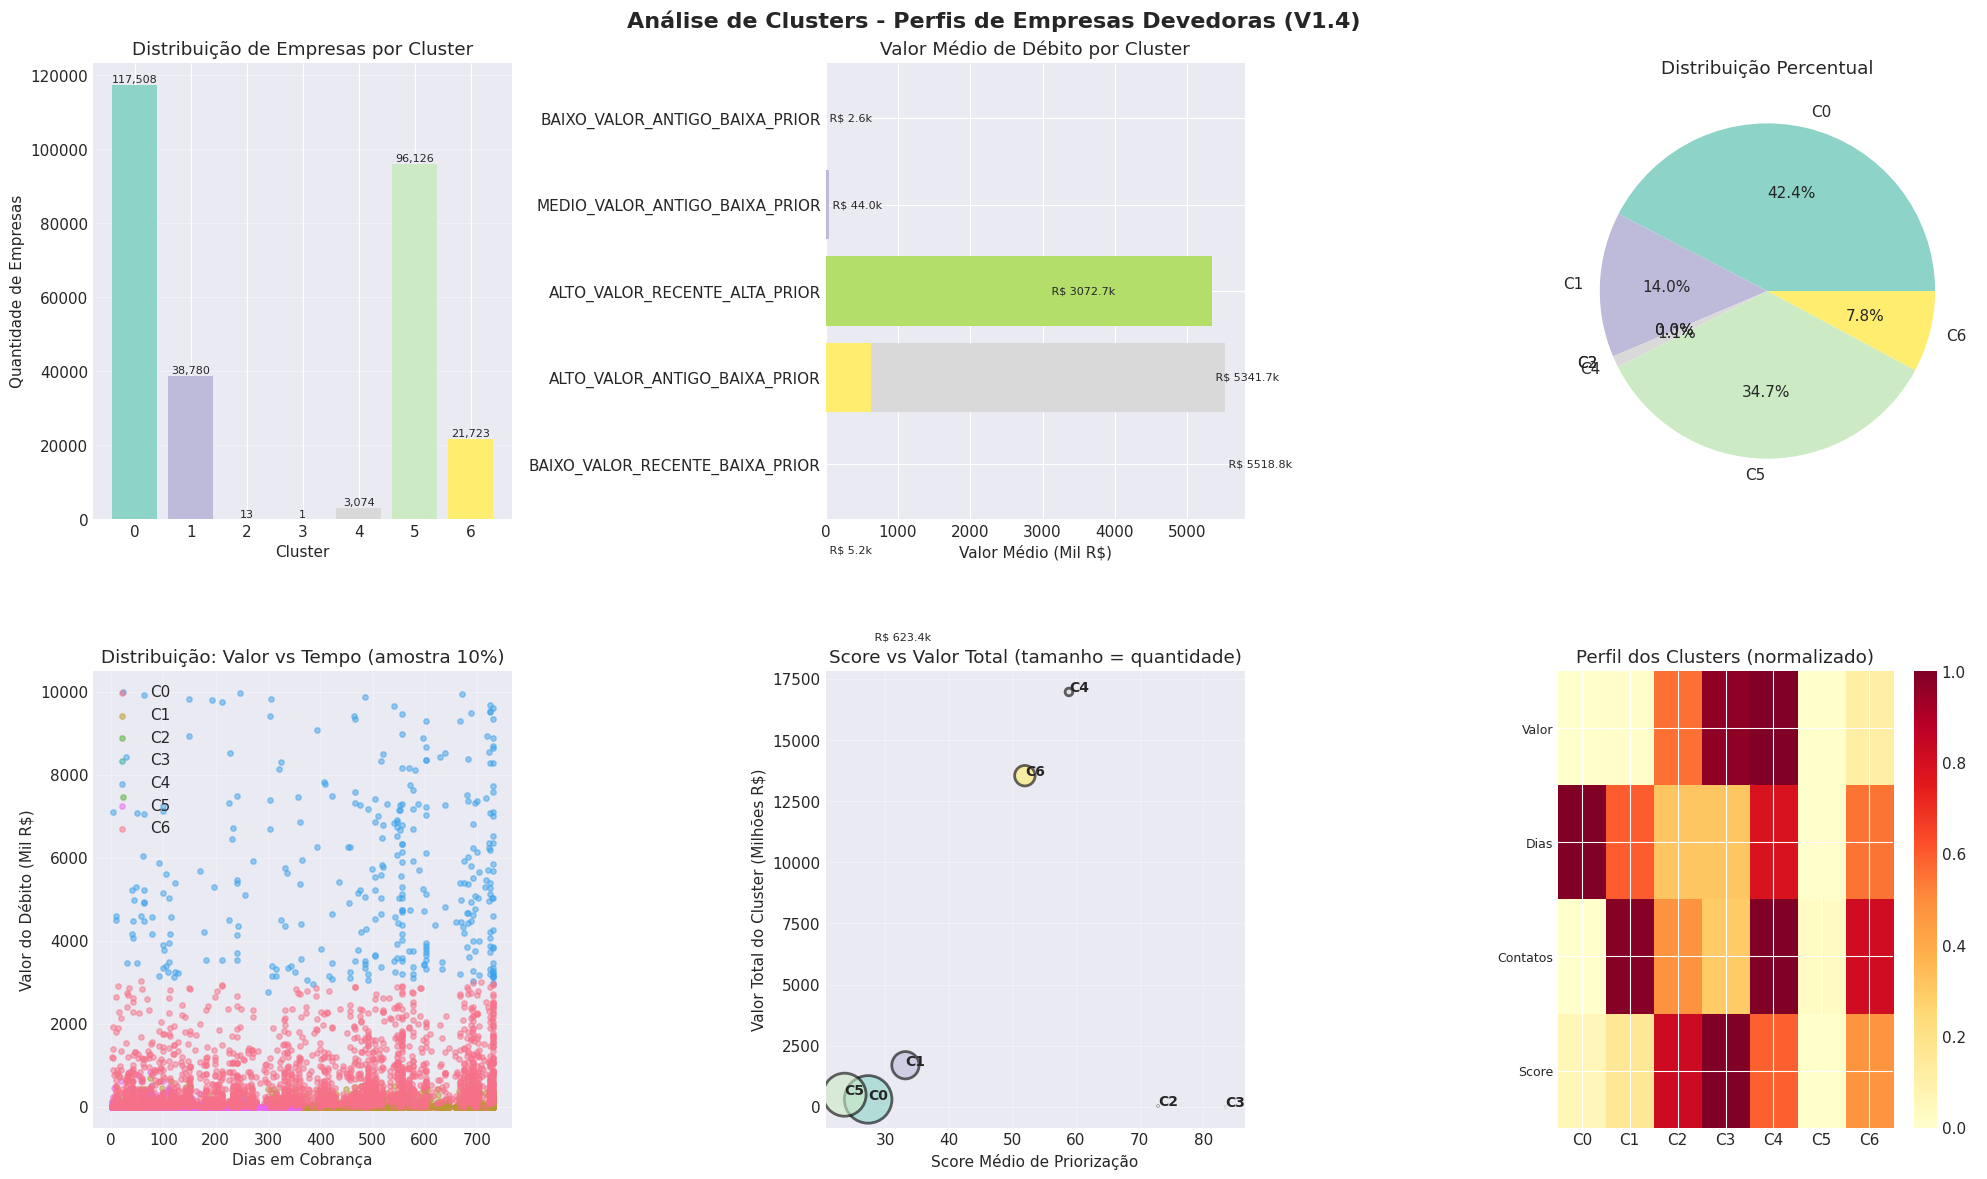

✅ Clustering concluído com TODOS os dados (V1.4)
  277,225 empresas agrupadas em 7 clusters
  Silhouette Score: 0.7394



In [23]:
# ============================================================================
# ANÁLISES AVANÇADAS SEM MACHINE LEARNING SUPERVISIONADO
# Sistema de Análise Inteligente - GECOB/SC
# ============================================================================
import builtins  # Para usar funções Python nativas
# ============================================================================
# CLUSTERING COMPLETO (CORRIGIDA - SEM CONFLITOS)
# ============================================================================
print("\n" + "=" * 80)
print("1. CLUSTERING DE EMPRESAS POR PADRÃO DE DÉBITO (K-MEANS)")
print("=" * 80)

# IMPORTANTE: Importar builtins
import builtins
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.functions import count as spark_count, avg as spark_avg, sum as spark_sum

print("\nCarregando TODOS os dados para clustering...")

# Query para features de clustering - ATUALIZADA V1.4
query_clustering = """
SELECT 
    mc.inscricao_estadual,
    mc.tipo_debito,
    CAST(mc.valor_total_devido AS DOUBLE) as valor_total,
    CAST(DATEDIFF(CURRENT_DATE(), mc.data_inclusao_cobranca) AS INT) as dias_cobranca,
    CAST(mc.qtd_total_contatos AS INT) as qtd_contatos,
    CAST(sp.score_final_priorizacao AS DOUBLE) as score_priorizacao,
    CAST(mc.saldo_imposto AS DOUBLE) as saldo_imposto,
    CAST(mc.saldo_multa AS DOUBLE) as saldo_multa,
    CAST(mc.saldo_juros AS DOUBLE) as saldo_juros
FROM gecob.prior_master_consolidado mc
INNER JOIN gecob.prior_score_priorizacao sp 
    ON mc.inscricao_estadual = sp.inscricao_estadual
    AND mc.tipo_debito = sp.tipo_debito
WHERE mc.valor_total_devido > 0
    AND mc.valor_total_devido < 10000000
"""

df_cluster = spark.sql(query_clustering)
total_records = df_cluster.count()
print(f"Dados carregados: {total_records:,} registros")

# Preparar features para clustering
features_cols = ['valor_total', 'dias_cobranca', 'qtd_contatos', 'score_priorizacao',
                 'saldo_imposto', 'saldo_multa', 'saldo_juros']

# Remover nulls
df_cluster_clean = df_cluster.na.fill(0)

# Assembler
assembler = VectorAssembler(inputCols=features_cols, outputCol='features_raw')
df_assembled = assembler.transform(df_cluster_clean)

# Normalizar
scaler = StandardScaler(inputCol='features_raw', outputCol='features', 
                       withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Testar diferentes valores de K
print("\nTestando diferentes números de clusters...")
silhouette_scores = []
k_values = range(3, 8)

for k in k_values:
    kmeans = KMeans(k=k, seed=42, featuresCol='features', predictionCol='cluster', maxIter=20)
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    
    evaluator = ClusteringEvaluator(featuresCol='features', 
                                    predictionCol='cluster',
                                    metricName='silhouette')
    silhouette = evaluator.evaluate(predictions)
    silhouette_scores.append(silhouette)
    print(f"  K={k}: Silhouette = {silhouette:.4f}")

# Melhor K
best_k = k_values[np.argmax(silhouette_scores)]
print(f"\n✅ Melhor número de clusters: K={best_k}")

# Treinar modelo final
print(f"\nTreinando modelo final com K={best_k}...")
kmeans_final = KMeans(k=best_k, seed=42, featuresCol='features', predictionCol='cluster', maxIter=20)
kmeans_model = kmeans_final.fit(df_scaled)
df_clustered = kmeans_model.transform(df_scaled)

# Analisar clusters
print(f"\n{'='*80}")
print("PERFIS DOS CLUSTERS IDENTIFICADOS:")
print(f"{'='*80}\n")

cluster_analysis = df_clustered.groupBy('cluster').agg(
    spark_count('*').alias('quantidade'),
    spark_avg('valor_total').alias('valor_medio'),
    spark_avg('dias_cobranca').alias('dias_medio'),
    spark_avg('qtd_contatos').alias('contatos_medio'),
    spark_avg('score_priorizacao').alias('score_medio'),
    spark_sum('valor_total').alias('valor_total_cluster')
).orderBy('cluster').toPandas()

# Converter para numérico
for col in cluster_analysis.columns:
    if col != 'cluster':
        cluster_analysis[col] = pd.to_numeric(cluster_analysis[col], errors='coerce')

# Nomear clusters baseado em características
def nomear_cluster(row):
    if row['valor_medio'] > 50000:
        nivel_valor = "ALTO_VALOR"
    elif row['valor_medio'] > 10000:
        nivel_valor = "MEDIO_VALOR"
    else:
        nivel_valor = "BAIXO_VALOR"
    
    if row['dias_medio'] > 365:
        nivel_tempo = "ANTIGO"
    else:
        nivel_tempo = "RECENTE"
    
    if row['score_medio'] > 60:
        nivel_risco = "ALTA_PRIOR"
    else:
        nivel_risco = "BAIXA_PRIOR"
    
    return f"{nivel_valor}_{nivel_tempo}_{nivel_risco}"

cluster_analysis['nome_cluster'] = cluster_analysis.apply(nomear_cluster, axis=1)

print(f"Total analisado: {cluster_analysis['quantidade'].sum():,.0f} empresas\n")

for idx, row in cluster_analysis.iterrows():
    print(f"CLUSTER {int(row['cluster'])}: {row['nome_cluster']}")
    print(f"  Quantidade: {int(row['quantidade']):,} empresas ({row['quantidade']/cluster_analysis['quantidade'].sum()*100:.1f}%)")
    print(f"  Valor Médio: R$ {row['valor_medio']:,.2f}")
    print(f"  Valor Total: R$ {row['valor_total_cluster']/1e6:.2f} milhões")
    print(f"  Dias Médios em Cobrança: {row['dias_medio']:.0f} dias")
    print(f"  Contatos Médios: {row['contatos_medio']:.1f}")
    print(f"  Score Médio: {row['score_medio']:.1f}")
    print()

# Salvar clusters identificados
print("Salvando resultados do clustering...")
df_clustered.select('inscricao_estadual', 'tipo_debito', 'cluster', 'valor_total', 
                    'dias_cobranca', 'score_priorizacao').write.mode('overwrite').saveAsTable(
    'gecob.prior_clusters_empresas')
print("✅ Resultados salvos em: gecob.prior_clusters_empresas\n")

# Visualização (mantida igual - não precisa correção)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Análise de Clusters - Perfis de Empresas Devedoras (V1.4)', fontsize=16, fontweight='bold')

# 1. Quantidade por cluster
axes[0, 0].bar(cluster_analysis['cluster'].astype(str), cluster_analysis['quantidade'], 
               color=plt.cm.Set3(np.linspace(0, 1, len(cluster_analysis))))
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].set_ylabel('Quantidade de Empresas')
axes[0, 0].set_title('Distribuição de Empresas por Cluster')
axes[0, 0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(cluster_analysis['quantidade']):
    axes[0, 0].text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=8)

# 2. Valor médio por cluster
axes[0, 1].barh(cluster_analysis['nome_cluster'], cluster_analysis['valor_medio']/1000, 
                color=plt.cm.Set3(np.linspace(0, 1, len(cluster_analysis))))
axes[0, 1].set_xlabel('Valor Médio (Mil R$)')
axes[0, 1].set_title('Valor Médio de Débito por Cluster')
axes[0, 1].invert_yaxis()
for i, v in enumerate(cluster_analysis['valor_medio']/1000):
    axes[0, 1].text(v, i, f' R$ {v:.1f}k', va='center', fontsize=8)

# 3. Pizza - Distribuição percentual
axes[0, 2].pie(cluster_analysis['quantidade'], 
               labels=[f"C{int(c)}" for c in cluster_analysis['cluster']], 
               autopct='%1.1f%%',
               colors=plt.cm.Set3(np.linspace(0, 1, len(cluster_analysis))))
axes[0, 2].set_title('Distribuição Percentual')

# 4. Scatter: Valor vs Dias (amostra)
print("Gerando visualização de scatter (amostra 10%)...")
sample_data = df_clustered.select('valor_total', 'dias_cobranca', 'cluster').sample(
    fraction=0.1, seed=42).toPandas()
sample_data['valor_total'] = pd.to_numeric(sample_data['valor_total'])
sample_data['dias_cobranca'] = pd.to_numeric(sample_data['dias_cobranca'])

for cluster_id in cluster_analysis['cluster']:
    cluster_data = sample_data[sample_data['cluster'] == cluster_id]
    axes[1, 0].scatter(cluster_data['dias_cobranca'], cluster_data['valor_total']/1000,
                      alpha=0.5, s=15, label=f'C{int(cluster_id)}')

axes[1, 0].set_xlabel('Dias em Cobrança')
axes[1, 0].set_ylabel('Valor do Débito (Mil R$)')
axes[1, 0].set_title('Distribuição: Valor vs Tempo (amostra 10%)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. Score médio vs Valor total do cluster
axes[1, 1].scatter(cluster_analysis['score_medio'], 
                   cluster_analysis['valor_total_cluster']/1e6,
                   s=cluster_analysis['quantidade']/100,
                   c=cluster_analysis['cluster'], cmap='Set3',
                   alpha=0.6, edgecolors='black', linewidth=2)
axes[1, 1].set_xlabel('Score Médio de Priorização')
axes[1, 1].set_ylabel('Valor Total do Cluster (Milhões R$)')
axes[1, 1].set_title('Score vs Valor Total (tamanho = quantidade)')
for idx, row in cluster_analysis.iterrows():
    axes[1, 1].annotate(f"C{int(row['cluster'])}", 
                       (row['score_medio'], row['valor_total_cluster']/1e6),
                       fontsize=10, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

# 6. Heatmap de características médias
features_heatmap = cluster_analysis[['cluster', 'valor_medio', 'dias_medio', 
                                     'contatos_medio', 'score_medio']].set_index('cluster')
# Normalizar para heatmap
features_norm = (features_heatmap - features_heatmap.min()) / (features_heatmap.max() - features_heatmap.min())
im = axes[1, 2].imshow(features_norm.T, cmap='YlOrRd', aspect='auto')
axes[1, 2].set_xticks(range(len(cluster_analysis)))
axes[1, 2].set_xticklabels([f"C{int(c)}" for c in cluster_analysis['cluster']])
axes[1, 2].set_yticks(range(len(features_norm.columns)))
axes[1, 2].set_yticklabels(['Valor', 'Dias', 'Contatos', 'Score'], fontsize=9)
axes[1, 2].set_title('Perfil dos Clusters (normalizado)')
plt.colorbar(im, ax=axes[1, 2])

plt.tight_layout()
plt.show()

print(f"{'='*80}")
print("✅ Clustering concluído com TODOS os dados (V1.4)")
print(f"  {total_records:,} empresas agrupadas em {best_k} clusters")
# CORRIGIDO: Usar builtins.max
print(f"  Silhouette Score: {builtins.max(silhouette_scores):.4f}")
print(f"{'='*80}\n")


2. ANÁLISE DE OUTLIERS - CASOS ATÍPICOS

Identificando outliers por múltiplos critérios...

Carregando dados...
✅ Dados carregados: 279,490 registros
✅ Após limpeza: 279,490 registros válidos

ESTATÍSTICAS DESCRITIVAS:
       valor_devido  dias_cobranca   qtd_contatos          score
count  2.794900e+05  279490.000000  279490.000000  279490.000000
mean   5.236933e+05     377.145544     536.923199      29.417426
std    1.460773e+07     253.963459     962.708904       9.580647
min    3.570000e+00       1.000000       0.000000      12.500000
25%    5.028725e+02      95.000000       0.000000      23.000000
50%    1.061430e+03     430.000000       0.000000      27.000000
75%    4.909302e+03     556.000000     461.000000      29.750000
max    4.643247e+09     731.000000    8048.000000      84.900000

DETECÇÃO POR IQR (Interquartile Range)

valor_devido:
  Q1: 502.87 | Q3: 4,909.30 | IQR: 4,406.43
  Limites: [-12,716.42, 18,128.59]
  Outliers: 48,012 (17.18%)
  Range: 18,130.80 a 4,643,247,42

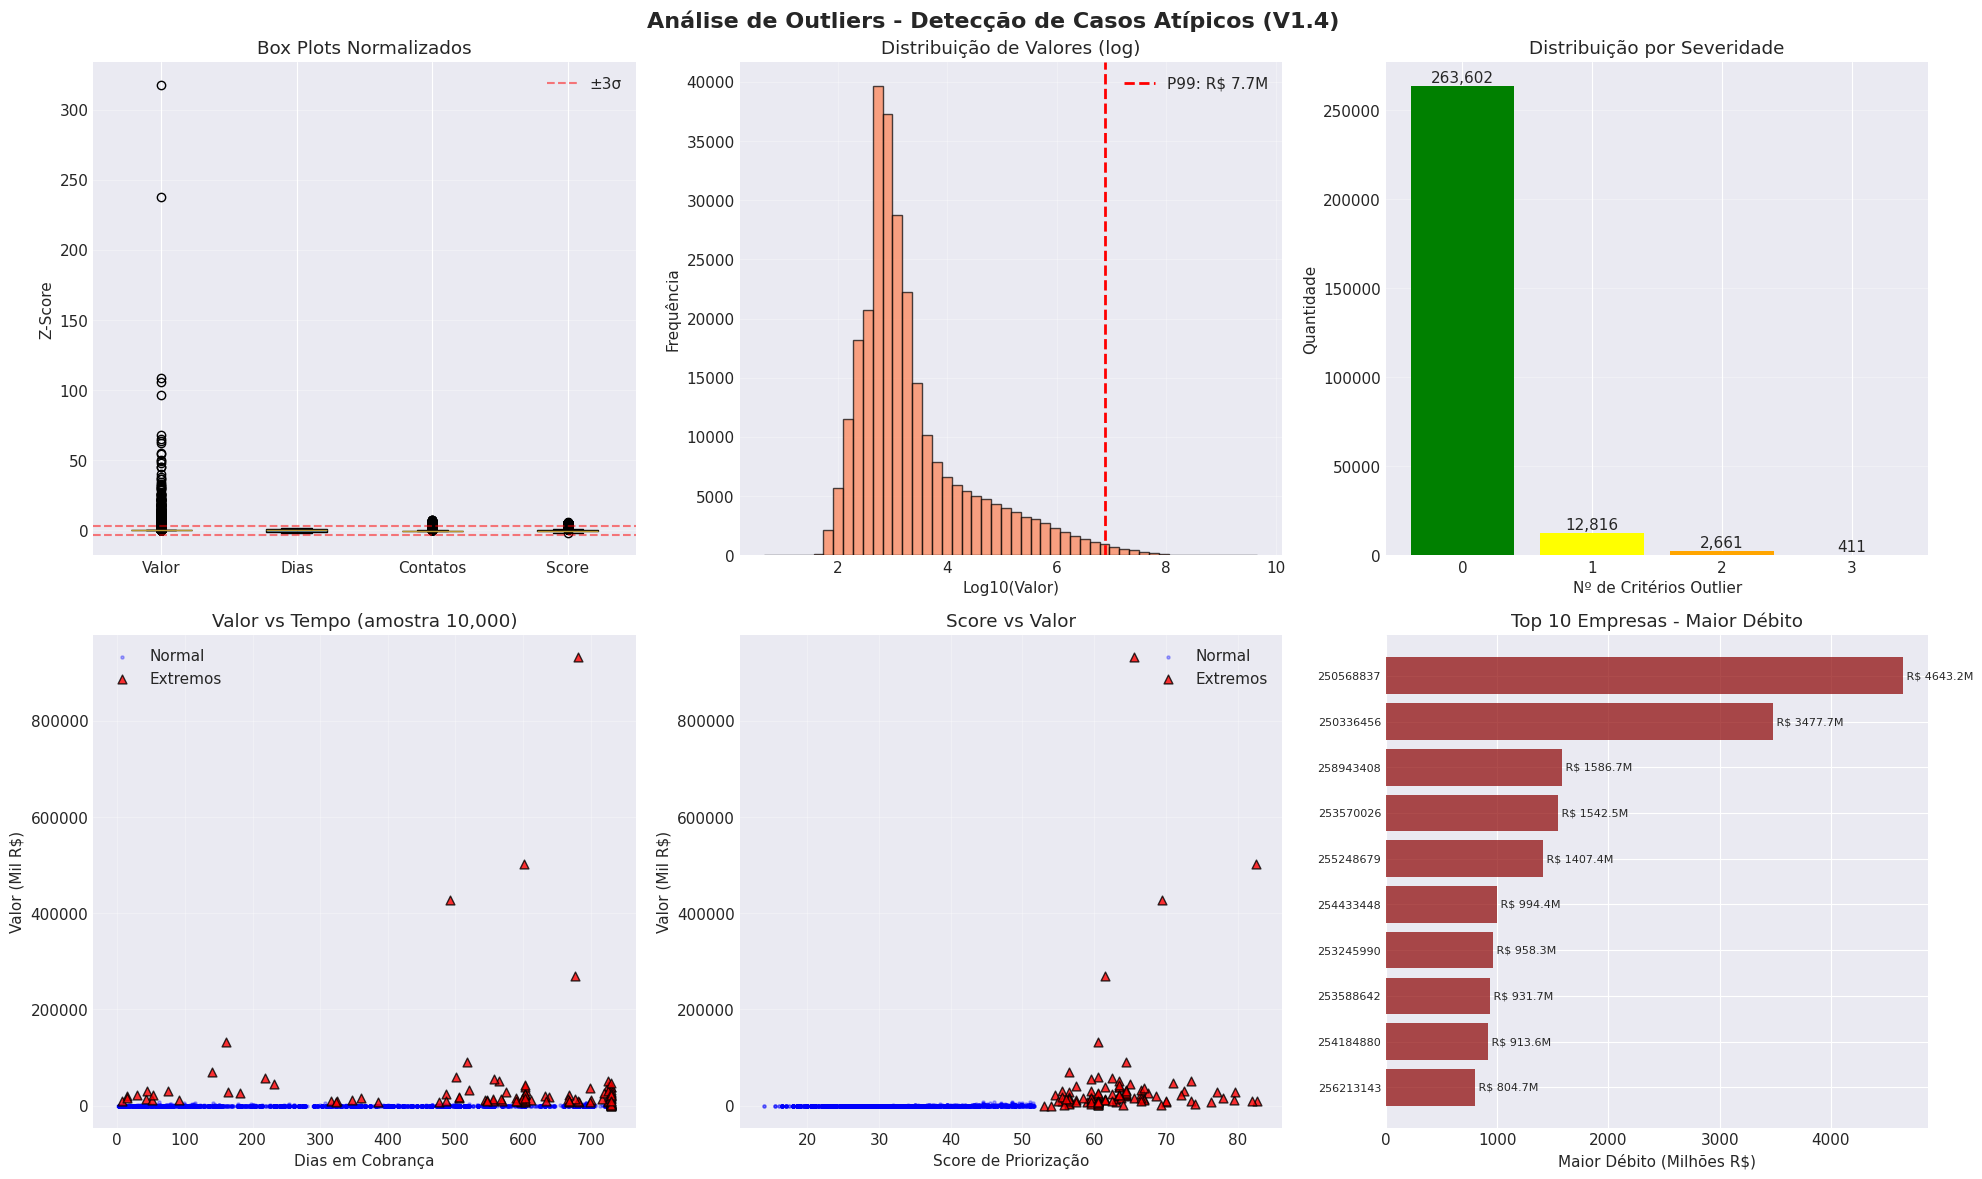


Salvando casos extremos identificados...
✅ 2,470 empresas extremas salvas em: gecob.prior_outliers_identificados

RESUMO DA ANÁLISE DE OUTLIERS:
  Total analisado: 279,490 débitos
  Débitos extremos (2+ critérios): 3,072 (1.10%)
  Empresas únicas com casos extremos: 2,470
  Maior débito: R$ 4,643,247,426.24
  Débito mais antigo: 731 dias
  Score máximo: 84.9


In [24]:
# ============================================================================
# ANÁLISE DE OUTLIERS - CASOS ATÍPICOS (CORRIGIDA - SEM CONFLITOS)
# ============================================================================
print("\n" + "=" * 80)
print("2. ANÁLISE DE OUTLIERS - CASOS ATÍPICOS")
print("=" * 80)

# IMPORTANTE: Importar funções nativas Python com alias
import builtins

print("\nIdentificando outliers por múltiplos critérios...\n")

# Query para análise de outliers - ATUALIZADA V1.4
query_outliers = """
SELECT 
    mc.inscricao_estadual,
    mc.tipo_debito,
    mc.razao_social,
    CAST(mc.valor_total_devido AS DOUBLE) as valor_devido,
    CAST(DATEDIFF(CURRENT_DATE(), mc.data_inclusao_cobranca) AS INT) as dias_cobranca,
    CAST(mc.qtd_total_contatos AS INT) as qtd_contatos,
    CAST(sp.score_final_priorizacao AS DOUBLE) as score,
    mc.situacao_cadastral_desc,
    CAST(mc.flag_falencia AS INT) as flag_falencia,
    CAST(mc.flag_recuperacao_judicial AS INT) as flag_recuperacao_judicial,
    CAST(mc.flag_devedor_contumaz AS INT) as flag_devedor_contumaz
FROM gecob.prior_master_consolidado mc
INNER JOIN gecob.prior_score_priorizacao sp 
    ON mc.inscricao_estadual = sp.inscricao_estadual
    AND mc.tipo_debito = sp.tipo_debito
WHERE mc.valor_total_devido > 0
"""

print("Carregando dados...")
df_outliers = spark.sql(query_outliers).toPandas()

if len(df_outliers) == 0:
    print("❌ ERRO: Nenhum dado retornado pela query!")
    print("Verifique se as tabelas têm dados e se o join está correto")
else:
    print(f"✅ Dados carregados: {len(df_outliers):,} registros")
    
    # Converter para numérico
    numeric_cols = ['valor_devido', 'dias_cobranca', 'qtd_contatos', 'score']
    for col in numeric_cols:
        df_outliers[col] = pd.to_numeric(df_outliers[col], errors='coerce')
    
    # Remover nulls
    df_outliers_clean = df_outliers.dropna(subset=numeric_cols)
    
    if len(df_outliers_clean) == 0:
        print("❌ ERRO: Todos os registros têm valores nulos nas features numéricas")
    else:
        print(f"✅ Após limpeza: {len(df_outliers_clean):,} registros válidos\n")
        
        # Estatísticas básicas
        print("="*80)
        print("ESTATÍSTICAS DESCRITIVAS:")
        print("="*80)
        print(df_outliers_clean[numeric_cols].describe())
        
        # Método 1: IQR (Interquartile Range)
        print(f"\n{'='*80}")
        print("DETECÇÃO POR IQR (Interquartile Range)")
        print("="*80)
        
        outliers_dict = {}
        
        for col in numeric_cols:
            Q1 = df_outliers_clean[col].quantile(0.25)
            Q3 = df_outliers_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            
            if IQR == 0:
                print(f"\n⚠️  {col}: IQR=0 (sem variabilidade), pulando...")
                continue
            
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            outliers = df_outliers_clean[
                (df_outliers_clean[col] < lower_bound) | 
                (df_outliers_clean[col] > upper_bound)
            ]
            outliers_dict[col] = outliers
            
            print(f"\n{col}:")
            print(f"  Q1: {Q1:,.2f} | Q3: {Q3:,.2f} | IQR: {IQR:,.2f}")
            print(f"  Limites: [{lower_bound:,.2f}, {upper_bound:,.2f}]")
            print(f"  Outliers: {len(outliers):,} ({len(outliers)/len(df_outliers_clean)*100:.2f}%)")
            
            if len(outliers) > 0:
                print(f"  Range: {outliers[col].min():,.2f} a {outliers[col].max():,.2f}")
        
        # Método 2: Percentis (mais robusto)
        print(f"\n{'='*80}")
        print("DETECÇÃO POR PERCENTIS (P99)")
        print("="*80)
        
        outliers_percentil = {}
        
        for col in numeric_cols:
            p99 = df_outliers_clean[col].quantile(0.99)
            p01 = df_outliers_clean[col].quantile(0.01)
            
            outliers = df_outliers_clean[
                (df_outliers_clean[col] > p99) | 
                (df_outliers_clean[col] < p01)
            ]
            outliers_percentil[col] = outliers
            
            print(f"\n{col}:")
            print(f"  P01: {p01:,.2f} | P99: {p99:,.2f}")
            print(f"  Outliers (fora P01-P99): {len(outliers):,} ({len(outliers)/len(df_outliers_clean)*100:.2f}%)")
        
        # Identificar casos extremos (múltiplos critérios)
        print(f"\n{'='*80}")
        print("CASOS EXTREMOS - MÚLTIPLOS CRITÉRIOS")
        print("="*80)
        
        # Marcar outliers
        df_outliers_clean['outlier_valor'] = df_outliers_clean['valor_devido'] > df_outliers_clean['valor_devido'].quantile(0.99)
        df_outliers_clean['outlier_tempo'] = df_outliers_clean['dias_cobranca'] > df_outliers_clean['dias_cobranca'].quantile(0.99)
        df_outliers_clean['outlier_score'] = df_outliers_clean['score'] > df_outliers_clean['score'].quantile(0.95)
        
        df_outliers_clean['qtd_outliers'] = (
            df_outliers_clean['outlier_valor'].astype(int) +
            df_outliers_clean['outlier_tempo'].astype(int) +
            df_outliers_clean['outlier_score'].astype(int)
        )
        
        casos_extremos = df_outliers_clean[
            df_outliers_clean['qtd_outliers'] >= 2
        ].sort_values('valor_devido', ascending=False)
        
        print(f"\nTotal de casos extremos (2+ critérios): {len(casos_extremos):,}")
        print(f"Percentual do total: {len(casos_extremos)/len(df_outliers_clean)*100:.2f}%\n")
        
        # Top 20 Únicos (sem repetição) - CORRIGIDO
        top20_unicos = casos_extremos.drop_duplicates(subset=['inscricao_estadual']).head(20)
        
        print(f"Top 20 Empresas com Casos Mais Críticos (sem repetição):\n")
        print(f"{'#':<3} {'IE':<15} {'Tipo':<10} {'Razão Social':<30} {'Maior Valor':<18} {'Débitos':<8} {'Score Méd':<9}")
        print("="*110)
        
        for idx, (i, row) in enumerate(top20_unicos.iterrows(), 1):
            razao = str(row['razao_social'])[:28] if pd.notna(row['razao_social']) else 'N/A'
            
            # CORRIGIDO: tipo_debito pode ser Series, converter para string
            tipo_val = row['tipo_debito']
            if isinstance(tipo_val, pd.Series):
                tipo_val = tipo_val.iloc[0] if len(tipo_val) > 0 else 'N/A'
            tipo = str(tipo_val)[:8] if pd.notna(tipo_val) else 'N/A'
            
            # Contar quantos débitos essa empresa tem
            debitos_empresa = casos_extremos[casos_extremos['inscricao_estadual'] == row['inscricao_estadual']]
            qtd_debitos = len(debitos_empresa)
            score_medio = debitos_empresa['score'].mean()
            
            print(f"{idx:<3} {row['inscricao_estadual']:<15} {tipo:<10} {razao:<30} "
                  f"R$ {row['valor_devido']:>13,.2f} {qtd_debitos:>7} {score_medio:>8.1f}")
        
        # Visualização
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle('Análise de Outliers - Detecção de Casos Atípicos (V1.4)', 
                     fontsize=16, fontweight='bold')
        
        # 1. Box plots
        df_norm = df_outliers_clean[numeric_cols].copy()
        for col in numeric_cols:
            if df_norm[col].std() > 0:
                df_norm[col] = (df_norm[col] - df_norm[col].mean()) / df_norm[col].std()
        
        bp = axes[0, 0].boxplot([df_norm[col].dropna() for col in numeric_cols],
                                labels=['Valor', 'Dias', 'Contatos', 'Score'],
                                patch_artist=True, showfliers=True)
        
        colors_box = ['coral', 'steelblue', 'lightgreen', 'gold']
        for patch, color in zip(bp['boxes'], colors_box):
            patch.set_facecolor(color)
        
        axes[0, 0].set_title('Box Plots Normalizados')
        axes[0, 0].set_ylabel('Z-Score')
        axes[0, 0].axhline(y=3, color='red', linestyle='--', alpha=0.5, label='±3σ')
        axes[0, 0].axhline(y=-3, color='red', linestyle='--', alpha=0.5)
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3, axis='y')
        
        # 2. Histograma log
        axes[0, 1].hist(np.log10(df_outliers_clean['valor_devido']+1), 
                       bins=50, color='coral', edgecolor='black', alpha=0.7)
        axes[0, 1].set_xlabel('Log10(Valor)')
        axes[0, 1].set_ylabel('Frequência')
        axes[0, 1].set_title('Distribuição de Valores (log)')
        p99 = df_outliers_clean['valor_devido'].quantile(0.99)
        axes[0, 1].axvline(np.log10(p99), color='red', linestyle='--', 
                          linewidth=2, label=f'P99: R$ {p99/1e6:.1f}M')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Distribuição de outliers
        outlier_dist = df_outliers_clean['qtd_outliers'].value_counts().sort_index()
        colors_sev = ['green', 'yellow', 'orange', 'red']
        axes[0, 2].bar(outlier_dist.index, outlier_dist.values,
                      color=[colors_sev[int(i)] for i in outlier_dist.index])
        axes[0, 2].set_xlabel('Nº de Critérios Outlier')
        axes[0, 2].set_ylabel('Quantidade')
        axes[0, 2].set_title('Distribuição por Severidade')
        axes[0, 2].set_xticks(outlier_dist.index)
        for i, v in enumerate(outlier_dist.values):
            axes[0, 2].text(outlier_dist.index[i], v, f'{v:,}', 
                           ha='center', va='bottom')
        axes[0, 2].grid(True, alpha=0.3, axis='y')
        
        # 4. Scatter Valor vs Dias - CORRIGIDO com builtins.min
        sample_size = builtins.min(10000, len(df_outliers_clean))
        sample = df_outliers_clean.sample(n=sample_size, random_state=42)
        
        normal = sample[sample['qtd_outliers'] == 0]
        extremos = sample[sample['qtd_outliers'] >= 2]
        
        axes[1, 0].scatter(normal['dias_cobranca'], normal['valor_devido']/1000,
                          alpha=0.3, s=5, c='blue', label='Normal')
        axes[1, 0].scatter(extremos['dias_cobranca'], extremos['valor_devido']/1000,
                          alpha=0.8, s=40, c='red', marker='^', 
                          edgecolors='black', linewidth=1, label='Extremos')
        axes[1, 0].set_xlabel('Dias em Cobrança')
        axes[1, 0].set_ylabel('Valor (Mil R$)')
        axes[1, 0].set_title(f'Valor vs Tempo (amostra {sample_size:,})')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Scatter Score vs Valor
        axes[1, 1].scatter(normal['score'], normal['valor_devido']/1000,
                          alpha=0.3, s=5, c='blue', label='Normal')
        axes[1, 1].scatter(extremos['score'], extremos['valor_devido']/1000,
                          alpha=0.8, s=40, c='red', marker='^',
                          edgecolors='black', linewidth=1, label='Extremos')
        axes[1, 1].set_xlabel('Score de Priorização')
        axes[1, 1].set_ylabel('Valor (Mil R$)')
        axes[1, 1].set_title('Score vs Valor')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Top 10 maiores valores (empresas únicas)
        top10_empresas = top20_unicos.head(10)
        axes[1, 2].barh(range(len(top10_empresas)), top10_empresas['valor_devido']/1e6, 
                       color='darkred', alpha=0.7)
        axes[1, 2].set_yticks(range(len(top10_empresas)))
        axes[1, 2].set_yticklabels([str(ie)[:12] for ie in top10_empresas['inscricao_estadual']], 
                                   fontsize=8)
        axes[1, 2].set_xlabel('Maior Débito (Milhões R$)')
        axes[1, 2].set_title('Top 10 Empresas - Maior Débito')
        axes[1, 2].invert_yaxis()
        for i, v in enumerate(top10_empresas['valor_devido']/1e6):
            axes[1, 2].text(v, i, f' R$ {v:.1f}M', va='center', fontsize=8)
        
        plt.tight_layout()
        plt.show()
        
        # Salvar outliers identificados (empresas únicas)
        print("\n" + "="*80)
        print("Salvando casos extremos identificados...")
        
        casos_unicos = casos_extremos.drop_duplicates(subset=['inscricao_estadual'])
        
        casos_extremos_spark = spark.createDataFrame(
            casos_unicos[['inscricao_estadual', 'tipo_debito', 'valor_devido', 'dias_cobranca', 
                         'score', 'qtd_outliers']]
        )
        casos_extremos_spark.write.mode('overwrite').saveAsTable(
            'gecob.prior_outliers_identificados')
        
        print(f"✅ {len(casos_unicos):,} empresas extremas salvas em: gecob.prior_outliers_identificados")
        
        # Resumo
        print("\n" + "="*80)
        print("RESUMO DA ANÁLISE DE OUTLIERS:")
        print("="*80)
        print(f"  Total analisado: {len(df_outliers_clean):,} débitos")
        print(f"  Débitos extremos (2+ critérios): {len(casos_extremos):,} ({len(casos_extremos)/len(df_outliers_clean)*100:.2f}%)")
        print(f"  Empresas únicas com casos extremos: {len(casos_unicos):,}")
        print(f"  Maior débito: R$ {df_outliers_clean['valor_devido'].max():,.2f}")
        print(f"  Débito mais antigo: {df_outliers_clean['dias_cobranca'].max():.0f} dias")
        print(f"  Score máximo: {df_outliers_clean['score'].max():.1f}")
        print("="*80)

In [20]:
# ============================================================================
# ANÁLISES SQL AVANÇADAS - CLUSTERS E OUTLIERS
# ============================================================================

print("\n" + "=" * 80)
print("ANÁLISES SQL AVANÇADAS - SISTEMA DE PRIORIZAÇÃO GECOB/SC")
print("=" * 80)

# ============================================================================
# PARTE 1: ANÁLISES DA TABELA CLUSTERS
# ============================================================================

print("\n" + "=" * 80)
print("1. ANÁLISES DOS CLUSTERS IDENTIFICADOS")
print("=" * 80)

# 1.1 - Estatísticas Globais por Cluster
print("\n1.1 - ESTATÍSTICAS GLOBAIS POR CLUSTER\n")

query_stats_clusters = """
SELECT 
    cluster,
    
    -- Volumetria
    COUNT(DISTINCT inscricao_estadual) as qtd_empresas,
    COUNT(*) as qtd_total_registros,
    
    -- Estatísticas de Valor
    SUM(valor_total) as valor_total_cluster,
    AVG(valor_total) as valor_medio,
    MIN(valor_total) as valor_minimo,
    MAX(valor_total) as valor_maximo,
    STDDEV(valor_total) as desvio_padrao_valor,
    PERCENTILE(valor_total, 0.25) as p25_valor,
    PERCENTILE(valor_total, 0.50) as mediana_valor,
    PERCENTILE(valor_total, 0.75) as p75_valor,
    PERCENTILE(valor_total, 0.95) as p95_valor,
    
    -- Estatísticas de Tempo
    AVG(dias_cobranca) as dias_medio,
    MIN(dias_cobranca) as dias_minimo,
    MAX(dias_cobranca) as dias_maximo,
    STDDEV(dias_cobranca) as desvio_padrao_dias,
    PERCENTILE(dias_cobranca, 0.50) as mediana_dias,
    
    -- Estatísticas de Score
    AVG(score_priorizacao) as score_medio,
    MIN(score_priorizacao) as score_minimo,
    MAX(score_priorizacao) as score_maximo,
    STDDEV(score_priorizacao) as desvio_padrao_score,
    PERCENTILE(score_priorizacao, 0.50) as mediana_score,
    
    -- Concentração
    SUM(valor_total) / (SELECT SUM(valor_total) FROM gecob.prior_clusters_empresas) * 100 as pct_valor_total,
    COUNT(*) / (SELECT COUNT(*) FROM gecob.prior_clusters_empresas) * 100 as pct_registros

FROM gecob.prior_clusters_empresas
GROUP BY cluster
ORDER BY cluster
"""

df_stats_clusters = spark.sql(query_stats_clusters).toPandas()

# Converter para numérico
for col in df_stats_clusters.columns:
    if col != 'cluster':
        df_stats_clusters[col] = pd.to_numeric(df_stats_clusters[col], errors='coerce')

print(df_stats_clusters.to_string(index=False))

# 1.2 - Análise de Concentração (Curva ABC)
print("\n1.2 - ANÁLISE DE CONCENTRAÇÃO (CURVA ABC)\n")

query_abc = """
SELECT 
    cluster,
    COUNT(DISTINCT inscricao_estadual) as empresas,
    SUM(valor_total) as valor_cluster,
    SUM(SUM(valor_total)) OVER (ORDER BY SUM(valor_total) DESC) as valor_acumulado,
    SUM(valor_total) / SUM(SUM(valor_total)) OVER () * 100 as pct_valor,
    SUM(SUM(valor_total)) OVER (ORDER BY SUM(valor_total) DESC) / 
        SUM(SUM(valor_total)) OVER () * 100 as pct_acumulado,
    CASE 
        WHEN SUM(SUM(valor_total)) OVER (ORDER BY SUM(valor_total) DESC) / 
             SUM(SUM(valor_total)) OVER () <= 0.80 THEN 'A - Alta Prioridade'
        WHEN SUM(SUM(valor_total)) OVER (ORDER BY SUM(valor_total) DESC) / 
             SUM(SUM(valor_total)) OVER () <= 0.95 THEN 'B - Média Prioridade'
        ELSE 'C - Baixa Prioridade'
    END as classe_abc
FROM gecob.prior_clusters_empresas
GROUP BY cluster
ORDER BY valor_cluster DESC
"""

df_abc = spark.sql(query_abc).toPandas()
for col in df_abc.columns:
    if col not in ['cluster', 'classe_abc']:
        df_abc[col] = pd.to_numeric(df_abc[col], errors='coerce')

print(df_abc.to_string(index=False))

# 1.3 - Segmentação por Faixas de Valor
print("\n1.3 - SEGMENTAÇÃO POR FAIXAS DE VALOR\n")

query_faixas = """
SELECT 
    cluster,
    CASE 
        WHEN valor_total < 1000 THEN '1. Até R$ 1k'
        WHEN valor_total < 10000 THEN '2. R$ 1k a 10k'
        WHEN valor_total < 50000 THEN '3. R$ 10k a 50k'
        WHEN valor_total < 100000 THEN '4. R$ 50k a 100k'
        WHEN valor_total < 500000 THEN '5. R$ 100k a 500k'
        WHEN valor_total < 1000000 THEN '6. R$ 500k a 1M'
        ELSE '7. Acima de R$ 1M'
    END as faixa_valor,
    
    COUNT(DISTINCT inscricao_estadual) as empresas,
    COUNT(*) as debitos,
    SUM(valor_total) as valor_total_faixa,
    AVG(valor_total) as valor_medio_faixa,
    AVG(dias_cobranca) as dias_medio_faixa,
    AVG(score_priorizacao) as score_medio_faixa

FROM gecob.prior_clusters_empresas
GROUP BY cluster, 
    CASE 
        WHEN valor_total < 1000 THEN '1. Até R$ 1k'
        WHEN valor_total < 10000 THEN '2. R$ 1k a 10k'
        WHEN valor_total < 50000 THEN '3. R$ 10k a 50k'
        WHEN valor_total < 100000 THEN '4. R$ 50k a 100k'
        WHEN valor_total < 500000 THEN '5. R$ 100k a 500k'
        WHEN valor_total < 1000000 THEN '6. R$ 500k a 1M'
        ELSE '7. Acima de R$ 1M'
    END
ORDER BY cluster, faixa_valor
"""

df_faixas = spark.sql(query_faixas).toPandas()
for col in df_faixas.columns:
    if col not in ['cluster', 'faixa_valor']:
        df_faixas[col] = pd.to_numeric(df_faixas[col], errors='coerce')

print(df_faixas.to_string(index=False))

# 1.4 - Análise Temporal (Aging)
print("\n1.4 - ANÁLISE TEMPORAL (AGING DE DÉBITOS)\n")

query_aging = """
SELECT 
    cluster,
    CASE 
        WHEN dias_cobranca <= 30 THEN '1. 0-30 dias'
        WHEN dias_cobranca <= 90 THEN '2. 31-90 dias'
        WHEN dias_cobranca <= 180 THEN '3. 91-180 dias'
        WHEN dias_cobranca <= 365 THEN '4. 181-365 dias'
        WHEN dias_cobranca <= 730 THEN '5. 1-2 anos'
        ELSE '6. Mais de 2 anos'
    END as faixa_aging,
    
    COUNT(DISTINCT inscricao_estadual) as empresas,
    COUNT(*) as debitos,
    SUM(valor_total) as valor_total,
    AVG(valor_total) as valor_medio,
    AVG(score_priorizacao) as score_medio,
    
    -- Percentual dentro do cluster
    COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY cluster) as pct_debitos_cluster

FROM gecob.prior_clusters_empresas
GROUP BY cluster,
    CASE 
        WHEN dias_cobranca <= 30 THEN '1. 0-30 dias'
        WHEN dias_cobranca <= 90 THEN '2. 31-90 dias'
        WHEN dias_cobranca <= 180 THEN '3. 91-180 dias'
        WHEN dias_cobranca <= 365 THEN '4. 181-365 dias'
        WHEN dias_cobranca <= 730 THEN '5. 1-2 anos'
        ELSE '6. Mais de 2 anos'
    END
ORDER BY cluster, faixa_aging
"""

df_aging = spark.sql(query_aging).toPandas()
for col in df_aging.columns:
    if col not in ['cluster', 'faixa_aging']:
        df_aging[col] = pd.to_numeric(df_aging[col], errors='coerce')

print(df_aging.to_string(index=False))

# 1.5 - Top Empresas por Cluster
print("\n1.5 - TOP 10 EMPRESAS POR CLUSTER (MAIOR VALOR TOTAL)\n")

query_top_clusters = """
WITH empresas_totais AS (
    SELECT 
        cluster,
        inscricao_estadual,
        COUNT(*) as qtd_debitos,
        SUM(valor_total) as valor_total_empresa,
        AVG(dias_cobranca) as dias_medio,
        AVG(score_priorizacao) as score_medio,
        MIN(valor_total) as menor_debito,
        MAX(valor_total) as maior_debito
    FROM gecob.prior_clusters_empresas
    GROUP BY cluster, inscricao_estadual
),
ranked AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (PARTITION BY cluster ORDER BY valor_total_empresa DESC) as rank
    FROM empresas_totais
)
SELECT 
    cluster,
    rank,
    inscricao_estadual,
    qtd_debitos,
    valor_total_empresa,
    dias_medio,
    score_medio,
    menor_debito,
    maior_debito
FROM ranked
WHERE rank <= 10
ORDER BY cluster, rank
"""

df_top_clusters = spark.sql(query_top_clusters).toPandas()
for col in df_top_clusters.columns:
    if col not in ['cluster', 'inscricao_estadual']:
        df_top_clusters[col] = pd.to_numeric(df_top_clusters[col], errors='coerce')

print(df_top_clusters.to_string(index=False))

# ============================================================================
# PARTE 2: ANÁLISES DA TABELA OUTLIERS
# ============================================================================

print("\n" + "=" * 80)
print("2. ANÁLISES DOS OUTLIERS IDENTIFICADOS")
print("=" * 80)

# 2.1 - Estatísticas Globais de Outliers
print("\n2.1 - ESTATÍSTICAS GLOBAIS DOS OUTLIERS\n")

query_stats_outliers = """
SELECT 
    -- Severidade
    qtd_outliers as nivel_severidade,
    
    -- Volumetria
    COUNT(DISTINCT inscricao_estadual) as empresas,
    
    -- Estatísticas de Valor
    SUM(valor_devido) as valor_total,
    AVG(valor_devido) as valor_medio,
    MIN(valor_devido) as valor_minimo,
    MAX(valor_devido) as valor_maximo,
    STDDEV(valor_devido) as desvio_padrao_valor,
    PERCENTILE(valor_devido, 0.50) as mediana_valor,
    PERCENTILE(valor_devido, 0.95) as p95_valor,
    
    -- Estatísticas de Tempo
    AVG(dias_cobranca) as dias_medio,
    MIN(dias_cobranca) as dias_minimo,
    MAX(dias_cobranca) as dias_maximo,
    PERCENTILE(dias_cobranca, 0.50) as mediana_dias,
    
    -- Estatísticas de Score
    AVG(score) as score_medio,
    MIN(score) as score_minimo,
    MAX(score) as score_maximo,
    PERCENTILE(score, 0.50) as mediana_score,
    
    -- Concentração
    SUM(valor_devido) / (SELECT SUM(valor_devido) FROM gecob.prior_outliers_identificados) * 100 as pct_valor_total

FROM gecob.prior_outliers_identificados
GROUP BY qtd_outliers
ORDER BY qtd_outliers DESC
"""

df_stats_outliers = spark.sql(query_stats_outliers).toPandas()
for col in df_stats_outliers.columns:
    if col != 'nivel_severidade':
        df_stats_outliers[col] = pd.to_numeric(df_stats_outliers[col], errors='coerce')

print(df_stats_outliers.to_string(index=False))

# 2.2 - Top 20 Outliers Mais Críticos
print("\n2.2 - TOP 20 OUTLIERS MAIS CRÍTICOS\n")

query_top_outliers = """
SELECT 
    ROW_NUMBER() OVER (ORDER BY valor_devido DESC) as rank,
    inscricao_estadual,
    valor_devido,
    dias_cobranca,
    score,
    qtd_outliers as severidade,
    
    -- Classificação de risco
    CASE 
        WHEN valor_devido > 100000000 THEN 'CRÍTICO - Acima de R$ 100M'
        WHEN valor_devido > 50000000 THEN 'MUITO ALTO - R$ 50M a 100M'
        WHEN valor_devido > 10000000 THEN 'ALTO - R$ 10M a 50M'
        WHEN valor_devido > 1000000 THEN 'MÉDIO-ALTO - R$ 1M a 10M'
        ELSE 'MÉDIO - Até R$ 1M'
    END as classificacao_risco,
    
    -- Urgência temporal
    CASE 
        WHEN dias_cobranca > 730 THEN 'URGENTE - Mais de 2 anos'
        WHEN dias_cobranca > 365 THEN 'ALTA - 1 a 2 anos'
        WHEN dias_cobranca > 180 THEN 'MÉDIA - 6 meses a 1 ano'
        ELSE 'RECENTE - Até 6 meses'
    END as urgencia_temporal

FROM gecob.prior_outliers_identificados
ORDER BY valor_devido DESC
LIMIT 20
"""

df_top_outliers = spark.sql(query_top_outliers).toPandas()
for col in df_top_outliers.columns:
    if col not in ['inscricao_estadual', 'classificacao_risco', 'urgencia_temporal']:
        df_top_outliers[col] = pd.to_numeric(df_top_outliers[col], errors='coerce')

print(df_top_outliers.to_string(index=False))

# 2.3 - Segmentação de Outliers
print("\n2.3 - SEGMENTAÇÃO DOS OUTLIERS POR VALOR E TEMPO\n")

query_seg_outliers = """
SELECT 
    CASE 
        WHEN valor_devido > 100000000 THEN '1. > R$ 100M'
        WHEN valor_devido > 50000000 THEN '2. R$ 50M - 100M'
        WHEN valor_devido > 10000000 THEN '3. R$ 10M - 50M'
        WHEN valor_devido > 1000000 THEN '4. R$ 1M - 10M'
        ELSE '5. < R$ 1M'
    END as faixa_valor,
    
    CASE 
        WHEN dias_cobranca > 730 THEN 'D. > 2 anos'
        WHEN dias_cobranca > 365 THEN 'C. 1-2 anos'
        WHEN dias_cobranca > 180 THEN 'B. 6m-1ano'
        ELSE 'A. < 6 meses'
    END as faixa_tempo,
    
    COUNT(DISTINCT inscricao_estadual) as empresas,
    SUM(valor_devido) as valor_total,
    AVG(valor_devido) as valor_medio,
    AVG(score) as score_medio,
    AVG(qtd_outliers) as severidade_media

FROM gecob.prior_outliers_identificados
GROUP BY 
    CASE 
        WHEN valor_devido > 100000000 THEN '1. > R$ 100M'
        WHEN valor_devido > 50000000 THEN '2. R$ 50M - 100M'
        WHEN valor_devido > 10000000 THEN '3. R$ 10M - 50M'
        WHEN valor_devido > 1000000 THEN '4. R$ 1M - 10M'
        ELSE '5. < R$ 1M'
    END,
    CASE 
        WHEN dias_cobranca > 730 THEN 'D. > 2 anos'
        WHEN dias_cobranca > 365 THEN 'C. 1-2 anos'
        WHEN dias_cobranca > 180 THEN 'B. 6m-1ano'
        ELSE 'A. < 6 meses'
    END
ORDER BY faixa_valor, faixa_tempo
"""

df_seg_outliers = spark.sql(query_seg_outliers).toPandas()
for col in df_seg_outliers.columns:
    if col not in ['faixa_valor', 'faixa_tempo']:
        df_seg_outliers[col] = pd.to_numeric(df_seg_outliers[col], errors='coerce')

print(df_seg_outliers.to_string(index=False))

# ============================================================================
# PARTE 3: ANÁLISE CRUZADA CLUSTERS vs OUTLIERS
# ============================================================================

print("\n" + "=" * 80)
print("3. ANÁLISE CRUZADA: CLUSTERS vs OUTLIERS")
print("=" * 80)

# 3.1 - Outliers por Cluster
print("\n3.1 - DISTRIBUIÇÃO DE OUTLIERS POR CLUSTER\n")

query_cross = """
SELECT 
    c.cluster,
    COUNT(DISTINCT c.inscricao_estadual) as total_empresas_cluster,
    COUNT(DISTINCT o.inscricao_estadual) as empresas_outliers,
    COUNT(DISTINCT o.inscricao_estadual) * 100.0 / COUNT(DISTINCT c.inscricao_estadual) as pct_outliers,
    
    SUM(c.valor_total) as valor_total_cluster,
    SUM(CASE WHEN o.inscricao_estadual IS NOT NULL THEN c.valor_total ELSE 0 END) as valor_outliers,
    SUM(CASE WHEN o.inscricao_estadual IS NOT NULL THEN c.valor_total ELSE 0 END) * 100.0 / 
        SUM(c.valor_total) as pct_valor_outliers,
    
    AVG(CASE WHEN o.inscricao_estadual IS NOT NULL THEN c.score_priorizacao END) as score_medio_outliers,
    AVG(CASE WHEN o.inscricao_estadual IS NULL THEN c.score_priorizacao END) as score_medio_normais,
    
    AVG(o.qtd_outliers) as severidade_media

FROM gecob.prior_clusters_empresas c
LEFT JOIN gecob.prior_outliers_identificados o 
    ON c.inscricao_estadual = o.inscricao_estadual
GROUP BY c.cluster
ORDER BY c.cluster
"""

df_cross = spark.sql(query_cross).toPandas()
for col in df_cross.columns:
    if col != 'cluster':
        df_cross[col] = pd.to_numeric(df_cross[col], errors='coerce')

print(df_cross.to_string(index=False))

# 3.2 - Matriz de Risco (Valor x Tempo)
print("\n3.2 - MATRIZ DE RISCO: VALOR vs ANTIGUIDADE\n")

query_matriz = """
SELECT 
    CASE 
        WHEN c.valor_total > 100000 THEN 'ALTO VALOR'
        WHEN c.valor_total > 10000 THEN 'MÉDIO VALOR'
        ELSE 'BAIXO VALOR'
    END as categoria_valor,
    
    CASE 
        WHEN c.dias_cobranca > 365 THEN 'ANTIGO'
        ELSE 'RECENTE'
    END as categoria_tempo,
    
    c.cluster,
    
    COUNT(DISTINCT c.inscricao_estadual) as empresas,
    COUNT(DISTINCT o.inscricao_estadual) as empresas_outliers,
    SUM(c.valor_total) as valor_total,
    AVG(c.score_priorizacao) as score_medio,
    
    -- Recomendação de ação
    CASE 
        WHEN c.valor_total > 100000 AND c.dias_cobranca > 365 THEN '🔴 AÇÃO IMEDIATA'
        WHEN c.valor_total > 100000 OR c.dias_cobranca > 365 THEN '🟡 AÇÃO PRIORITÁRIA'
        ELSE '🟢 MONITORAMENTO'
    END as recomendacao

FROM gecob.prior_clusters_empresas c
LEFT JOIN gecob.prior_outliers_identificados o 
    ON c.inscricao_estadual = o.inscricao_estadual
GROUP BY 
    CASE 
        WHEN c.valor_total > 100000 THEN 'ALTO VALOR'
        WHEN c.valor_total > 10000 THEN 'MÉDIO VALOR'
        ELSE 'BAIXO VALOR'
    END,
    CASE 
        WHEN c.dias_cobranca > 365 THEN 'ANTIGO'
        ELSE 'RECENTE'
    END,
    c.cluster,
    CASE 
        WHEN c.valor_total > 100000 AND c.dias_cobranca > 365 THEN '🔴 AÇÃO IMEDIATA'
        WHEN c.valor_total > 100000 OR c.dias_cobranca > 365 THEN '🟡 AÇÃO PRIORITÁRIA'
        ELSE '🟢 MONITORAMENTO'
    END
ORDER BY categoria_valor DESC, categoria_tempo DESC, cluster
"""

df_matriz = spark.sql(query_matriz).toPandas()
for col in df_matriz.columns:
    if col not in ['categoria_valor', 'categoria_tempo', 'cluster', 'recomendacao']:
        df_matriz[col] = pd.to_numeric(df_matriz[col], errors='coerce')

print(df_matriz.to_string(index=False))


ANÁLISES SQL AVANÇADAS - SISTEMA DE PRIORIZAÇÃO GECOB/SC

1. ANÁLISES DOS CLUSTERS IDENTIFICADOS

1.1 - ESTATÍSTICAS GLOBAIS POR CLUSTER



 cluster  qtd_empresas  qtd_total_registros  valor_total_cluster  valor_medio  valor_minimo  valor_maximo  desvio_padrao_valor    p25_valor  mediana_valor    p75_valor    p95_valor  dias_medio  dias_minimo  dias_maximo  desvio_padrao_dias  mediana_dias  score_medio  score_minimo  score_maximo  desvio_padrao_score  mediana_score  pct_valor_total  pct_registros
       0        117330               117508         3.093389e+08 2.632493e+03         25.33    1262830.05         1.683822e+04     428.5675         689.69    1300.7100    5709.7780  595.530772          241          731          100.531582         550.0    27.335310         18.00          49.0             1.993503          27.00         0.935422      42.387231
       1         29294                38780         1.705962e+09 4.399076e+04          3.57    1078508.60         8.540729e+04    2311.8100       11250.00   43418.5250  217912.2990  394.820088            1          731          216.067407         430.0    33.193266         15


4. ANÁLISES DE CORRELAÇÃO E PADRÕES

4.1 - ANÁLISE DE CORRELAÇÃO: VALOR vs TEMPO vs SCORE

 cluster  corr_valor_dias  corr_valor_score  corr_dias_score  cv_valor  cv_dias  cv_score  empresas  valor_medio  dias_medio  score_medio
       0        -0.077624          0.568856        -0.143414  6.396305 0.168810  0.072928    117330 2.632493e+03  595.530772    27.335310
       1         0.053447          0.456198         0.173665  1.941483 0.547255  0.185693     29294 4.399076e+04  394.820088    33.193266
       2        -0.077661          0.383424         0.511777  0.878887 0.826068  0.141632        11 3.072709e+06  253.615385    72.876923
       3              NaN               NaN              NaN       NaN      NaN       NaN         1 5.341692e+06  252.000000    83.500000
       4         0.035514          0.110300         0.033849  0.351418 0.448933  0.130286      2731 5.518842e+06  484.935264    58.888273
       5         0.015209          0.372786         0.333300  5.506191 0.720325 

✓ Top 50 casos prioritários salvos em: gecob.prior_acoes_prioritarias


5.2 - PLANO DE AÇÃO RECOMENDADO POR CLUSTER



2025-10-09T13:37:09.616362Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224
2025-10-09T13:37:09.617646Z [info     ] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting. [matplotlib.category] loc=category.py:224


 cluster  total_empresas  criticos  altos  medios  baixos  valor_criticos  valor_prioritarios  valor_total  qtd_outliers  ticket_medio  dias_medio  capacidade_mensal_estimada
       4            2731      1306   1019     438       3    8.616281e+09        1.449544e+10 1.696492e+10             0  5.518842e+06  484.935264                       455.0
       6           15927      2500   6912    8843      14    2.937119e+09        9.113637e+09 1.354224e+10             0  6.234057e+05  370.838190                      1327.0
       2              11        10      0       1       0    3.993621e+07        3.993621e+07 3.994521e+07             0  3.072709e+06  253.615385                         4.0
       3               1         1      0       0       0    5.341692e+06        5.341692e+06 5.341692e+06             0  5.341692e+06  252.000000                         0.0
       1           29294         0      1    5641   25673    0.000000e+00        4.148004e+05 1.705962e+09             0  4.3

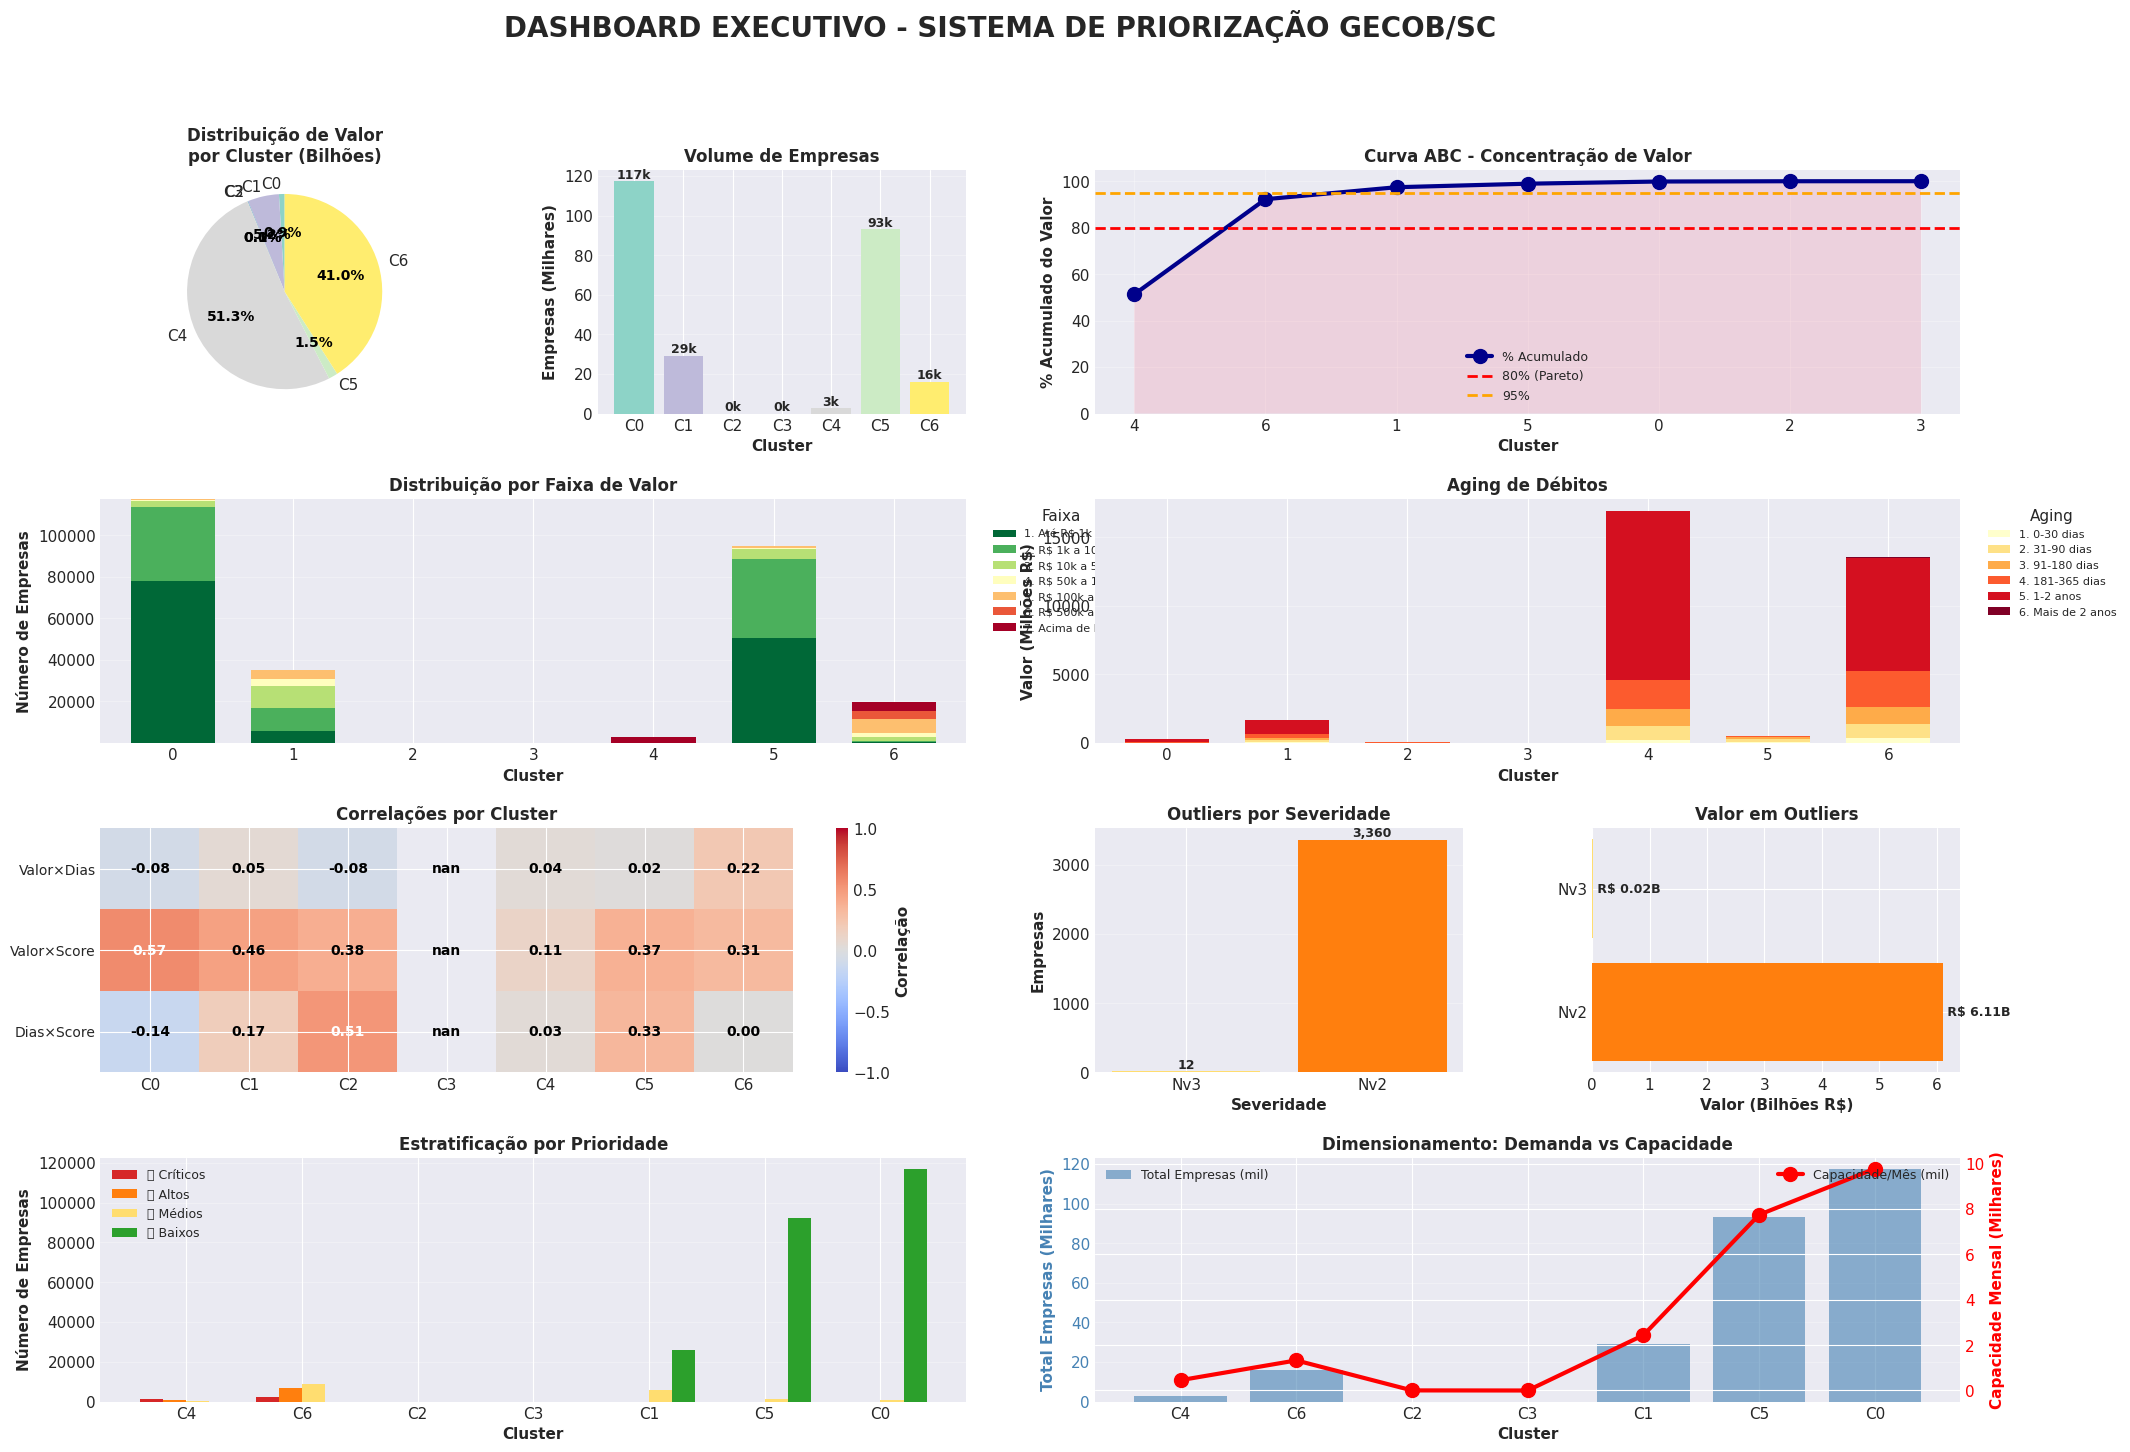


✅ ANÁLISES SQL COMPLETAS FINALIZADAS

Arquivos gerados:
  • dashboard_priorizacao_gecob.png - Dashboard executivo

Tabelas atualizadas:
  • gecob.prior_clusters_empresas
  • gecob.prior_outliers_identificados

Próximos passos sugeridos:
  1. Exportar Top 50 prioridades para ação imediata
  2. Criar views para monitoramento contínuo
  3. Automatizar relatórios semanais


In [21]:
import builtins  # Adicionar no topo

# ============================================================================
# PARTE 4: ANÁLISES DE CORRELAÇÃO E PADRÕES (CORRIGIDA)
# ============================================================================

print("\n" + "=" * 80)
print("4. ANÁLISES DE CORRELAÇÃO E PADRÕES")
print("=" * 80)

# 4.1 - Correlação entre Métricas por Cluster
print("\n4.1 - ANÁLISE DE CORRELAÇÃO: VALOR vs TEMPO vs SCORE\n")

query_correlacao = """
SELECT 
    cluster,
    
    -- Correlação Valor x Dias
    CORR(valor_total, dias_cobranca) as corr_valor_dias,
    
    -- Correlação Valor x Score
    CORR(valor_total, score_priorizacao) as corr_valor_score,
    
    -- Correlação Dias x Score
    CORR(dias_cobranca, score_priorizacao) as corr_dias_score,
    
    -- Coeficiente de variação
    STDDEV(valor_total) / AVG(valor_total) as cv_valor,
    STDDEV(dias_cobranca) / AVG(dias_cobranca) as cv_dias,
    STDDEV(score_priorizacao) / AVG(score_priorizacao) as cv_score,
    
    -- Métricas básicas
    COUNT(DISTINCT inscricao_estadual) as empresas,
    AVG(valor_total) as valor_medio,
    AVG(dias_cobranca) as dias_medio,
    AVG(score_priorizacao) as score_medio

FROM gecob.prior_clusters_empresas
GROUP BY cluster
ORDER BY cluster
"""

df_correlacao = spark.sql(query_correlacao).toPandas()
for col in df_correlacao.columns:
    if col != 'cluster':
        df_correlacao[col] = pd.to_numeric(df_correlacao[col], errors='coerce')

print(df_correlacao.to_string(index=False))

print("\nINTERPRETAÇÃO:")
for idx, row in df_correlacao.iterrows():
    print(f"\nCluster {int(row['cluster'])}:")
    
    # Valor x Dias - CORRIGIDO
    if builtins.abs(row['corr_valor_dias']) > 0.7:
        sinal = "positiva forte" if row['corr_valor_dias'] > 0 else "negativa forte"
        print(f"  • Valor vs Dias: Correlação {sinal} ({row['corr_valor_dias']:.2f})")
    elif builtins.abs(row['corr_valor_dias']) > 0.3:
        sinal = "positiva moderada" if row['corr_valor_dias'] > 0 else "negativa moderada"
        print(f"  • Valor vs Dias: Correlação {sinal} ({row['corr_valor_dias']:.2f})")
    else:
        print(f"  • Valor vs Dias: Correlação fraca ({row['corr_valor_dias']:.2f})")
    
    # Variabilidade
    if row['cv_valor'] > 1:
        print(f"  • Alta variabilidade de valores (CV={row['cv_valor']:.2f})")
    
    if row['score_medio'] > 55:
        print(f"  • Score alto: {row['score_medio']:.1f} - Prioridade elevada")

# 4.2 - Análise de Padrões Temporais - CORRIGIDA
print("\n\n4.2 - PADRÕES TEMPORAIS: EVOLUÇÃO POR TRIMESTRE\n")

query_temporal = """
WITH periodos_numericos AS (
    SELECT 
        cluster,
        CASE 
            WHEN dias_cobranca <= 90 THEN 1
            WHEN dias_cobranca <= 180 THEN 2
            WHEN dias_cobranca <= 365 THEN 3
            WHEN dias_cobranca <= 730 THEN 4
            ELSE 5
        END as periodo_num,
        CASE 
            WHEN dias_cobranca <= 90 THEN 'Q1 - 0-90 dias'
            WHEN dias_cobranca <= 180 THEN 'Q2 - 91-180 dias'
            WHEN dias_cobranca <= 365 THEN 'Q3 - 181-365 dias'
            WHEN dias_cobranca <= 730 THEN 'Q4 - 1-2 anos'
            ELSE 'Q5 - Mais de 2 anos'
        END as periodo,
        inscricao_estadual,
        valor_total,
        score_priorizacao
    FROM gecob.prior_clusters_empresas
),
agregados AS (
    SELECT 
        cluster,
        periodo_num,
        periodo,
        COUNT(DISTINCT inscricao_estadual) as empresas,
        SUM(valor_total) as valor_total,
        AVG(valor_total) as valor_medio,
        AVG(score_priorizacao) as score_medio
    FROM periodos_numericos
    GROUP BY cluster, periodo_num, periodo
)
SELECT 
    cluster,
    periodo,
    empresas,
    valor_total,
    valor_medio,
    score_medio,
    
    -- Percentual dentro do cluster
    valor_total / SUM(valor_total) OVER (PARTITION BY cluster) * 100 as pct_valor_periodo,
    
    -- Acumulado
    SUM(valor_total) OVER (PARTITION BY cluster ORDER BY periodo_num) as valor_acumulado
    
FROM agregados
ORDER BY cluster, periodo_num
"""

df_temporal = spark.sql(query_temporal).toPandas()
for col in df_temporal.columns:
    if col not in ['cluster', 'periodo']:
        df_temporal[col] = pd.to_numeric(df_temporal[col], errors='coerce')

print(df_temporal.to_string(index=False))

# Análise dos padrões temporais
print("\n" + "="*80)
print("INSIGHTS TEMPORAIS:")
print("="*80)

for cluster in df_temporal['cluster'].unique():
    cluster_data = df_temporal[df_temporal['cluster'] == cluster]
    
    print(f"\nCluster {int(cluster)}:")
    
    # Período com mais valor
    periodo_max = cluster_data.loc[cluster_data['valor_total'].idxmax()]
    print(f"  • Maior concentração: {periodo_max['periodo']}")
    print(f"    - R$ {periodo_max['valor_total']/1e6:.2f} milhões ({periodo_max['pct_valor_periodo']:.1f}%)")
    
    # Taxa de acumulação
    ultimos_90 = cluster_data[cluster_data['periodo'].str.contains('0-90')]['valor_total'].sum()
    total = cluster_data['valor_total'].sum()
    if total > 0:
        pct_recente = ultimos_90 / total * 100
        print(f"  • Débitos recentes (0-90 dias): {pct_recente:.1f}% do valor")
        
        if pct_recente < 20:
            print(f"    ⚠️  Baixa entrada de novos débitos - cluster estagnado")
        elif pct_recente > 50:
            print(f"    📈 Alto volume de débitos recentes - crescimento ativo")


# ============================================================================
# PARTE 5: IDENTIFICAÇÃO DE CASOS PRIORITÁRIOS
# ============================================================================

print("\n" + "=" * 80)
print("5. IDENTIFICAÇÃO DE CASOS PRIORITÁRIOS PARA AÇÃO")
print("=" * 80)

# 5.1 - Score de Prioridade Combinado
print("\n5.1 - RANKING DE PRIORIDADE COMBINADA (TOP 50)\n")

query_prioridade = """
WITH empresas_agregadas AS (
    SELECT 
        c.inscricao_estadual,
        c.cluster,
        COUNT(*) as qtd_debitos,
        SUM(c.valor_total) as valor_total_empresa,
        AVG(c.dias_cobranca) as dias_medio,
        AVG(c.score_priorizacao) as score_medio,
        MAX(c.valor_total) as maior_debito,
        
        -- Flag outlier
        CASE WHEN o.inscricao_estadual IS NOT NULL THEN 1 ELSE 0 END as is_outlier,
        COALESCE(o.qtd_outliers, 0) as severidade_outlier,
        
        -- Score combinado (ponderado)
        (AVG(c.score_priorizacao) * 0.4 +
         LEAST(SUM(c.valor_total) / 1000000, 100) * 0.3 +
         LEAST(AVG(c.dias_cobranca) / 365, 5) * 10 * 0.2 +
         CASE WHEN o.inscricao_estadual IS NOT NULL THEN 10 ELSE 0 END * 0.1
        ) as score_combinado
        
    FROM gecob.prior_clusters_empresas c
    LEFT JOIN gecob.prior_outliers_identificados o 
        ON c.inscricao_estadual = o.inscricao_estadual
    GROUP BY c.inscricao_estadual, c.cluster, o.inscricao_estadual, o.qtd_outliers
),
ranked AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY score_combinado DESC) as ranking_geral,
        ROW_NUMBER() OVER (PARTITION BY cluster ORDER BY score_combinado DESC) as ranking_cluster,
        
        -- Classificação de ação
        CASE 
            WHEN score_combinado >= 60 THEN '🔴 CRÍTICO - Ação Imediata'
            WHEN score_combinado >= 50 THEN '🟠 ALTO - Ação em 7 dias'
            WHEN score_combinado >= 40 THEN '🟡 MÉDIO - Ação em 30 dias'
            ELSE '🟢 BAIXO - Monitoramento'
        END as classificacao_acao
        
    FROM empresas_agregadas
)
SELECT 
    ranking_geral,
    inscricao_estadual,
    cluster,
    qtd_debitos,
    valor_total_empresa,
    dias_medio,
    score_medio,
    is_outlier,
    ROUND(score_combinado, 2) as score_combinado,
    classificacao_acao
FROM ranked
WHERE ranking_geral <= 50
ORDER BY ranking_geral
"""

df_prioridade = spark.sql(query_prioridade).toPandas()
for col in df_prioridade.columns:
    if col not in ['inscricao_estadual', 'cluster', 'classificacao_acao']:
        df_prioridade[col] = pd.to_numeric(df_prioridade[col], errors='coerce')

print(df_prioridade.to_string(index=False))

# Salvar lista de prioridades
print("\n" + "="*80)
print("Salvando lista de prioridades para ação...")

# Criar tabela de ações prioritárias
df_prioridade_spark = spark.createDataFrame(df_prioridade)
df_prioridade_spark.write.mode('overwrite').saveAsTable('gecob.prior_acoes_prioritarias')

print(f"✓ Top 50 casos prioritários salvos em: gecob.prior_acoes_prioritarias")

# 5.2 - Plano de Ação por Cluster
print("\n\n5.2 - PLANO DE AÇÃO RECOMENDADO POR CLUSTER\n")

query_plano_acao = """
SELECT 
    c.cluster,
    
    -- Volumetria
    COUNT(DISTINCT c.inscricao_estadual) as total_empresas,
    
    -- Por nível de urgência
    COUNT(DISTINCT CASE WHEN c.score_priorizacao >= 60 THEN c.inscricao_estadual END) as criticos,
    COUNT(DISTINCT CASE WHEN c.score_priorizacao >= 50 AND c.score_priorizacao < 60 THEN c.inscricao_estadual END) as altos,
    COUNT(DISTINCT CASE WHEN c.score_priorizacao >= 40 AND c.score_priorizacao < 50 THEN c.inscricao_estadual END) as medios,
    COUNT(DISTINCT CASE WHEN c.score_priorizacao < 40 THEN c.inscricao_estadual END) as baixos,
    
    -- Valores
    SUM(CASE WHEN c.score_priorizacao >= 60 THEN c.valor_total ELSE 0 END) as valor_criticos,
    SUM(CASE WHEN c.score_priorizacao >= 50 THEN c.valor_total ELSE 0 END) as valor_prioritarios,
    SUM(c.valor_total) as valor_total,
    
    -- Outliers
    COUNT(DISTINCT o.inscricao_estadual) as qtd_outliers,
    
    -- Métricas médias
    AVG(c.valor_total) as ticket_medio,
    AVG(c.dias_cobranca) as dias_medio,
    
    -- Capacidade estimada de cobrança (empresas por mês)
    CASE 
        WHEN COUNT(DISTINCT c.inscricao_estadual) > 10000 THEN ROUND(COUNT(DISTINCT c.inscricao_estadual) / 12, 0)
        WHEN COUNT(DISTINCT c.inscricao_estadual) > 1000 THEN ROUND(COUNT(DISTINCT c.inscricao_estadual) / 6, 0)
        ELSE ROUND(COUNT(DISTINCT c.inscricao_estadual) / 3, 0)
    END as capacidade_mensal_estimada

FROM gecob.prior_clusters_empresas c
LEFT JOIN gecob.prior_outliers_identificados o 
    ON c.inscricao_estadual = o.inscricao_estadual
GROUP BY c.cluster
ORDER BY valor_prioritarios DESC
"""

df_plano = spark.sql(query_plano_acao).toPandas()
for col in df_plano.columns:
    if col != 'cluster':
        df_plano[col] = pd.to_numeric(df_plano[col], errors='coerce')

print(df_plano.to_string(index=False))

print("\n" + "="*80)
print("RECOMENDAÇÕES DE AÇÃO POR CLUSTER:")
print("="*80)

for idx, row in df_plano.iterrows():
    cluster = int(row['cluster'])
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster}:")
    print(f"{'='*80}")
    print(f"  População: {int(row['total_empresas']):,} empresas")
    print(f"  Valor Total: R$ {row['valor_total']/1e6:.2f} milhões")
    print(f"  Ticket Médio: R$ {row['ticket_medio']:,.2f}")
    print(f"  Idade Média: {row['dias_medio']:.0f} dias")
    
    print(f"\n  ESTRATIFICAÇÃO POR PRIORIDADE:")
    total_empresas = row['total_empresas']
    if total_empresas > 0:
        print(f"    🔴 Críticos:  {int(row['criticos']):>6,} empresas ({row['criticos']/total_empresas*100:>5.1f}%) - R$ {row['valor_criticos']/1e6:>8.2f}M")
        print(f"    🟠 Altos:     {int(row['altos']):>6,} empresas ({row['altos']/total_empresas*100:>5.1f}%)")
        print(f"    🟡 Médios:    {int(row['medios']):>6,} empresas ({row['medios']/total_empresas*100:>5.1f}%)")
        print(f"    🟢 Baixos:    {int(row['baixos']):>6,} empresas ({row['baixos']/total_empresas*100:>5.1f}%)")
    
    if row['qtd_outliers'] > 0:
        print(f"\n  ⚠️  ATENÇÃO: {int(row['qtd_outliers']):,} casos outliers detectados neste cluster")
    
    print(f"\n  📋 PLANO DE AÇÃO SUGERIDO:")
    if row['criticos'] > 0:
        dias_criticos = 7
        casos_por_dia = row['criticos'] / dias_criticos
        print(f"    ▸ Fase 1: Priorizar {int(row['criticos']):,} casos críticos (próximos {dias_criticos} dias)")
        print(f"             Ritmo: ~{casos_por_dia:.0f} casos/dia")
        print(f"             Impacto: R$ {row['valor_criticos']/1e6:.2f} milhões")
    if row['altos'] > 0:
        print(f"    ▸ Fase 2: Trabalhar {int(row['altos']):,} casos altos (próximos 30 dias)")
    if row['medios'] > 0:
        print(f"    ▸ Fase 3: Abordar {int(row['medios']):,} casos médios (próximos 90 dias)")
    
    print(f"\n    ▸ Capacidade sugerida: {int(row['capacidade_mensal_estimada']):,} casos/mês")
    
    # Recomendação estratégica
    pct_criticos = row['valor_criticos'] / row['valor_total'] if row['valor_total'] > 0 else 0
    
    print(f"\n  💡 ESTRATÉGIA RECOMENDADA:")
    if pct_criticos > 0.5:
        print(f"     • Cluster CONCENTRADO ({pct_criticos*100:.1f}% do valor em críticos)")
        print(f"     • Foco: Poucos casos de alto impacto")
        print(f"     • Abordagem: Negociação personalizada, equipe sênior")
        print(f"     • KPI: Taxa de acordo em casos críticos")
    elif row['total_empresas'] > 50000:
        print(f"     • Cluster VOLUMOSO ({int(row['total_empresas']):,} empresas)")
        print(f"     • Foco: Automação e escala")
        print(f"     • Abordagem: Comunicação em massa, self-service")
        print(f"     • KPI: Volume processado por colaborador")
    elif row['dias_medio'] > 500:
        print(f"     • Cluster ANTIGO (média {row['dias_medio']:.0f} dias)")
        print(f"     • Foco: Recuperação e ações jurídicas")
        print(f"     • Abordagem: Avaliação de viabilidade, execução fiscal")
        print(f"     • KPI: Taxa de recuperação via judicial")
    else:
        print(f"     • Cluster BALANCEADO")
        print(f"     • Foco: Processo padrão de cobrança")
        print(f"     • Abordagem: Workflow regular, follow-up sistemático")
        print(f"     • KPI: Taxa de conversão em pagamento")

print("\n" + "="*80)
print("✅ ANÁLISES ESTRATÉGICAS CONCLUÍDAS")
print("="*80)
print("\nTabelas criadas/atualizadas:")
print("  • gecob.prior_clusters_empresas")
print("  • gecob.prior_outliers_identificados")
print("  • gecob.prior_acoes_prioritarias (TOP 50 para ação)")
print("\nPróximos passos:")
print("  1. Exportar listas prioritárias para equipes de cobrança")
print("  2. Configurar dashboards de monitoramento")
print("  3. Estabelecer rotina de atualização semanal")
print("="*80)

# ============================================================================
# PARTE 6: VISUALIZAÇÕES AVANÇADAS
# ============================================================================

print("\n" + "=" * 80)
print("6. GERANDO VISUALIZAÇÕES AVANÇADAS")
print("=" * 80)

# Dashboard Executivo
print("\nGerando Dashboard Executivo...")

fig = plt.figure(figsize=(24, 16))
gs = fig.add_gridspec(4, 4, hspace=0.35, wspace=0.35)

fig.suptitle('DASHBOARD EXECUTIVO - SISTEMA DE PRIORIZAÇÃO GECOB/SC', 
             fontsize=20, fontweight='bold', y=0.98)

# Preparar dados agregados
df_stats_agg = df_stats_clusters.copy()

# 1. Distribuição de Valor por Cluster (Pizza)
ax1 = fig.add_subplot(gs[0, 0])
valores_cluster = df_stats_agg.groupby('cluster')['valor_total_cluster'].sum()
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(valores_cluster)))
wedges, texts, autotexts = ax1.pie(valores_cluster/1e9, 
                                     labels=[f"C{int(c)}" for c in valores_cluster.index], 
                                     autopct='%1.1f%%', colors=colors_pie, startangle=90)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')
ax1.set_title('Distribuição de Valor\npor Cluster (Bilhões)', fontweight='bold', fontsize=12)

# 2. Empresas por Cluster (Barras)
ax2 = fig.add_subplot(gs[0, 1])
empresas_cluster = df_stats_agg.groupby('cluster')['qtd_empresas'].sum()
bars = ax2.bar([f"C{int(c)}" for c in empresas_cluster.index], empresas_cluster.values/1000, 
               color=colors_pie)
ax2.set_xlabel('Cluster', fontweight='bold')
ax2.set_ylabel('Empresas (Milhares)', fontweight='bold')
ax2.set_title('Volume de Empresas', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(empresas_cluster.values/1000):
    ax2.text(i, v, f'{v:.0f}k', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 3. Curva ABC
ax3 = fig.add_subplot(gs[0, 2:])
ax3.plot(df_abc['cluster'].astype(str), df_abc['pct_acumulado'], 
         marker='o', linewidth=3, markersize=10, color='darkblue', label='% Acumulado')
ax3.axhline(y=80, color='red', linestyle='--', linewidth=2, label='80% (Pareto)')
ax3.axhline(y=95, color='orange', linestyle='--', linewidth=2, label='95%')
ax3.fill_between(range(len(df_abc)), 0, df_abc['pct_acumulado'], alpha=0.2)
ax3.set_xlabel('Cluster', fontweight='bold')
ax3.set_ylabel('% Acumulado do Valor', fontweight='bold')
ax3.set_title('Curva ABC - Concentração de Valor', fontweight='bold', fontsize=12)
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 105)

# 4-5. Distribuição por Faixas (se houver dados)
if len(df_faixas) > 0:
    ax4 = fig.add_subplot(gs[1, :2])
    pivot_faixas = df_faixas.pivot_table(index='cluster', columns='faixa_valor', 
                                          values='empresas', fill_value=0)
    pivot_faixas.plot(kind='bar', stacked=True, ax=ax4, 
                      colormap='RdYlGn_r', width=0.7)
    ax4.set_xlabel('Cluster', fontweight='bold')
    ax4.set_ylabel('Número de Empresas', fontweight='bold')
    ax4.set_title('Distribuição por Faixa de Valor', fontweight='bold', fontsize=12)
    ax4.legend(title='Faixa', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax4.grid(True, alpha=0.3, axis='y')
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=0)

# 6. Aging
if len(df_aging) > 0:
    ax5 = fig.add_subplot(gs[1, 2:])
    pivot_aging = df_aging.pivot_table(index='cluster', columns='faixa_aging', 
                                        values='valor_total', fill_value=0) / 1e6
    pivot_aging.plot(kind='bar', stacked=True, ax=ax5, 
                     colormap='YlOrRd', width=0.7)
    ax5.set_xlabel('Cluster', fontweight='bold')
    ax5.set_ylabel('Valor (Milhões R$)', fontweight='bold')
    ax5.set_title('Aging de Débitos', fontweight='bold', fontsize=12)
    ax5.legend(title='Aging', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=8)
    ax5.grid(True, alpha=0.3, axis='y')
    plt.setp(ax5.xaxis.get_majorticklabels(), rotation=0)

# 7. Matriz de Correlação
ax6 = fig.add_subplot(gs[2, :2])
corr_data = df_correlacao[['corr_valor_dias', 'corr_valor_score', 'corr_dias_score']].T
im = ax6.imshow(corr_data, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
ax6.set_xticks(range(len(df_correlacao)))
ax6.set_xticklabels([f"C{int(c)}" for c in df_correlacao['cluster']])
ax6.set_yticks(range(3))
ax6.set_yticklabels(['Valor×Dias', 'Valor×Score', 'Dias×Score'], fontsize=10)
ax6.set_title('Correlações por Cluster', fontweight='bold', fontsize=12)
cbar = plt.colorbar(im, ax=ax6)
cbar.set_label('Correlação', fontweight='bold')

# Adicionar valores na matriz
for i in range(3):
    for j in range(len(df_correlacao)):
        val = corr_data.iloc[i, j]
        color = 'white' if builtins.abs(val) > 0.5 else 'black'
        ax6.text(j, i, f'{val:.2f}', ha="center", va="center", 
                color=color, fontsize=10, fontweight='bold')

# 8-9. Outliers
if len(df_stats_outliers) > 0:
    ax7 = fig.add_subplot(gs[2, 2])
    colors_out = ['#ffdd70', '#ff7f0e', '#d62728'][:len(df_stats_outliers)]
    ax7.bar([f"Nv{int(s)}" for s in df_stats_outliers['nivel_severidade']], 
            df_stats_outliers['empresas'],
            color=colors_out)
    ax7.set_xlabel('Severidade', fontweight='bold')
    ax7.set_ylabel('Empresas', fontweight='bold')
    ax7.set_title('Outliers por Severidade', fontweight='bold', fontsize=12)
    ax7.grid(True, alpha=0.3, axis='y')
    for i, v in enumerate(df_stats_outliers['empresas']):
        ax7.text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    ax8 = fig.add_subplot(gs[2, 3])
    ax8.barh([f"Nv{int(s)}" for s in df_stats_outliers['nivel_severidade']], 
             df_stats_outliers['valor_total']/1e9,
             color=colors_out)
    ax8.set_xlabel('Valor (Bilhões R$)', fontweight='bold')
    ax8.set_title('Valor em Outliers', fontweight='bold', fontsize=12)
    ax8.invert_yaxis()
    for i, v in enumerate(df_stats_outliers['valor_total']/1e9):
        ax8.text(v, i, f' R$ {v:.2f}B', va='center', fontsize=9, fontweight='bold')

# 10. Plano de Ação
ax9 = fig.add_subplot(gs[3, :2])
x = np.arange(len(df_plano))
width = 0.2
bars1 = ax9.bar(x - 1.5*width, df_plano['criticos'], width, label='🔴 Críticos', color='#d62728')
bars2 = ax9.bar(x - 0.5*width, df_plano['altos'], width, label='🟠 Altos', color='#ff7f0e')
bars3 = ax9.bar(x + 0.5*width, df_plano['medios'], width, label='🟡 Médios', color='#ffdd70')
bars4 = ax9.bar(x + 1.5*width, df_plano['baixos'], width, label='🟢 Baixos', color='#2ca02c')
ax9.set_xlabel('Cluster', fontweight='bold')
ax9.set_ylabel('Número de Empresas', fontweight='bold')
ax9.set_title('Estratificação por Prioridade', fontweight='bold', fontsize=12)
ax9.set_xticks(x)
ax9.set_xticklabels([f"C{int(c)}" for c in df_plano['cluster']])
ax9.legend(fontsize=9)
ax9.grid(True, alpha=0.3, axis='y')

# 11. Capacidade vs Demanda
ax10 = fig.add_subplot(gs[3, 2:])
ax10_twin = ax10.twinx()
ax10.bar([f"C{int(c)}" for c in df_plano['cluster']], df_plano['total_empresas']/1000, 
         alpha=0.6, color='steelblue', label='Total Empresas (mil)')
ax10_twin.plot([f"C{int(c)}" for c in df_plano['cluster']], df_plano['capacidade_mensal_estimada']/1000,
               marker='o', color='red', linewidth=3, markersize=10, label='Capacidade/Mês (mil)')
ax10.set_xlabel('Cluster', fontweight='bold')
ax10.set_ylabel('Total Empresas (Milhares)', color='steelblue', fontweight='bold')
ax10_twin.set_ylabel('Capacidade Mensal (Milhares)', color='red', fontweight='bold')
ax10.set_title('Dimensionamento: Demanda vs Capacidade', fontweight='bold', fontsize=12)
ax10.tick_params(axis='y', labelcolor='steelblue')
ax10_twin.tick_params(axis='y', labelcolor='red')
ax10.grid(True, alpha=0.3, axis='y')
ax10.legend(loc='upper left', fontsize=9)
ax10_twin.legend(loc='upper right', fontsize=9)

plt.savefig('dashboard_priorizacao_gecob.png', dpi=300, bbox_inches='tight')
print("✓ Dashboard salvo: dashboard_priorizacao_gecob.png")
plt.show()

print("\n" + "="*80)
print("✅ ANÁLISES SQL COMPLETAS FINALIZADAS")
print("="*80)
print("\nArquivos gerados:")
print("  • dashboard_priorizacao_gecob.png - Dashboard executivo")
print("\nTabelas atualizadas:")
print("  • gecob.prior_clusters_empresas")
print("  • gecob.prior_outliers_identificados")
print("\nPróximos passos sugeridos:")
print("  1. Exportar Top 50 prioridades para ação imediata")
print("  2. Criar views para monitoramento contínuo")
print("  3. Automatizar relatórios semanais")
print("="*80)